In [108]:
# Gather results from full run
import pandas as pd
import glob
import os
from pathlib import Path

# Find all benchmark_results.csv files in the highs_hipo_full directory
results_dir = "../results/highs_hipo_full"
csv_files = glob.glob(f"{results_dir}/*/benchmark_results.csv")

print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
all_dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    print(f"Read {len(df)} rows from {os.path.basename(os.path.dirname(csv_file))}")
    all_dfs.append(df)

# Concatenate all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)

    # Save to highs_results.csv
    output_file = Path(results_dir) / "combined_highs_results.csv"
    combined_df.to_csv(output_file, index=False)

    # Also expose as `results` for downstream cells when running this notebook interactively
    results = combined_df

    print(f"\nSuccessfully gathered {len(combined_df)} total rows")
    print(f"Saved to: {output_file}")
    print(f"\nColumns: {list(combined_df.columns)}")
    print(f"Shape: {combined_df.shape}")
    print(f"\nSolver breakdown:")
    print(combined_df['Solver'].value_counts())
else:
    print("No data to combine")


# Compare HiGHS 1.11.x variants vs highs 1.10.0 baseline
# We'll treat each 1.11.x variant separately using the 'Solver' column so variants aren't lumped together.
# Extract baseline (1.10.0) results and exclude reference sizes
# Note: ensure `results` exists in the notebook runtime; if not, try to read the combined CSV
if 'results' not in globals():
    try:
        results = pd.read_csv(output_file)
        print(f"Loaded results from {output_file}")
    except Exception:
        raise RuntimeError("`results` DataFrame not available. Run the data gathering cell first.")

# Ensure bench-size exists; canonical construction is usually Benchmark + '-' + Size
if 'bench-size' not in results.columns:
    if 'Benchmark' in results.columns and 'Size' in results.columns:
        results['bench-size'] = results['Benchmark'].astype(str) + '-' + results['Size'].astype(str)
    else:
        # fallback: try other common names or create a simpler composite
        if 'Benchmark' in results.columns:
            results['bench-size'] = results['Benchmark'].astype(str)
        elif 'Size' in results.columns:
            results['bench-size'] = results['Size'].astype(str)
        else:
            # as a last resort, create an index-based identifier
            results['bench-size'] = results.index.astype(str)

highs_110 = results[(results["Solver Version"] == "1.10.0") & (results["Size"] != "reference")].copy()
# Extract all 1.11.x results (may have different solver names for variants)
highs_111_all = results[results["Solver Version"].astype(str).str.startswith("1.11.0")].copy()

print(f"Found {len(highs_110)} results for highs-1.10.0")
print(f"Found {len(highs_111_all)} results for highs-1.11.x variants")

# Ensure required columns exist in both dataframes; if not, create them with pd.NA so selection never KeyErrors
required_cols = ["bench-size", "Benchmark", "Size", "Runtime (s)", "Memory Usage (MB)", "Status", "Objective Value"]
for col in required_cols:
    if col not in highs_110.columns:
        highs_110[col] = pd.NA
    if col not in highs_111_all.columns:
        highs_111_all[col] = pd.NA

# Detect VM hostname column (common candidate names)
vm_candidates = {"hostname", "host", "vmhostname", "vm", "instancename", "instance", "vm_name", "vm-hostname", "vmhostname", "vm host"}
vm_col = None
for c in list(highs_110.columns) + list(highs_111_all.columns):
    normalized = c.lower().replace(' ', '').replace('_', '').replace('-', '')
    if normalized in vm_candidates:
        vm_col = c
        break

if vm_col:
    print(f"Detected VM hostname column: {vm_col}")
else:
    print("No VM hostname-like column detected; vm_hostname will be left empty (pd.NA)")

# Load benchmark metadata to map (Benchmark, Size) -> Size label (S/M/L)
meta_path = Path('../results/metadata.yaml')
size_map = {}
try:
    import yaml
    with open(meta_path) as fh:
        meta = yaml.safe_load(fh)
    benchmarks_meta = meta.get('benchmarks', {}) if isinstance(meta, dict) else {}
    for bench_key, bench_info in benchmarks_meta.items():
        sizes = bench_info.get('Sizes') or []
        for s in sizes:
            name = s.get('Name')
            size_label = s.get('Size')
            if name and size_label:
                size_map[(bench_key, str(name))] = size_label
except Exception as e:
    print(f"Could not load metadata.yaml for bench-size labels: {e}")

# Prepare baseline frame keyed by bench-size
# Include Objective Value for baseline and preserve Benchmark column (we need it for metadata lookup)
baseline_df = highs_110[["bench-size", "Benchmark", "Size", "Runtime (s)", "Memory Usage (MB)", "Status", "Objective Value"]].rename(columns={
    "Runtime (s)": "highs_1.10.0_runtime",
    "Memory Usage (MB)": "highs_1.10.0_memory",
    "Status": "highs_1.10.0_status",
    "Objective Value": "highs_1.10.0_objective"
})

# If VM column detected, include baseline VM hostname
if vm_col and vm_col in highs_110.columns:
    baseline_df = baseline_df.merge(highs_110[["bench-size", vm_col]], on="bench-size", how="left").rename(columns={vm_col: "baseline_vm_hostname"})
else:
    baseline_df["baseline_vm_hostname"] = pd.NA

# We'll iterate over each distinct Solver name in the 1.11.x set so variants are kept separate
variant_names = sorted(highs_111_all["Solver"].fillna("<unknown>").unique())
comparison_rows = []
summary_frames = []

for variant in variant_names:
    # Include Objective Value for variant runs and VM hostname if available
    # NOTE: do NOT include 'Size' here; keep Size only from baseline to avoid pandas creating Size_x/Size_y columns
    sel_cols = ["bench-size", "Runtime (s)", "Memory Usage (MB)", "Status", "Objective Value"]
    if vm_col and vm_col in highs_111_all.columns:
        sel_cols.append(vm_col)

    variant_df = highs_111_all[highs_111_all["Solver"] == variant][sel_cols].rename(columns={
        "Runtime (s)": "variant_runtime",
        "Memory Usage (MB)": "variant_memory",
        "Status": "variant_status",
        "Objective Value": "variant_objective"
    })

    # If VM column present, rename it for the variant
    if vm_col and vm_col in variant_df.columns:
        variant_df = variant_df.rename(columns={vm_col: "variant_vm_hostname"})
    else:
        variant_df["variant_vm_hostname"] = pd.NA

    merged = baseline_df.merge(variant_df, on="bench-size", how="inner")
    if len(merged) == 0:
        continue

    # add variant name for grouping and clarity
    merged["variant_solver"] = variant

    # Map bench-size label (S/M/L) using metadata; try some normalization fallbacks
    def _lookup_size_label(row):
        bench = row.get('Benchmark')
        size_name = row.get('Size')
        if pd.notna(bench) and pd.notna(size_name):
            # try direct match
            key = (bench, str(size_name))
            if key in size_map:
                return size_map[key]
            # try underscore/dash variants and lowercase variants
            alt_keys = [
                (bench.replace('_', '-'), str(size_name)),
                (bench.replace('-', '_'), str(size_name)),
                (bench.lower(), str(size_name)),
                (bench.lower().replace('_', '-'), str(size_name)),
                (bench.lower().replace('-', '_'), str(size_name)),
            ]
            for k in alt_keys:
                if k in size_map:
                    return size_map[k]
        return pd.NA

    merged["bench_size_label"] = merged.apply(_lookup_size_label, axis=1)

    # Compute metrics: speedup (baseline / variant), absolute time diff and memory diff
    # Protect against division by zero / missing runtimes
    merged["runtime_speedup"] = merged.apply(lambda r: (r["highs_1.10.0_runtime"] / r["variant_runtime"]) if pd.notna(r["highs_1.10.0_runtime"]) and pd.notna(r["variant_runtime"]) and r["variant_runtime"] != 0 else pd.NA, axis=1)
    merged["runtime_diff_seconds"] = merged.apply(lambda r: (r["highs_1.10.0_runtime"] - r["variant_runtime"]) if pd.notna(r["highs_1.10.0_runtime"]) and pd.notna(r["variant_runtime"]) else pd.NA, axis=1)
    merged["memory_diff_mb"] = merged.apply(lambda r: (r["highs_1.10.0_memory"] - r["variant_memory"]) if pd.notna(r["highs_1.10.0_memory"]) and pd.notna(r["variant_memory"]) else pd.NA, axis=1)

    # Compute objective difference when available (baseline - variant)
    def _calc_obj_diff(row):
        try:
            if pd.notna(row.get("highs_1.10.0_objective")) and pd.notna(row.get("variant_objective")):
                return row["highs_1.10.0_objective"] - row["variant_objective"]
        except Exception:
            return pd.NA
        return pd.NA

    merged["objective_diff"] = merged.apply(_calc_obj_diff, axis=1)

    # Keep only rows where both runs succeeded for 'better/worse' classification
    both_ok = (merged["highs_1.10.0_status"] == "ok") & (merged["variant_status"] == "ok")
    merged_ok = merged[both_ok].copy()

    # Sort by speedup magnitude
    merged_ok = merged_ok.sort_values("runtime_speedup", ascending=False)

    # Save per-variant CSVs (better/worse relative to baseline). Include bench-size and objective columns in outputs
    variant_better = merged_ok[merged_ok["runtime_speedup"] > 1.0].copy()
    variant_worse = merged_ok[merged_ok["runtime_speedup"] < 1.0].copy()

    out_cols = [
        # Baseline group
        "bench-size",
        "Benchmark",
        "Size",
        "bench_size_label",
        "highs_1.10.0_runtime",
        "highs_1.10.0_memory",
        "highs_1.10.0_objective",
        "highs_1.10.0_status",
        "baseline_vm_hostname",
        # Variant group
        "variant_solver",
        "variant_runtime",
        "variant_memory",
        "variant_objective",
        "variant_status",
        "variant_vm_hostname",
        # Diffs / derived
        "runtime_speedup",
        "runtime_diff_seconds",
        "memory_diff_mb",
        "objective_diff",
    ]

    # Sort outputs by bench-size for readability
    if not variant_better.empty:
        variant_better = variant_better.sort_values("bench-size")
    if not variant_worse.empty:
        variant_worse = variant_worse.sort_values("bench-size")

    if len(variant_better) > 0:
        variant_better.to_csv(f"../hipo_better_{variant.replace(' ', '_')}.csv", index=False, columns=[c for c in out_cols if c in variant_better.columns])
    if len(variant_worse) > 0:
        variant_worse.to_csv(f"../hipo_worse_{variant.replace(' ', '_')}.csv", index=False, columns=[c for c in out_cols if c in variant_worse.columns])

    # keep for combined summary (include all merged rows, not only ok ones)
    summary_frames.append(merged)

# Combine all variant comparisons into a single dataframe for overview
if summary_frames:
    comparison_df = pd.concat(summary_frames, ignore_index=True)
    # sort combined overview by bench-size as well
    if 'bench-size' in comparison_df.columns:
        comparison_df = comparison_df.sort_values("bench-size")
    print(f"Combined comparison dataframe shape: {comparison_df.shape}")
else:
    comparison_df = pd.DataFrame()
    print("No matching benchmarks found between baseline and 1.11.x variants.")

# Show aggregate better/worse counts per variant (only where both succeeded)
if not comparison_df.empty:
    both_ok_mask = (comparison_df["highs_1.10.0_status"] == "ok") & (comparison_df["variant_status"] == "ok")
    agg = comparison_df[both_ok_mask].groupby("variant_solver")["runtime_speedup"].agg(["count", "mean", "median"]).rename(columns={"count": "matched_count"})
    print("\nPer-variant summary (matched runs only):")
    print(agg.round(3))

    # Save combined overview CSV
    # Include bench-size and objective columns
    cols_for_overview = [
        # Baseline group first
        "bench-size",
        # "Benchmark",
        # "Size",
        "bench_size_label",
        "variant_solver",
        "highs_1.10.0_status",
        "variant_status",
        "baseline_vm_hostname",
        "variant_vm_hostname",
        "highs_1.10.0_runtime",
        "variant_runtime",
        "runtime_diff_seconds",
        "runtime_speedup",
        "highs_1.10.0_memory",
        "variant_memory",
        "memory_diff_mb",
        "highs_1.10.0_objective",
        "variant_objective",
        "objective_diff",
    ]

    comparison_df.to_csv("../hipo_comparison_all_variants.csv", index=False, columns=[c for c in cols_for_overview if c in comparison_df.columns])
# End of comparison cell

Found 12 CSV files
Read 10 rows from benchmark-instance-highmem-vm-00
Read 8 rows from benchmark-instance-highmem-vm-02
Read 80 rows from benchmark-instance-standard-03
Read 92 rows from benchmark-instance-standard-01
Read 99 rows from benchmark-instance-standard-04
Read 83 rows from benchmark-instance-standard-00
Read 85 rows from benchmark-instance-standard-05
Read 6 rows from benchmark-instance-highmem-vm-03
Read 77 rows from benchmark-instance-standard-06
Read 4 rows from benchmark-instance-highmem-vm-07
Read 8 rows from benchmark-instance-highmem-vm-01
Read 83 rows from benchmark-instance-standard-02

Successfully gathered 635 total rows
Saved to: ../results/highs_hipo_full/combined_highs_results.csv

Columns: ['Benchmark', 'Size', 'Solver', 'Solver Version', 'Solver Release Year', 'Status', 'Termination Condition', 'Runtime (s)', 'Memory Usage (MB)', 'Objective Value', 'Max Integrality Violation', 'Duality Gap', 'Reported Runtime (s)', 'Timeout', 'Hostname', 'Run ID', 'Timestamp'

In [109]:
# Compare highs-binary (1.11.0) vs highs (1.10.0)
# Extract results for both versions
highs_110 = results[(results["Solver Version"] == "1.10.0") & (results["Size"] != "reference")].copy()
highs_111 = results[(results["Solver Version"] == "1.11.0-hipo")].copy()

print(f"Found {len(highs_110)} results for highs-1.10.0")
print(f"Found {len(highs_111)} results for highs-1.11.0")

# Merge on benchmark-size to compare
comparison_df = highs_110[["bench-size", "Benchmark", "Size", "Runtime (s)", "Memory Usage (MB)", "Status"]].rename(
    columns={
        "Runtime (s)": "highs_1.10.0_runtime",
        "Memory Usage (MB)": "highs_1.10.0_memory",
        "Status": "highs_1.10.0_status"
    }
)

comparison_df = comparison_df.merge(
    highs_111[["bench-size", "Runtime (s)", "Memory Usage (MB)", "Status"]].rename(
        columns={
            "Runtime (s)": "highs_1.11.0_runtime",
            "Memory Usage (MB)": "highs_1.11.0_memory",
            "Status": "highs_1.11.0_status"
        }
    ),
    on="bench-size",
    how="inner"
)

print(f"\nFound {len(comparison_df)} matching benchmarks for comparison")

# Calculate performance difference (positive means 1.11.0 is faster)
comparison_df["runtime_speedup"] = comparison_df["highs_1.10.0_runtime"] / comparison_df["highs_1.11.0_runtime"]
comparison_df["runtime_diff_seconds"] = comparison_df["highs_1.10.0_runtime"] - comparison_df["highs_1.11.0_runtime"]
comparison_df["memory_diff_mb"] = comparison_df["highs_1.10.0_memory"] - comparison_df["highs_1.11.0_memory"]

# Identify where both succeeded
both_ok = (comparison_df["highs_1.10.0_status"] == "ok") & (comparison_df["highs_1.11.0_status"] == "ok")

# Split into better and worse
# Better: 1.11.0 is faster (speedup > 1.0)
# Worse: 1.11.0 is slower (speedup < 1.0)
hipo_better = comparison_df[both_ok & (comparison_df["runtime_speedup"] > 1.0)].copy()
hipo_worse = comparison_df[both_ok & (comparison_df["runtime_speedup"] < 1.0)].copy()

# Sort by magnitude of difference
hipo_better = hipo_better.sort_values("runtime_speedup", ascending=False)
hipo_worse = hipo_worse.sort_values("runtime_speedup", ascending=True)

print(f"\nBenchmarks where highs-1.11.0 is BETTER (faster): {len(hipo_better)}")
print(f"Benchmarks where highs-1.11.0 is WORSE (slower): {len(hipo_worse)}")

# Save to CSV files
hipo_better.to_csv("../hipo_better.csv", index=False)
hipo_worse.to_csv("../hipo_worse.csv", index=False)

print(f"\nSaved results to:")
print(f"  - ../hipo_better.csv ({len(hipo_better)} rows)")
print(f"  - ../hipo_worse.csv ({len(hipo_worse)} rows)")

# Show summary statistics
if len(hipo_better) > 0:
    print(f"\nBETTER - Summary:")
    print(f"  Average speedup: {hipo_better['runtime_speedup'].mean():.3f}x")
    print(f"  Median speedup: {hipo_better['runtime_speedup'].median():.3f}x")
    print(f"  Best speedup: {hipo_better['runtime_speedup'].max():.3f}x")
    print(f"  Average time saved: {hipo_better['runtime_diff_seconds'].mean():.2f}s")

if len(hipo_worse) > 0:
    print(f"\nWORSE - Summary:")
    print(f"  Average slowdown: {hipo_worse['runtime_speedup'].mean():.3f}x")
    print(f"  Median slowdown: {hipo_worse['runtime_speedup'].median():.3f}x")
    print(f"  Worst slowdown: {hipo_worse['runtime_speedup'].min():.3f}x")
    print(f"  Average time lost: {abs(hipo_worse['runtime_diff_seconds'].mean()):.2f}s")

Found 101 results for highs-1.10.0
Found 385 results for highs-1.11.0

Found 385 matching benchmarks for comparison

Benchmarks where highs-1.11.0 is BETTER (faster): 138
Benchmarks where highs-1.11.0 is WORSE (slower): 135

Saved results to:
  - ../hipo_better.csv (138 rows)
  - ../hipo_worse.csv (135 rows)

BETTER - Summary:
  Average speedup: 3.662x
  Median speedup: 1.756x
  Best speedup: 37.775x
  Average time saved: 1176.96s

WORSE - Summary:
  Average slowdown: 0.664x
  Median slowdown: 0.699x
  Worst slowdown: 0.140x
  Average time lost: 119.46s


## How do HiGHS variants compare?

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from humanize import naturaldelta
from matplotlib.patches import Patch

In [111]:
# Color map for HiGHS variants and other solvers
color_map = {
    "highs": "#43BF94",  # green - baseline
    "highs-binary": "#2D8A63",  # darker green
    "highs-hipo": "#F66C49",  # red/orange - primary HIPO variant
    "highs-hipo-ipm": "#F9A826",  # orange
    "highs-hipo-32": "#3B82F6",  # blue
    "highs-hipo-64": "#7C3AED",  # purple
    "highs-hipo-128": "#8B5CF6",  # lighter purple
    "cbc": "#F9CD5A",  # yellow
    "glpk": "#9333EA",  # purple
    "gurobi": "#DC2626",  # bright red
    "scip": "#0EA5E9",  # sky blue
}


def plot_single_benchmark_comparison(df, benchmark_name, figsize=(10, 6)):
    """Plot a single benchmark with solvers on x-axis.

    Args:
        df: DataFrame with benchmark results
        benchmark_name: The bench-size to plot
        figsize: Figure size tuple
    """
    # Filter to single benchmark
    bench_data = df[df["bench-size"] == benchmark_name].copy()

    if len(bench_data) == 0:
        print(f"No data found for benchmark: {benchmark_name}")
        return

    # Remove old solver versions if multiple versions exist
    bench_data = bench_data.sort_values(["Solver", "Solver Release Year"]).drop_duplicates(["Solver"], keep="last")

    # Identify successful vs failed runs
    bench_data["Success"] = bench_data["Status"] == "ok"

    # Find fastest successful solver
    successful_data = bench_data[bench_data["Success"]]
    if len(successful_data) == 0:
        print(f"No successful runs for benchmark: {benchmark_name}")
        return

    fastest_runtime = successful_data["Runtime (s)"].min()

    # Calculate slowdown for successful runs only
    bench_data.loc[bench_data["Success"], "Slowdown"] = bench_data.loc[bench_data["Success"], "Runtime (s)"] / fastest_runtime

    # For failed runs, don't calculate slowdown (will plot differently)
    bench_data.loc[~bench_data["Success"], "Slowdown"] = 0

    # Sort: successful runs by slowdown, then failed runs
    bench_data = bench_data.sort_values(["Success", "Slowdown"], ascending=[False, True])

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Separate successful and failed data
    slowdowns = []
    colors_list = []

    for _, row in bench_data.iterrows():
        if row["Success"]:
            slowdowns.append(row["Slowdown"])
            colors_list.append(color_map.get(row["Solver"], "#888888"))
        else:
            slowdowns.append(0)  # Don't show bar for failed runs
            colors_list.append((color_map.get(row["Solver"], "#888888"), 0.2))

    # Create bars
    bars = ax.bar(range(len(bench_data)), slowdowns, color=colors_list)

    # Add horizontal line at y=1
    ax.axhline(1, color="grey", linestyle="--", linewidth=1, alpha=0.7)

    # Calculate max slowdown for positioning failed labels
    max_slowdown = bench_data[bench_data["Success"]]["Slowdown"].max() if len(successful_data) > 0 else 1

    # Add value labels on bars
    for i, (_, row) in enumerate(bench_data.iterrows()):
        if row["Success"]:
            label = f"{row['Slowdown']:.2f}x\n{naturaldelta(row['Runtime (s)'])}"
            y_pos = row["Slowdown"] + max_slowdown * 0.02
            color = "black"
            weight = "normal"
        else:
            # For non-ok status, show the actual status value
            label = str(row["Status"])
            y_pos = max_slowdown * 0.5  # Position in middle of plot area
            color = "red"
            weight = "bold"

        ax.text(i, y_pos, label,
                ha="center", va="bottom" if row["Success"] else "center",
                fontsize=10 if not row["Success"] else 9,
                color=color, weight=weight)

    # Set x-axis to solver names
    ax.set_xticks(range(len(bench_data)))
    ax.set_xticklabels(bench_data["Solver"], rotation=45, ha="right")

    # Labels and title
    ax.set_xlabel("Solver", fontsize=11)
    ax.set_ylabel("Relative Runtime (normalized to fastest)", fontsize=11)
    ax.set_title(f"Solver Performance Comparison\n{benchmark_name}", fontsize=12, weight="bold")

    # Add grid for easier reading
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add some padding at the top for labels
    ax.set_ylim(0, max_slowdown * 1.15)

    plt.tight_layout()

    return fig, ax

In [112]:
def plot_runtime_slowdowns_of(results, to_plot, figsize=(12, 6)):
    to_plot_results = results[results["bench-size"].isin(to_plot)]

    # Remove old solver versions if multiple versions exist
    to_plot_results = to_plot_results.sort_values(
        ["bench-size", "Solver", "Solver Release Year"]
    ).drop_duplicates(["bench-size", "Solver"], keep="last")

    plot_runtime_slowdowns(to_plot_results, figsize=figsize)

### All Benchmarks Comparison

In [113]:
# Filter out reference benchmarks
actual_benchmarks = results[results["Benchmark"] != "reference-benchmark"].copy()

# Get unique benchmark-size combinations
unique_benchmarks = set(actual_benchmarks["bench-size"].unique())

print(f"Found {len(unique_benchmarks)} unique benchmarks:")
for b in sorted(unique_benchmarks):
    print(f"  - {b}")

Found 101 unique benchmarks:
  - DCOPF-Carolinas_1W-1-997
  - DCOPF-Carolinas_2M-1-997
  - DCOPF-Carolinas_6M-1-997
  - DCOPF-Carolinas_uc_1W-1-997
  - DCOPF-Carolinas_uc_2M-1-997
  - DCOPF-Carolinas_uc_6M-1-997
  - Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon12_Day29-1-1h
  - Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon12_Day314-1-1h
  - Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon12_Day332-1-1h
  - Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon24_Day29-1-1h
  - Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon24_Day314-1-1h
  - Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon24_Day332-1-1h
  - Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon48_Day29-1-1h
  - Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon48_Day314-1-1h
  - Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon12_Day29-1-1h
  - Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon12_Day314-1-1h
  - Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon12_Day332-1-1h
  - Sienna_modif


Benchmark: DCOPF-Carolinas_1W-1-997


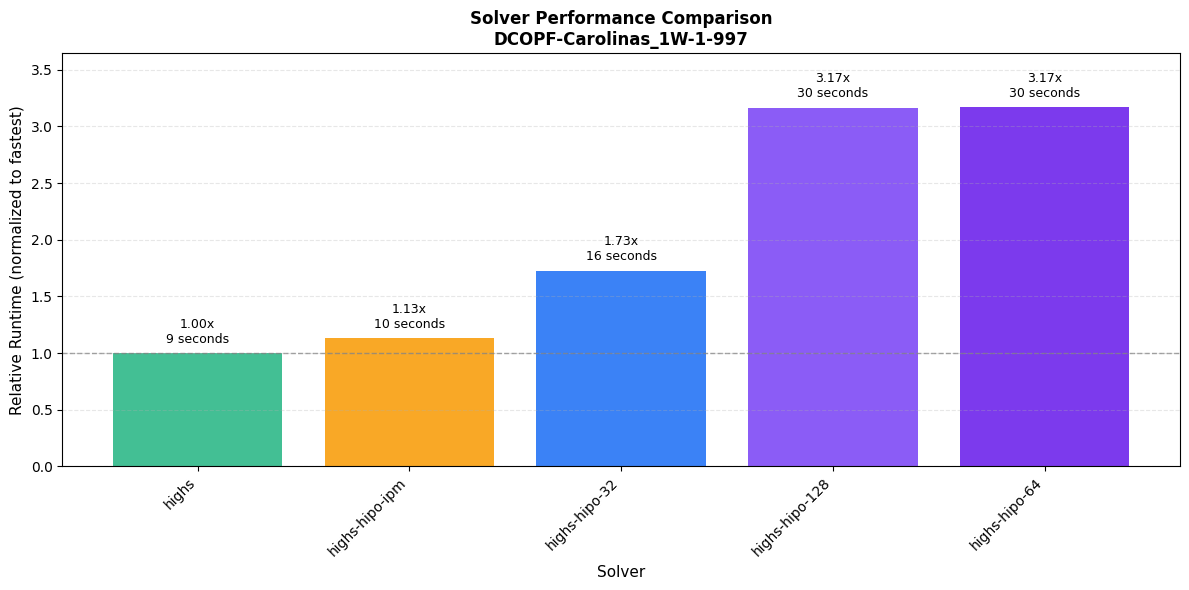


Benchmark: DCOPF-Carolinas_2M-1-997


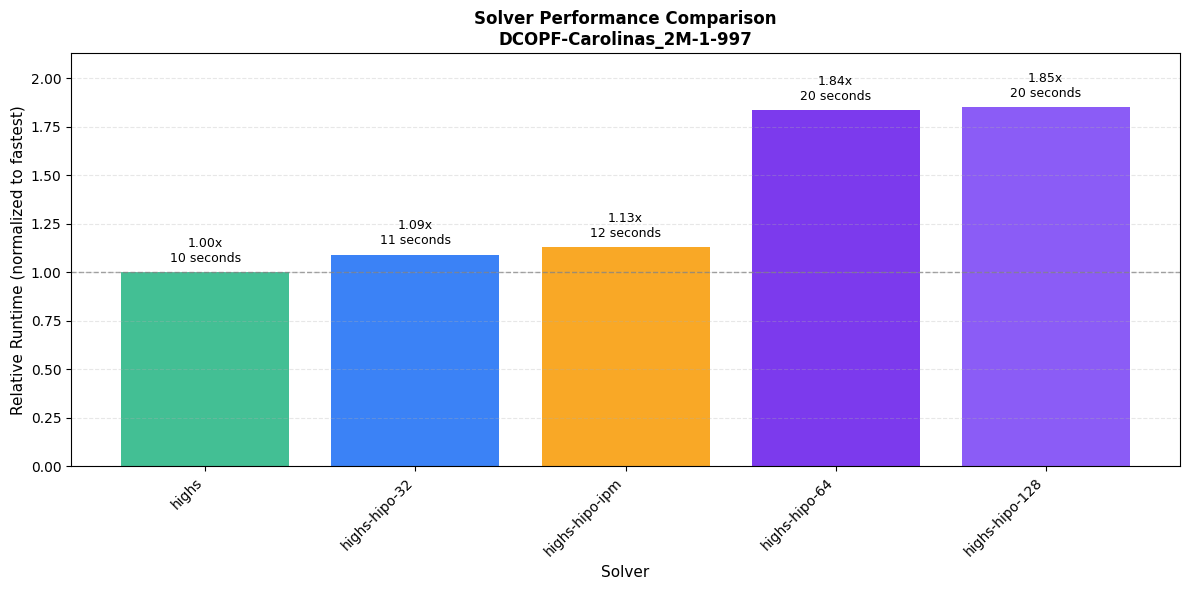


Benchmark: DCOPF-Carolinas_6M-1-997


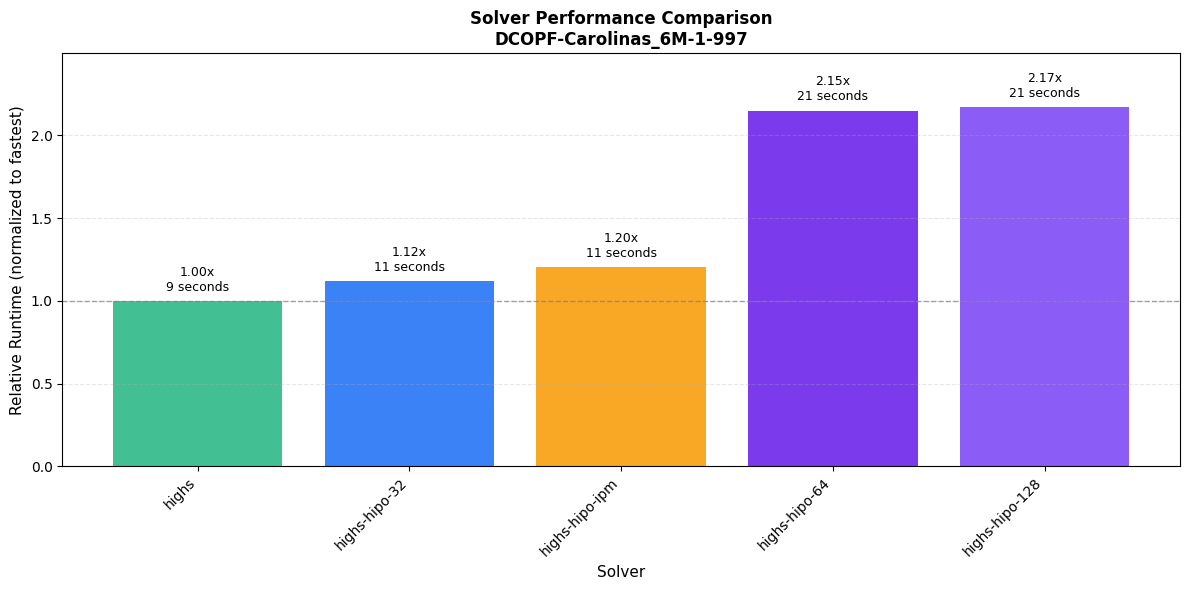


Benchmark: DCOPF-Carolinas_uc_1W-1-997


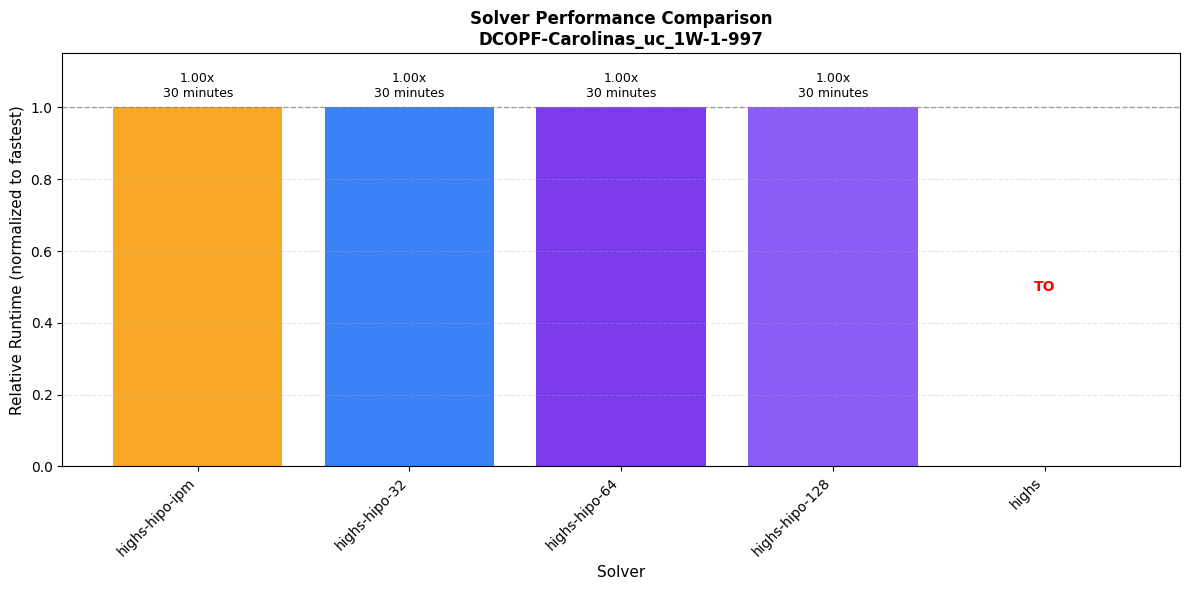


Benchmark: DCOPF-Carolinas_uc_2M-1-997


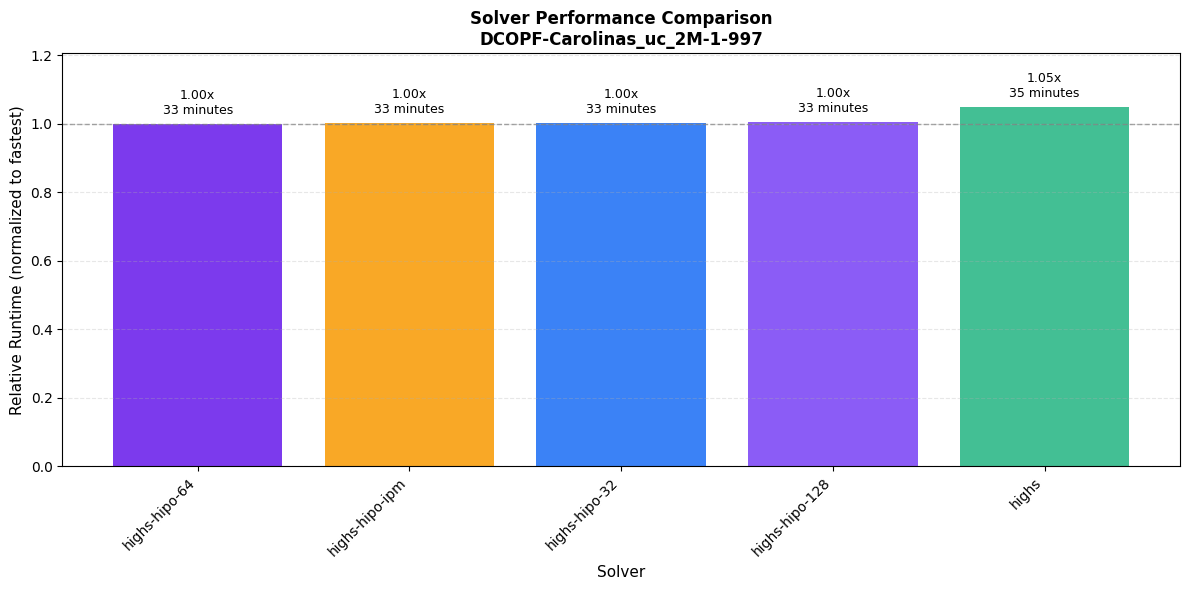


Benchmark: DCOPF-Carolinas_uc_6M-1-997
No successful runs for benchmark: DCOPF-Carolinas_uc_6M-1-997

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon12_Day29-1-1h


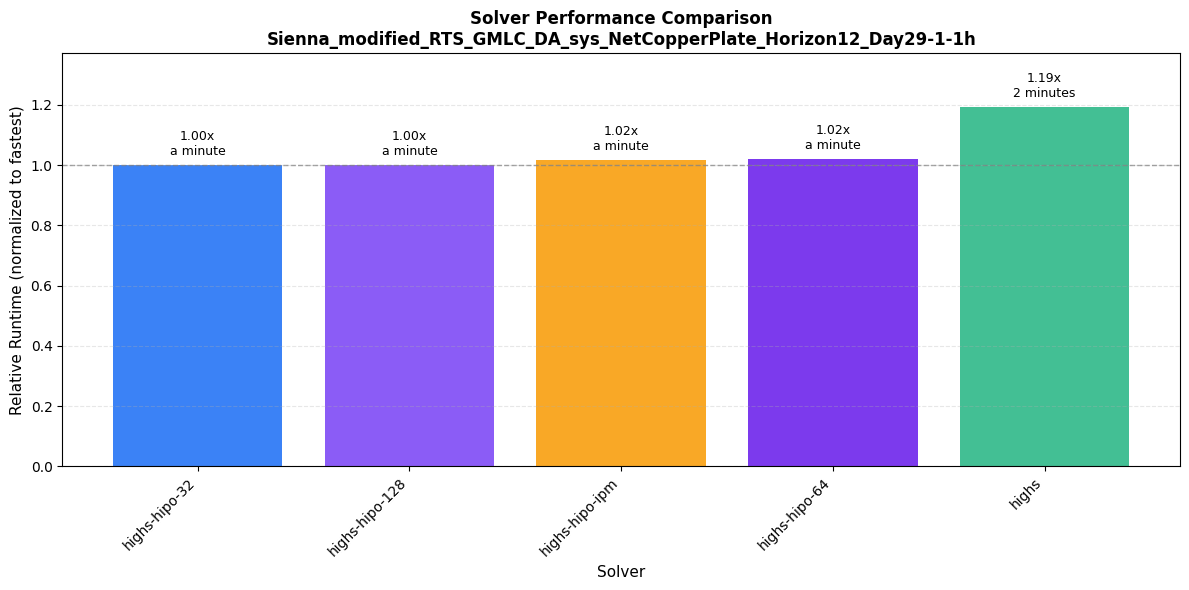


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon12_Day314-1-1h


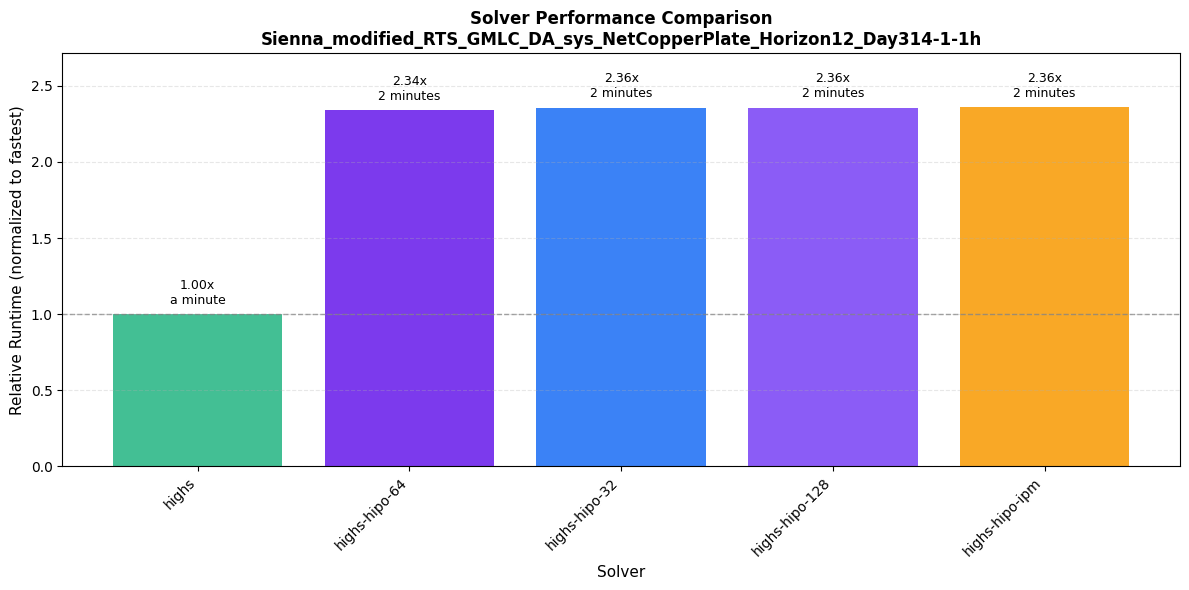


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon12_Day332-1-1h


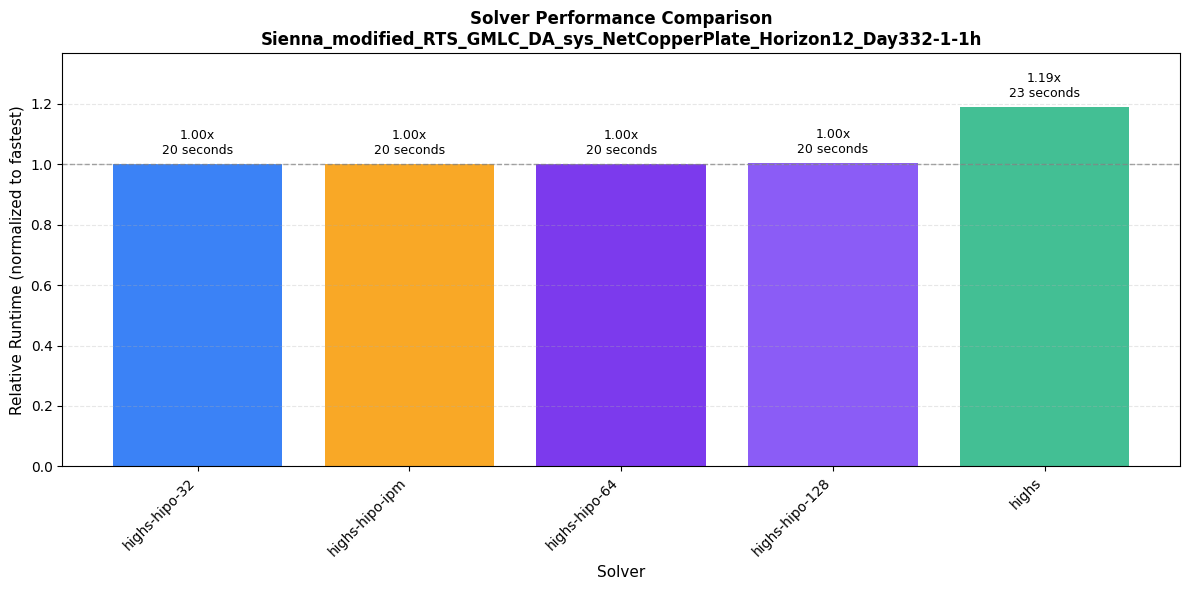


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon24_Day29-1-1h


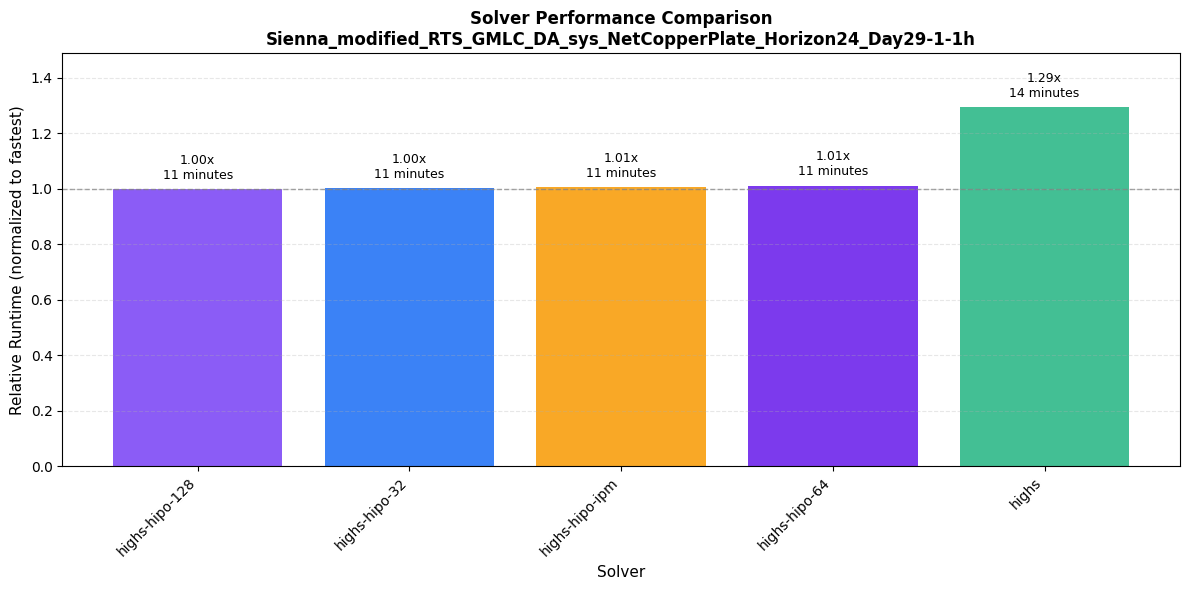


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon24_Day314-1-1h


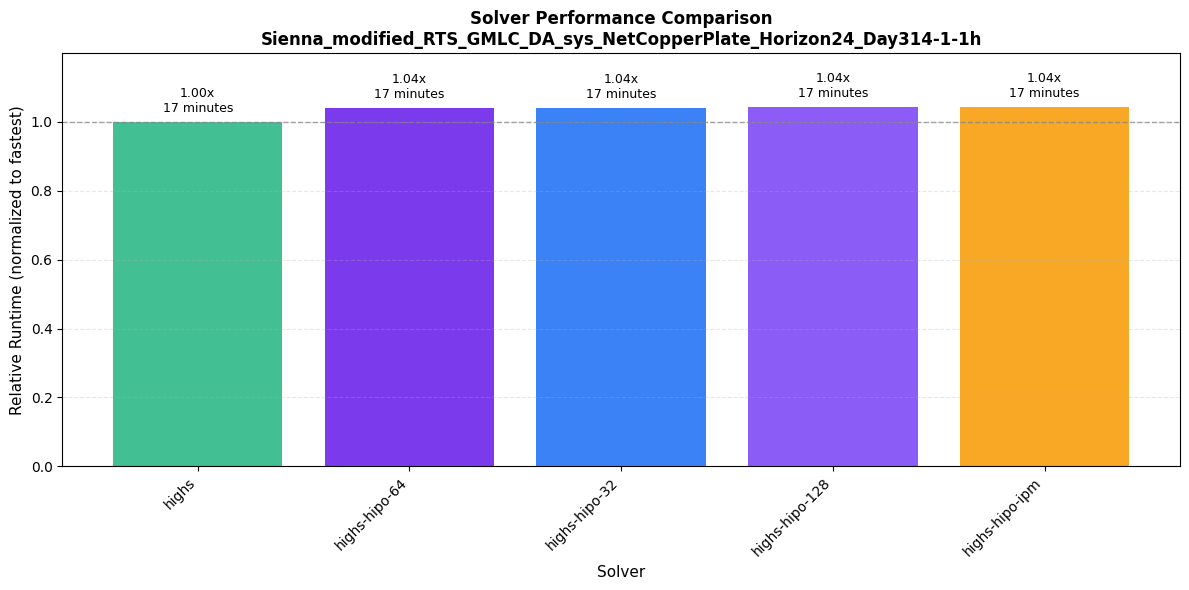


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon24_Day332-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon24_Day332-1-1h

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon48_Day29-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon48_Day29-1-1h

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon48_Day314-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate_Horizon48_Day314-1-1h

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon12_Day29-1-1h


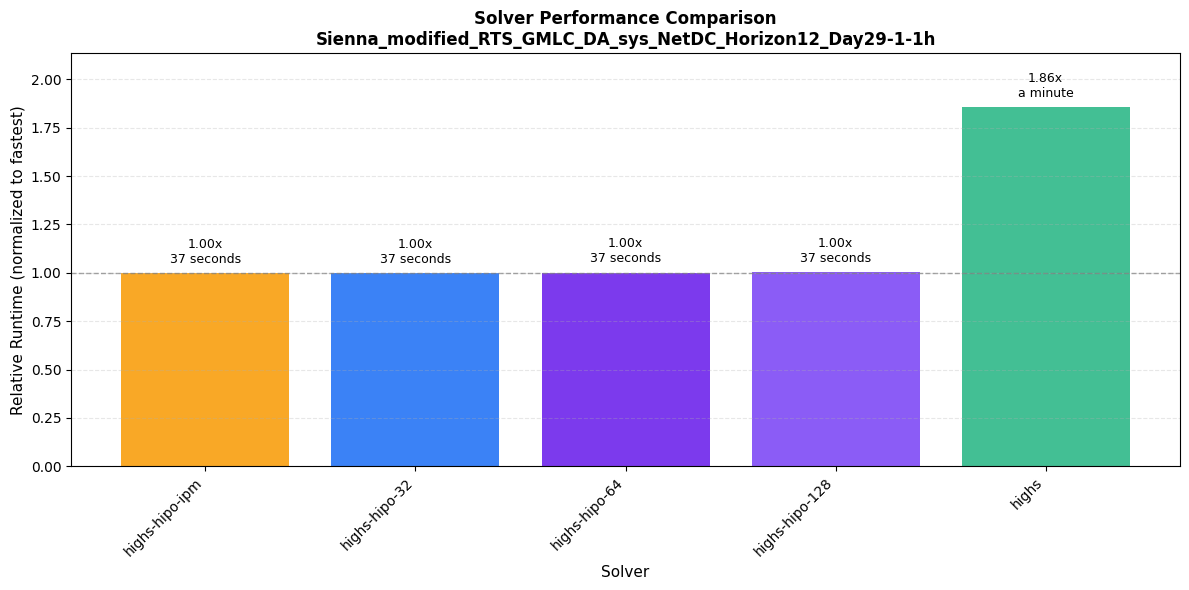


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon12_Day314-1-1h


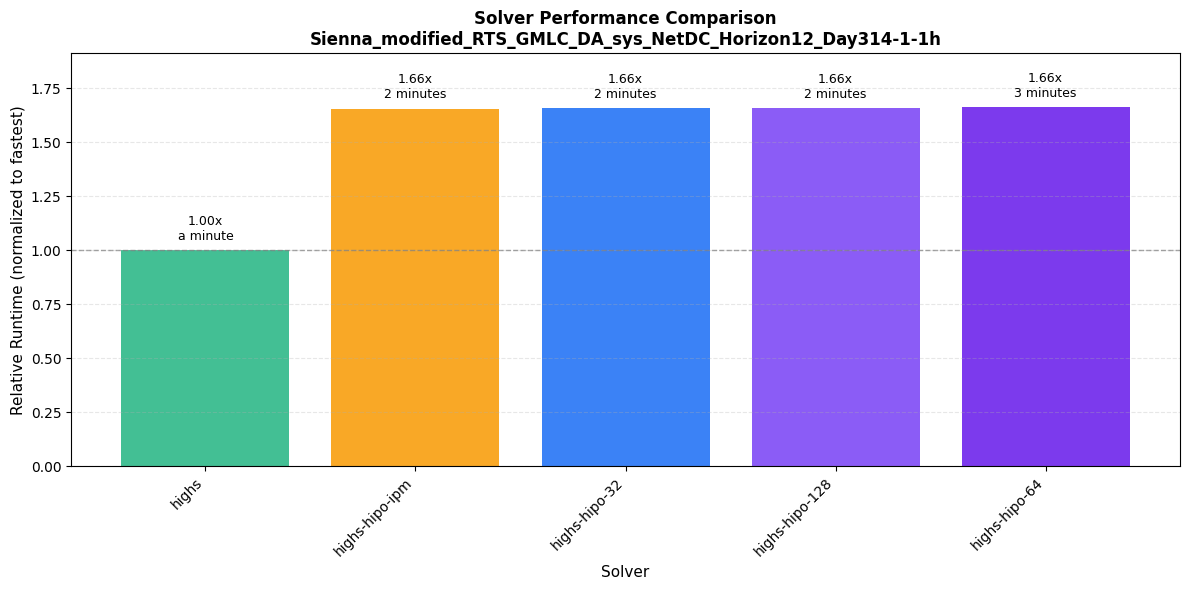


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon12_Day332-1-1h


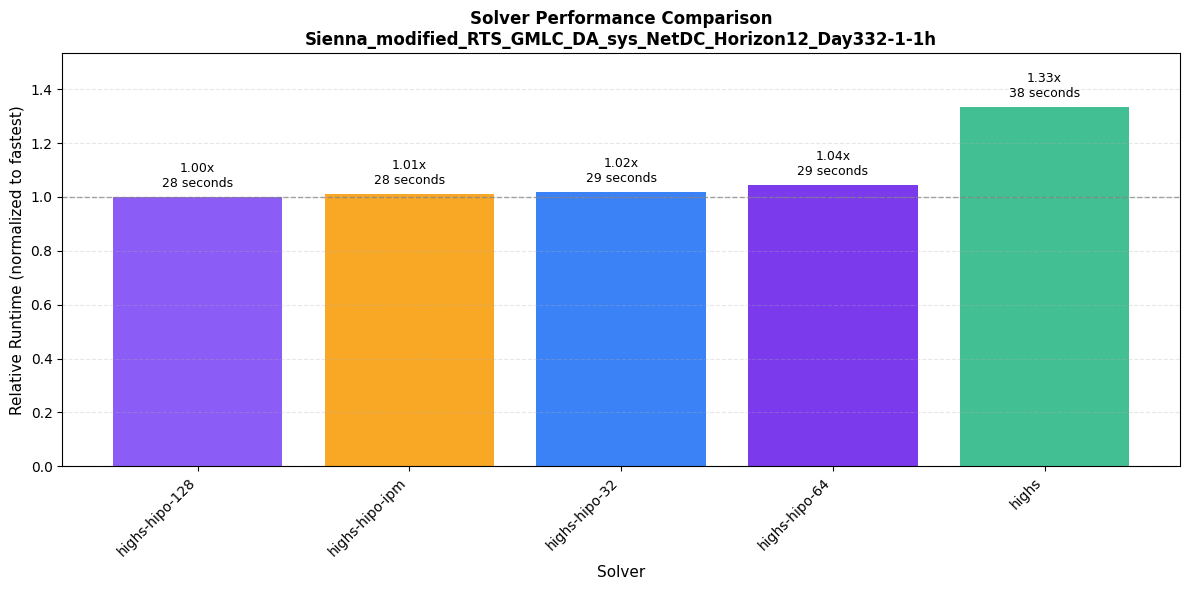


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon24_Day29-1-1h


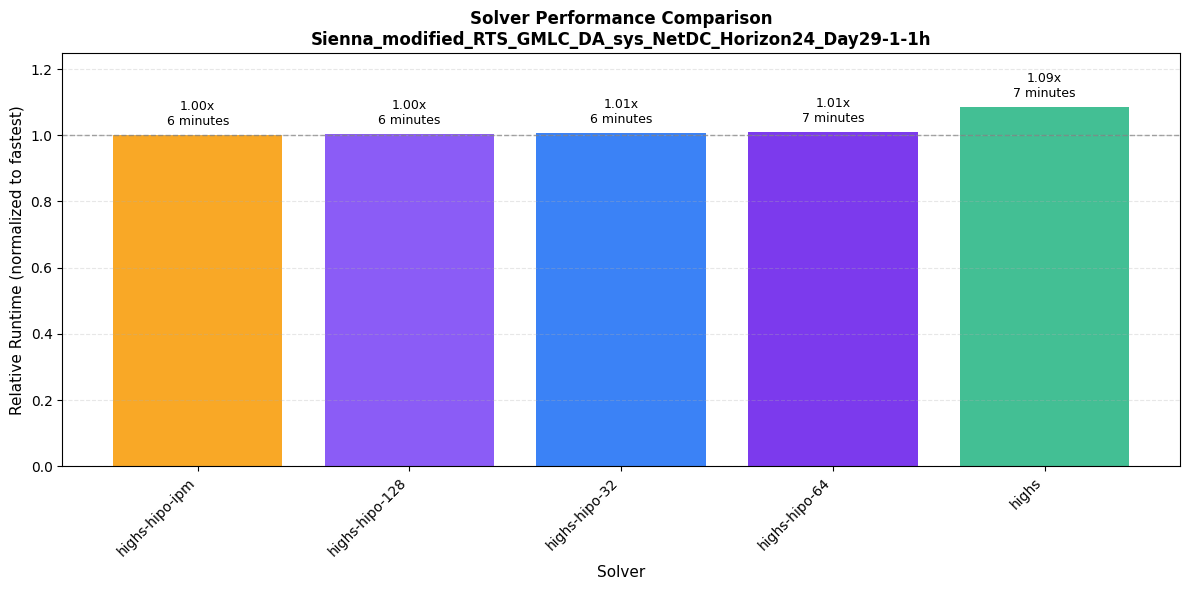


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon24_Day314-1-1h


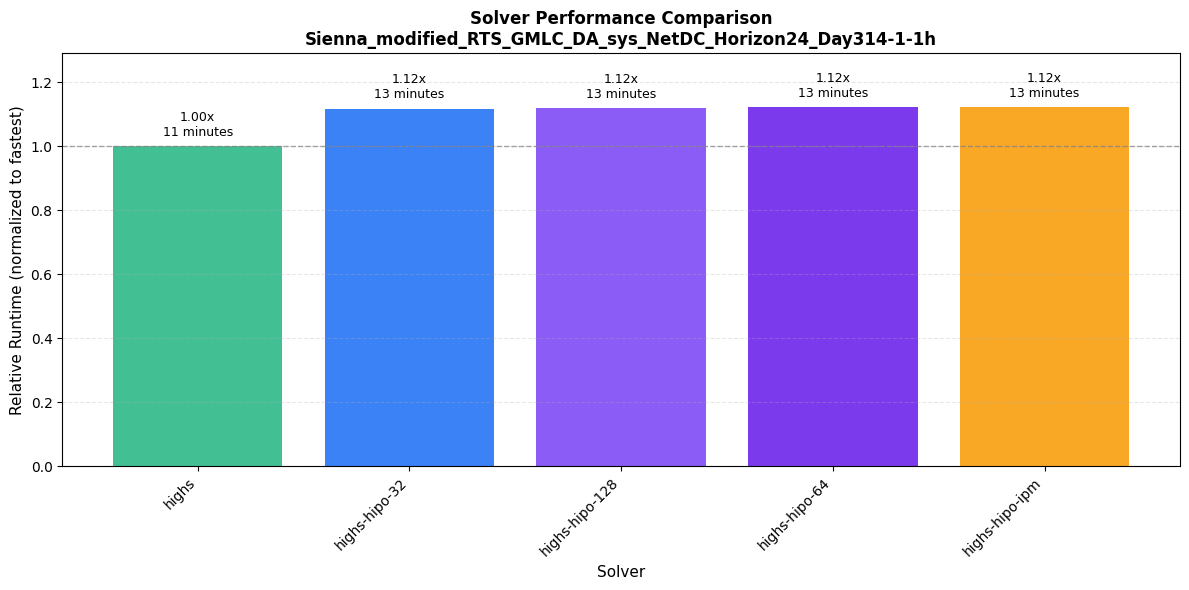


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon24_Day332-1-1h


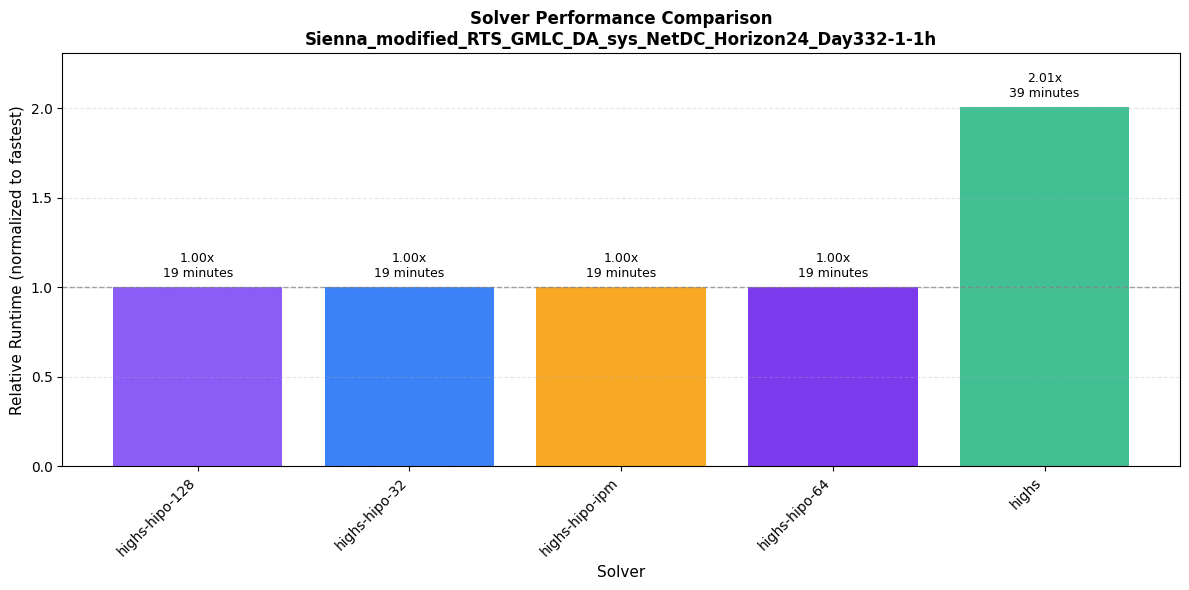


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon48_Day29-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon48_Day29-1-1h

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon48_Day314-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon48_Day314-1-1h

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon12_Day29-1-1h


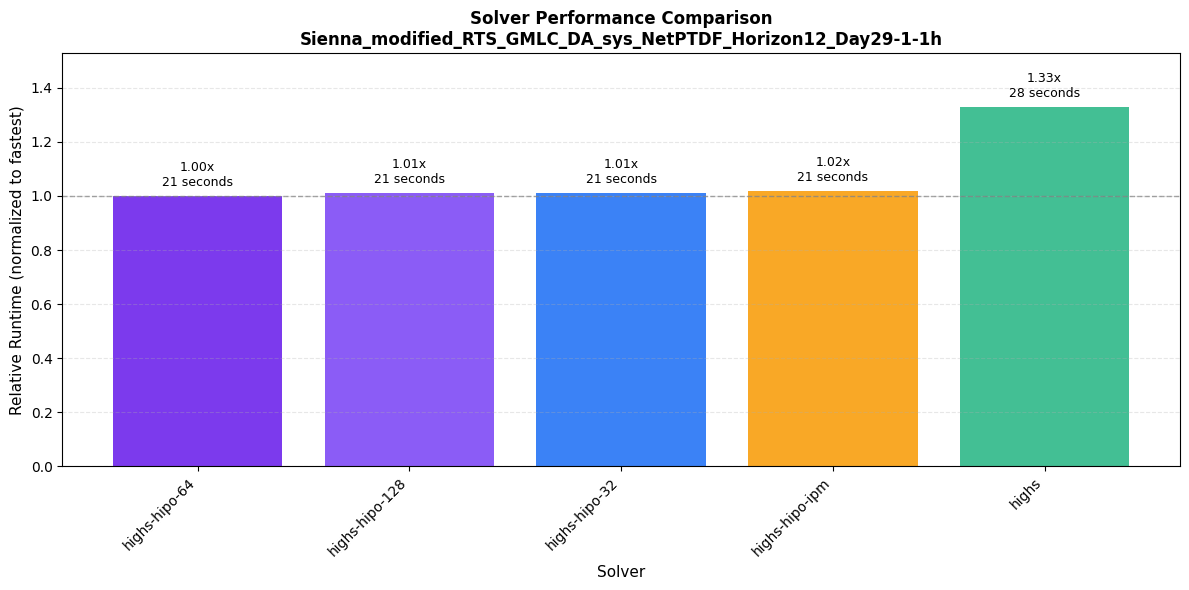


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon12_Day314-1-1h


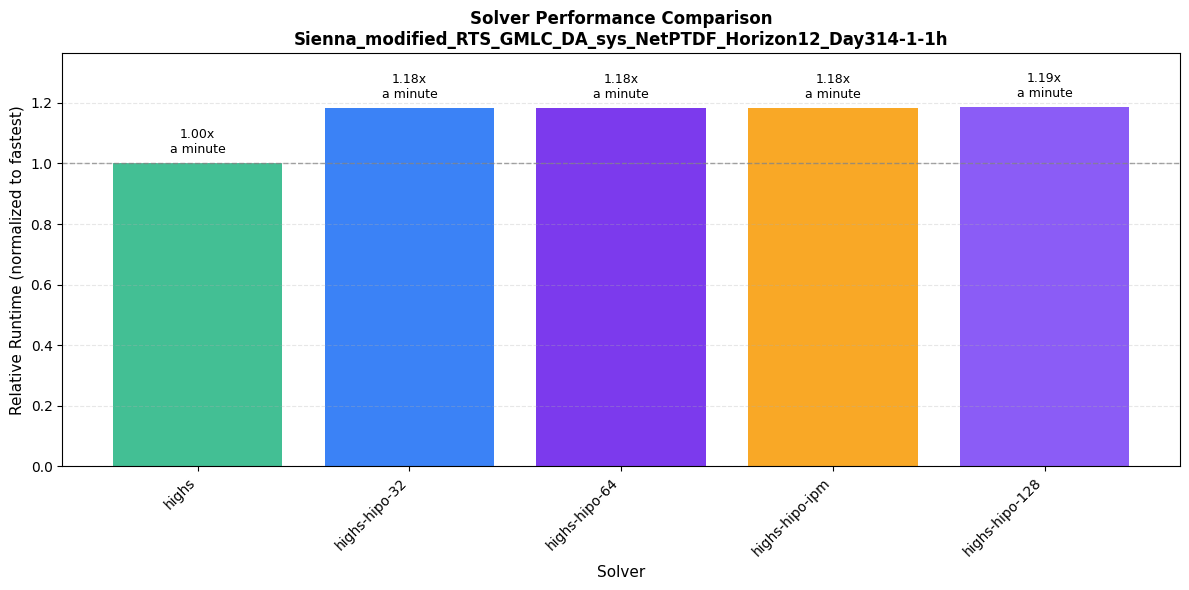


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon12_Day332-1-1h


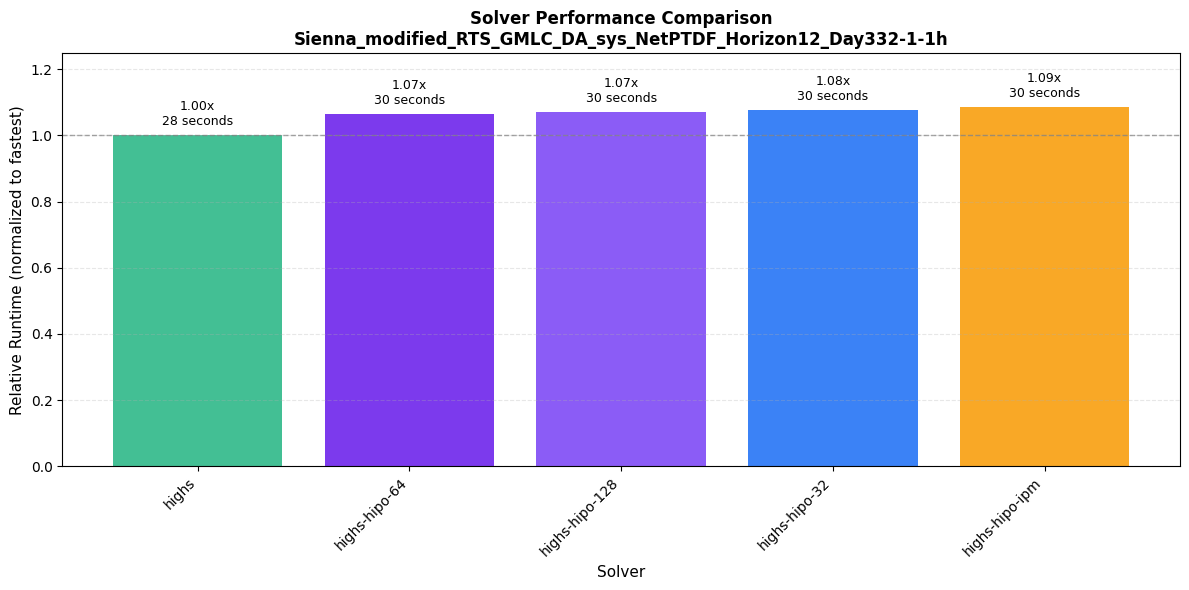


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon24_Day29-1-1h


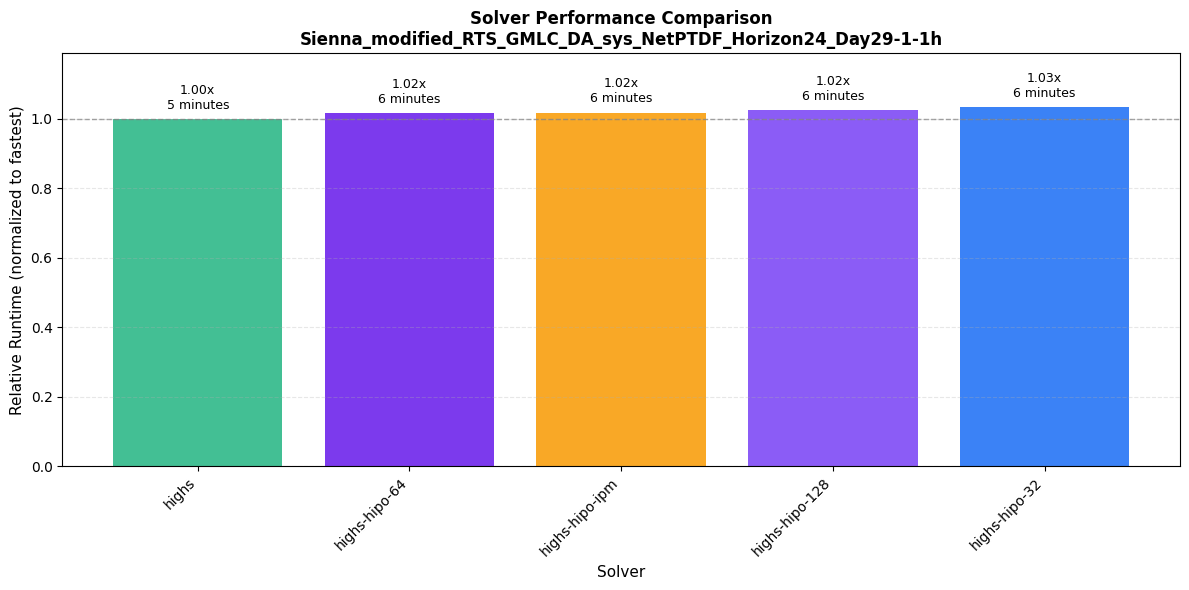


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon24_Day314-1-1h


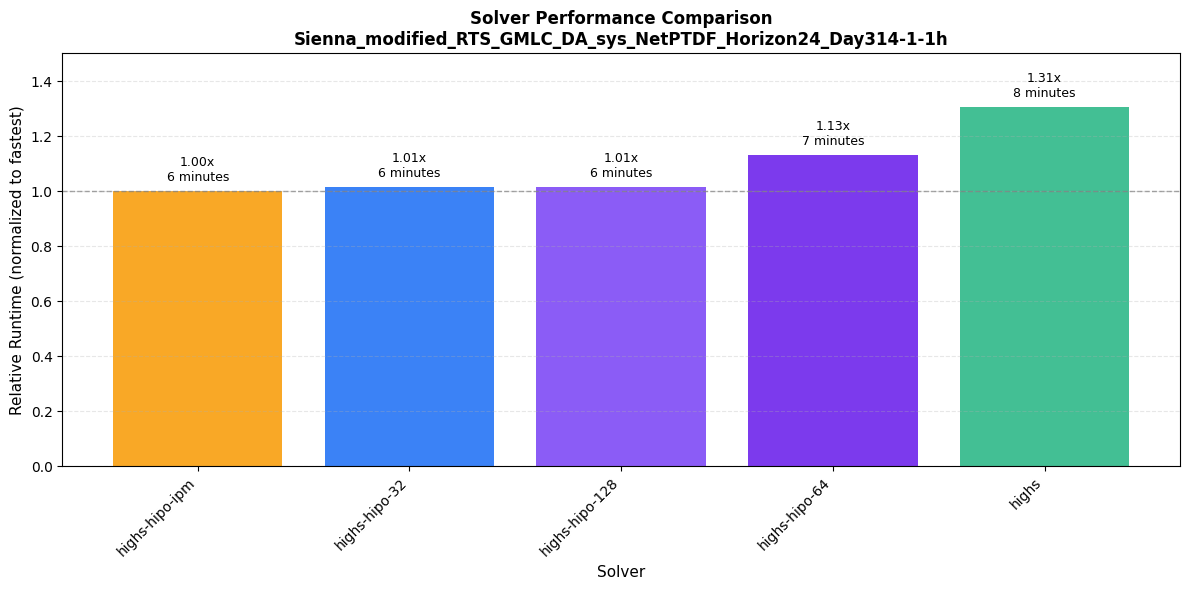


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon24_Day332-1-1h


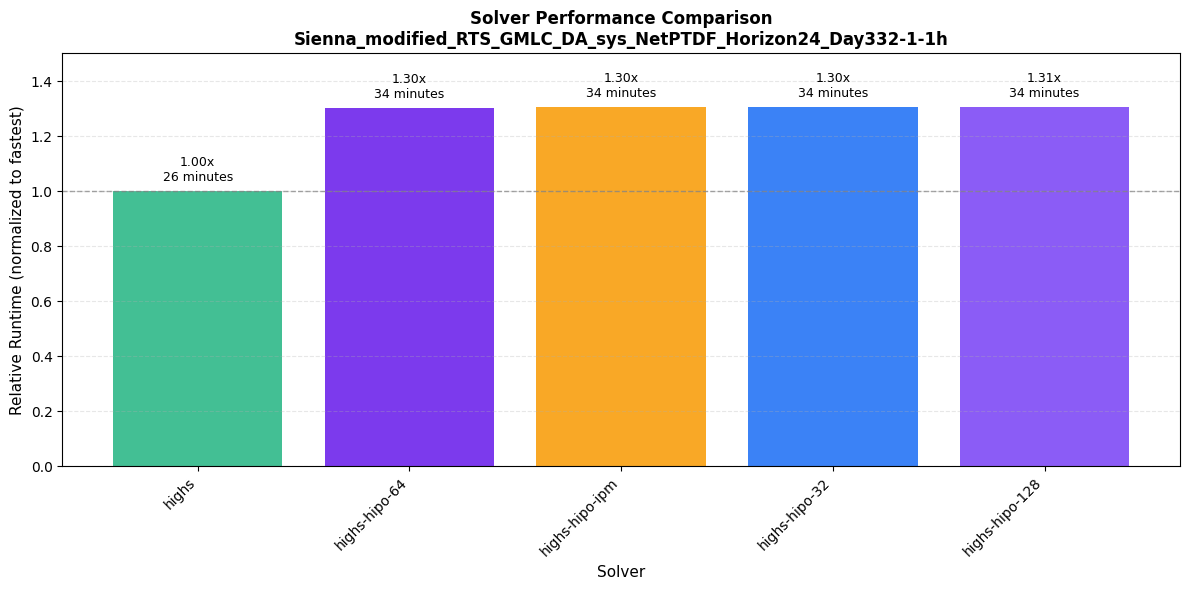


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon48_Day29-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon48_Day29-1-1h

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon48_Day314-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon48_Day314-1-1h

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon48_Day332-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizon48_Day332-1-1h

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon12_Day29-1-1h


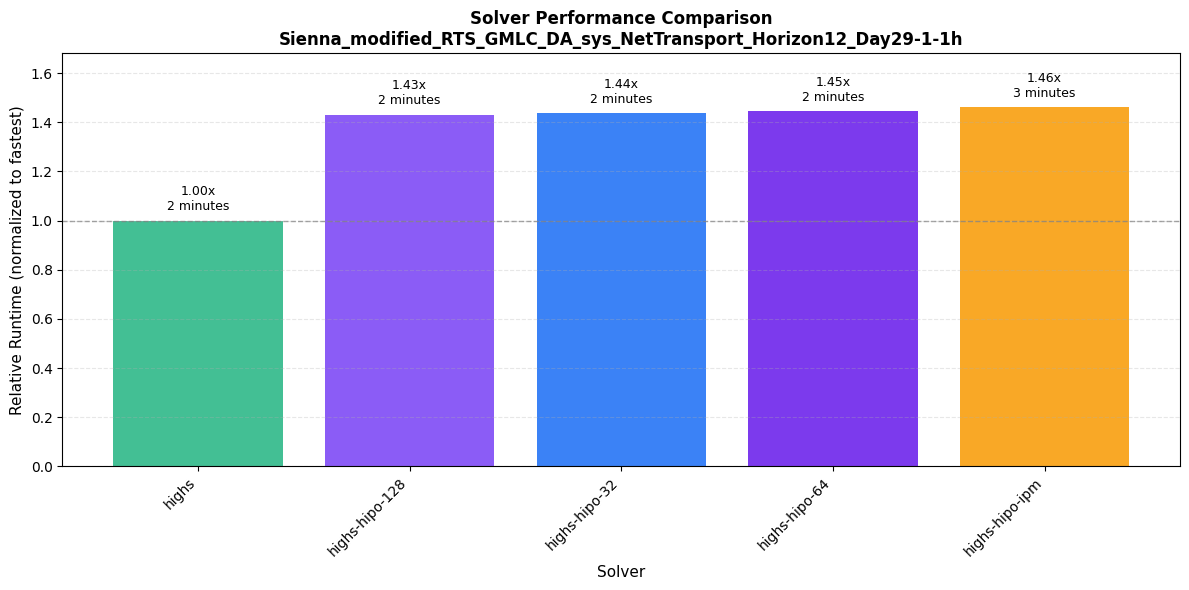


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon12_Day314-1-1h


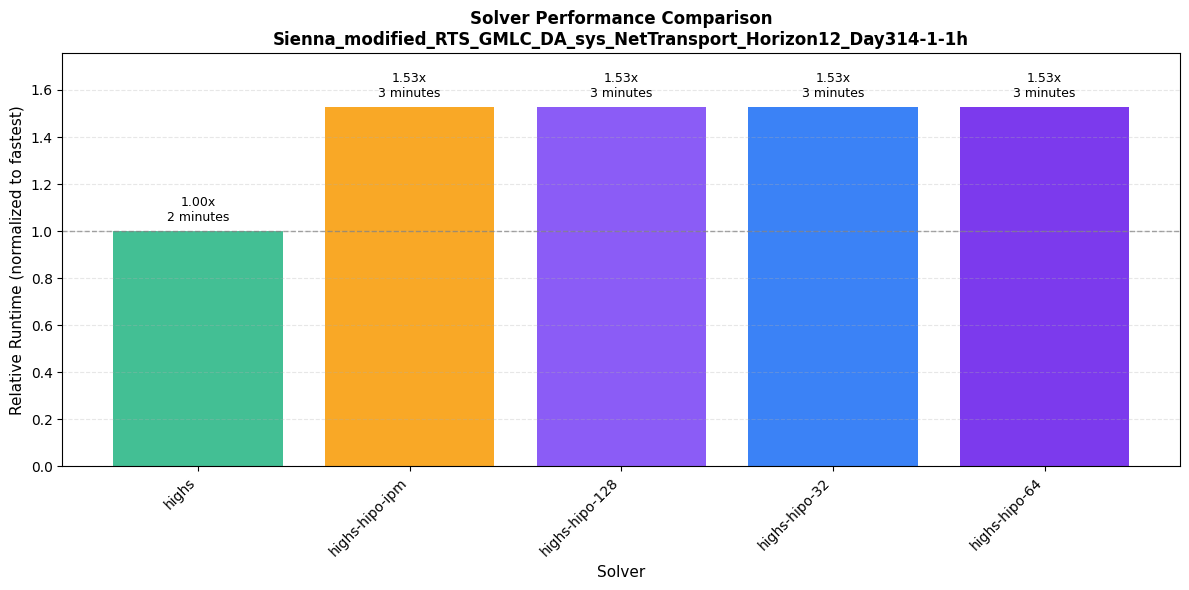


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon12_Day332-1-1h


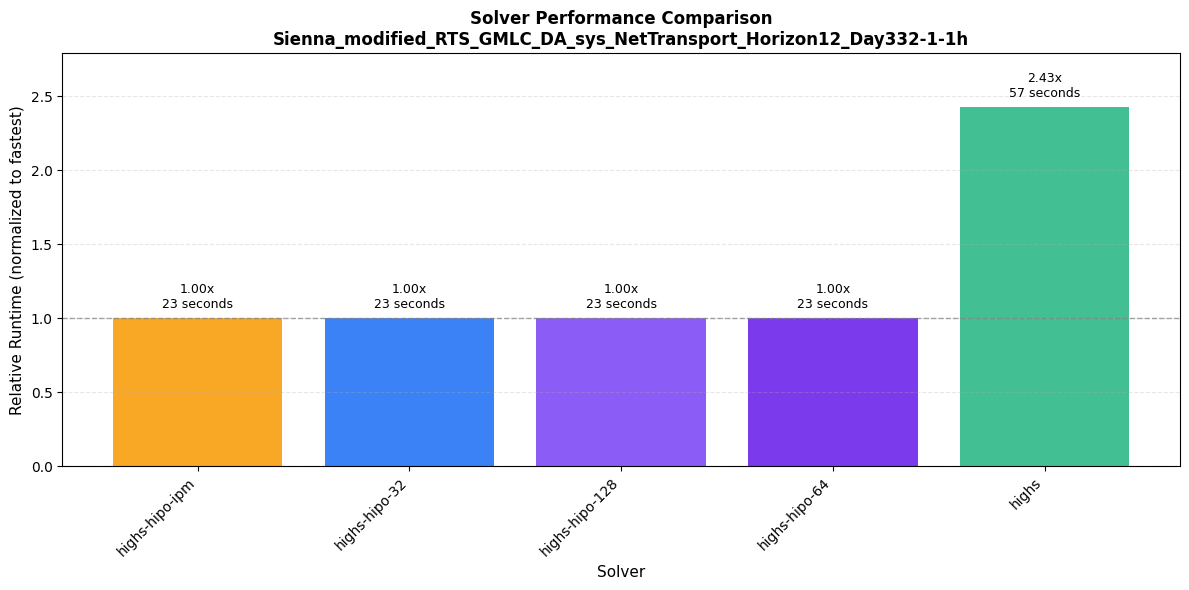


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon24_Day29-1-1h


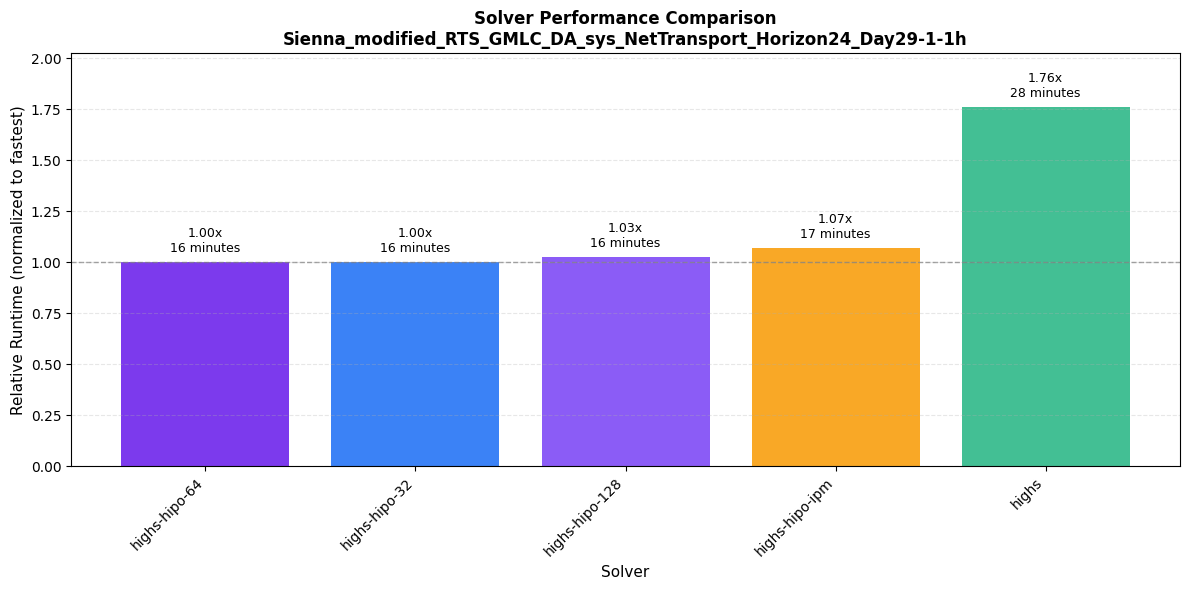


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon24_Day314-1-1h


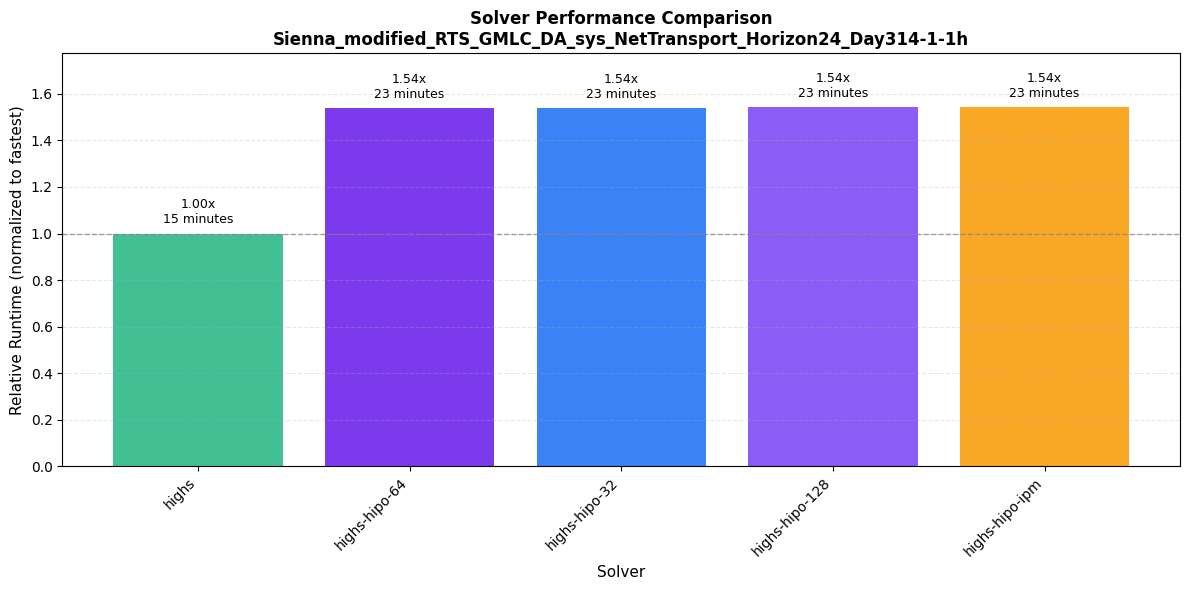


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon24_Day332-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon24_Day332-1-1h

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon48_Day314-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon48_Day314-1-1h

Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon48_Day332-1-1h
No successful runs for benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetTransport_Horizon48_Day332-1-1h

Benchmark: TIMES-GEO-global-base-31-20ts


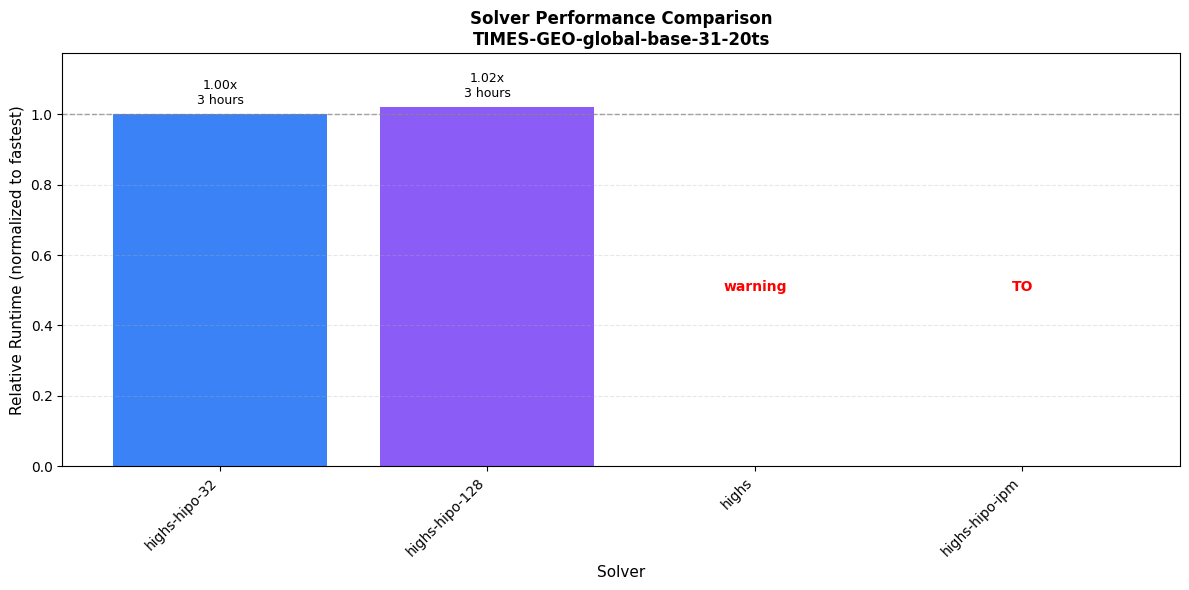


Benchmark: TIMES-GEO-global-netzero-31-20ts


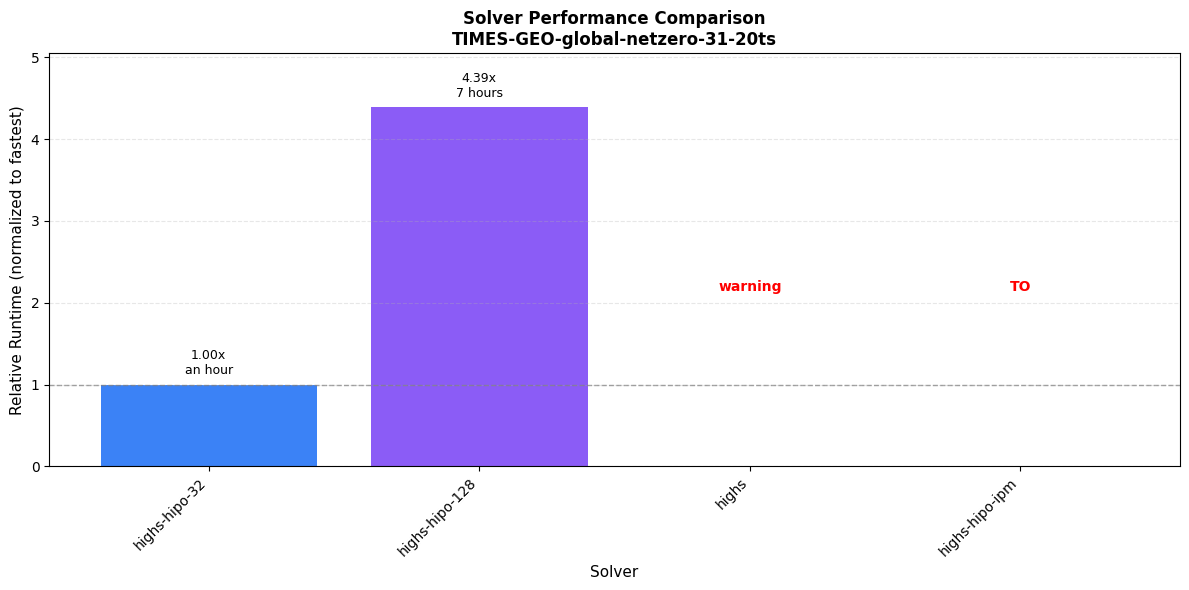


Benchmark: genx-10_IEEE_9_bus_DC_OPF-no_uc-9-1h


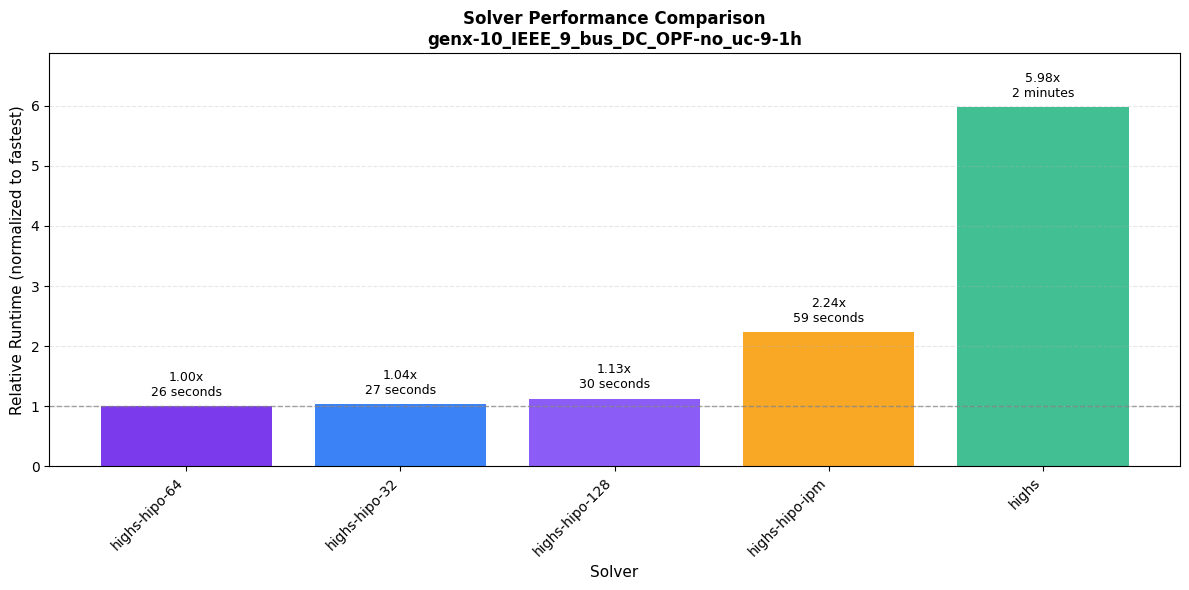


Benchmark: genx-1_three_zones-no_uc-3-1h


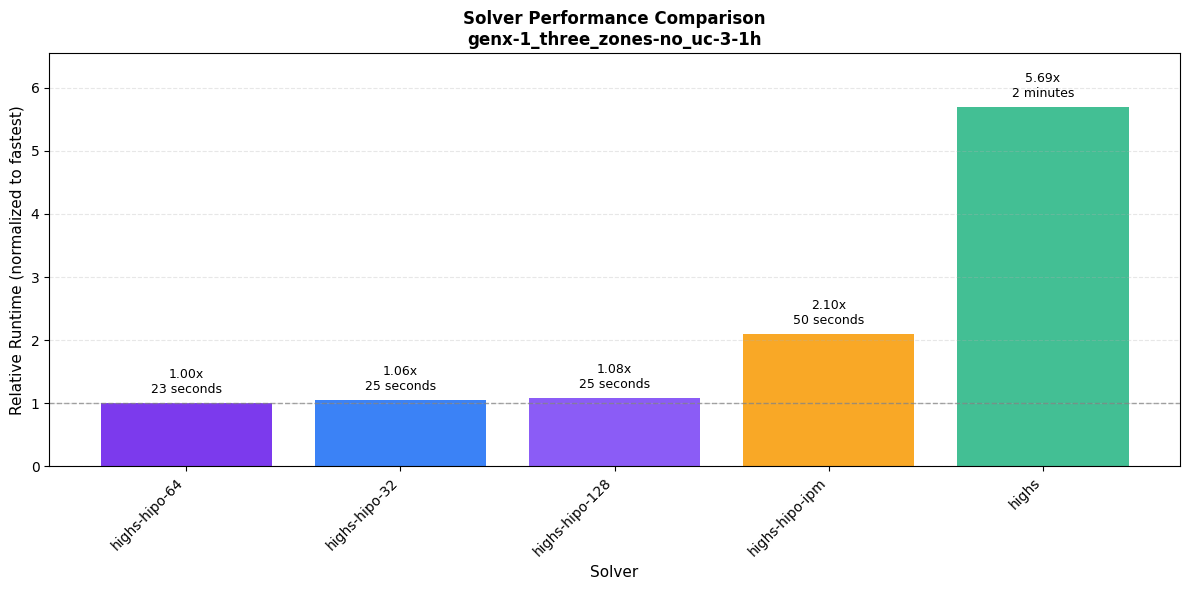


Benchmark: genx-2_three_zones_w_electrolyzer-3-1h


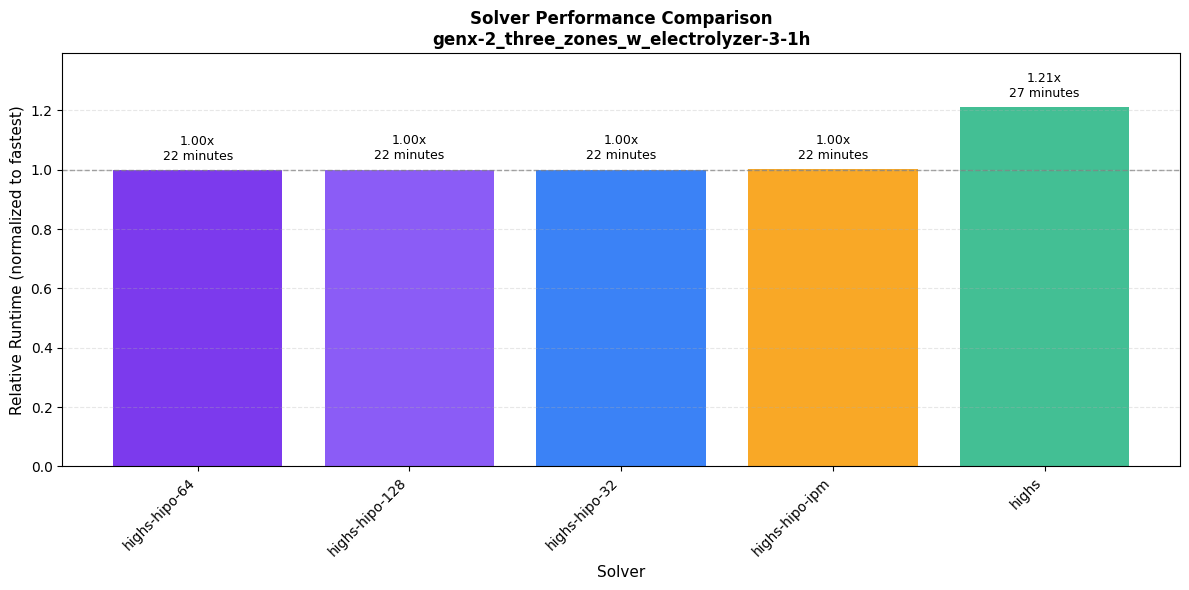


Benchmark: genx-2_three_zones_w_electrolyzer-no_uc-3-1h


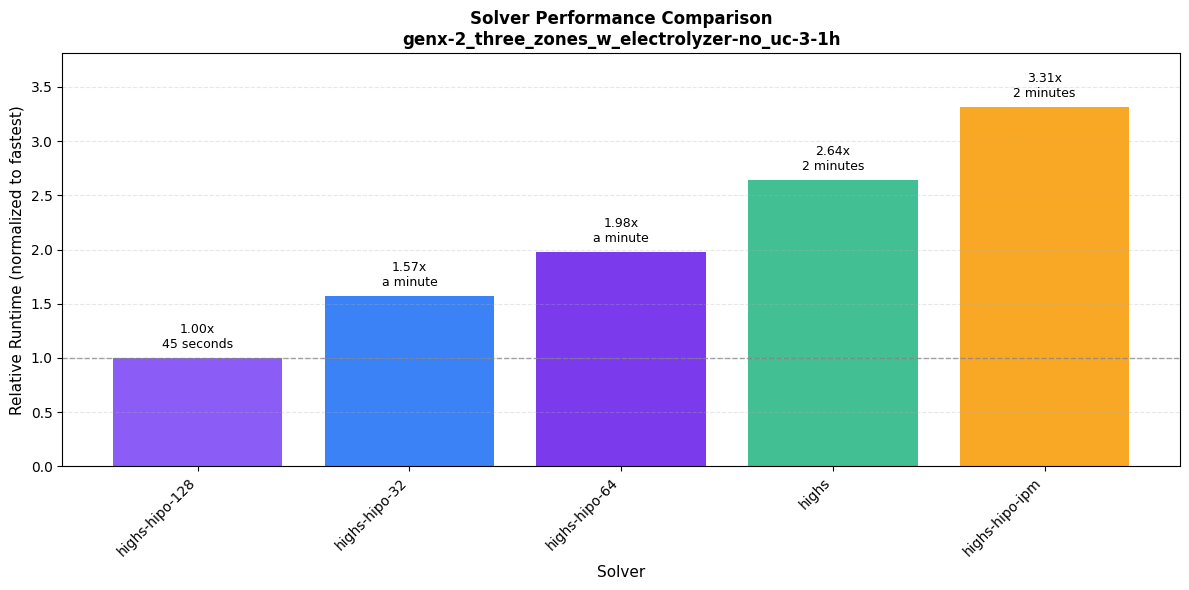


Benchmark: genx-3_three_zones_w_co2_capture-no_uc-3-1h


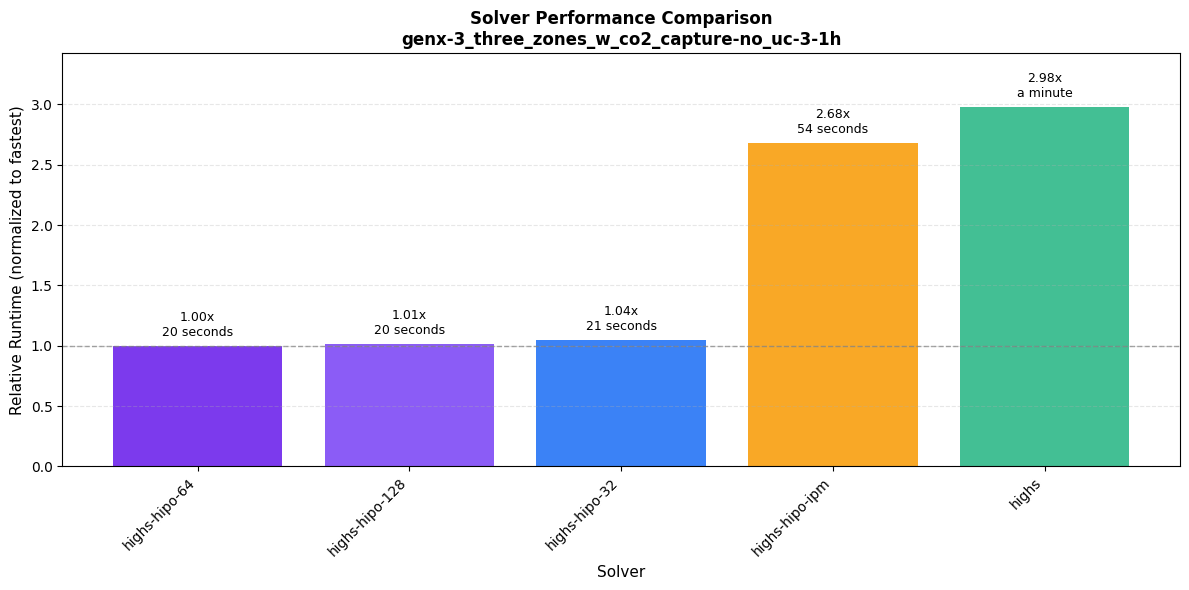


Benchmark: genx-4_three_zones_w_policies_slack-3-1h
No successful runs for benchmark: genx-4_three_zones_w_policies_slack-3-1h

Benchmark: genx-4_three_zones_w_policies_slack-no_uc-3-1h


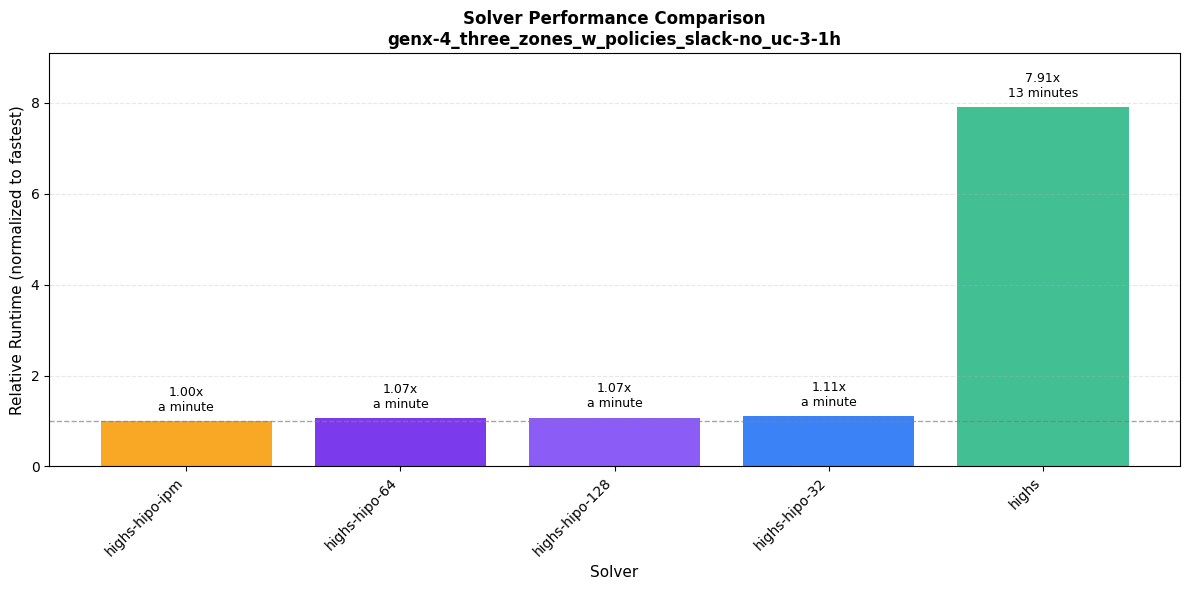


Benchmark: genx-6_three_zones_w_multistage-3-1h


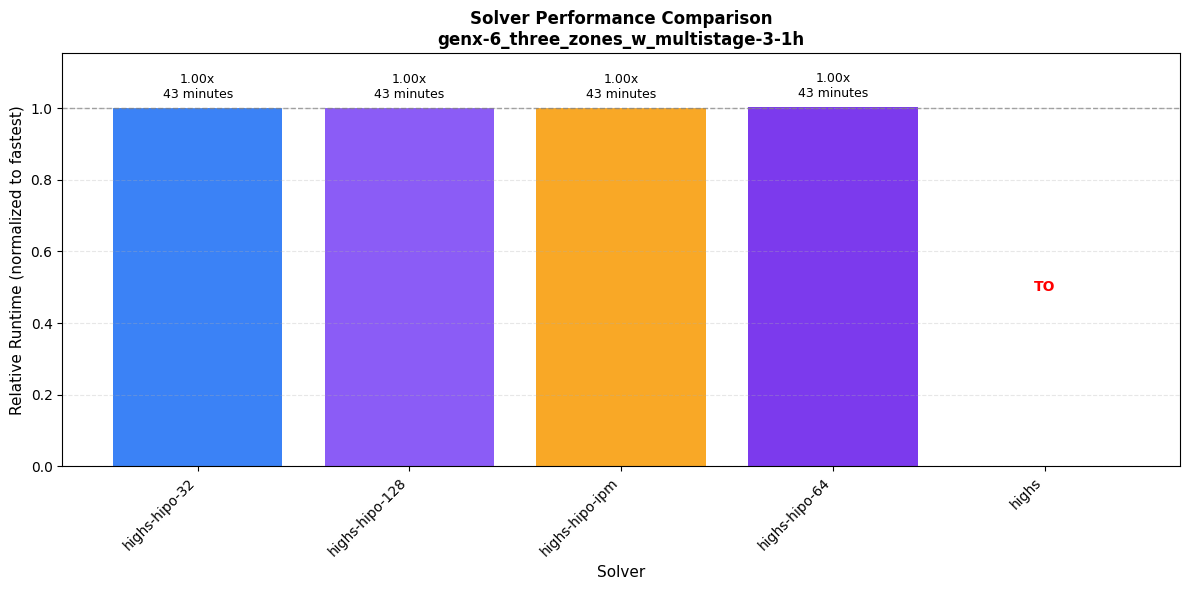


Benchmark: genx-6_three_zones_w_multistage-no_uc-3-1h


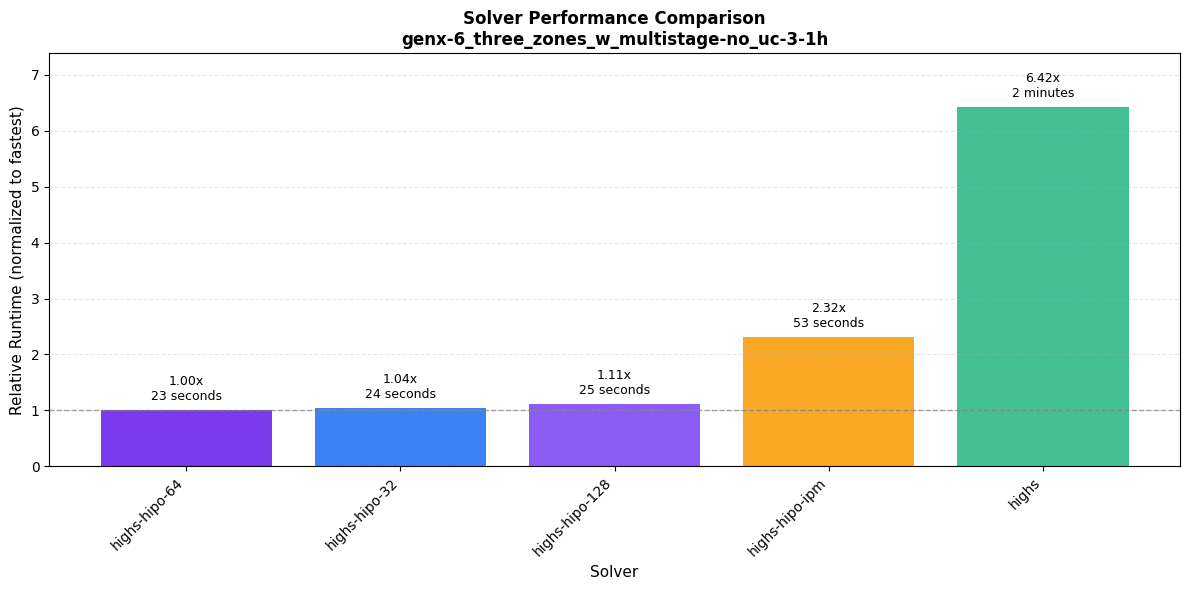


Benchmark: genx-7_three_zones_w_colocated_VRE_storage-3-24h


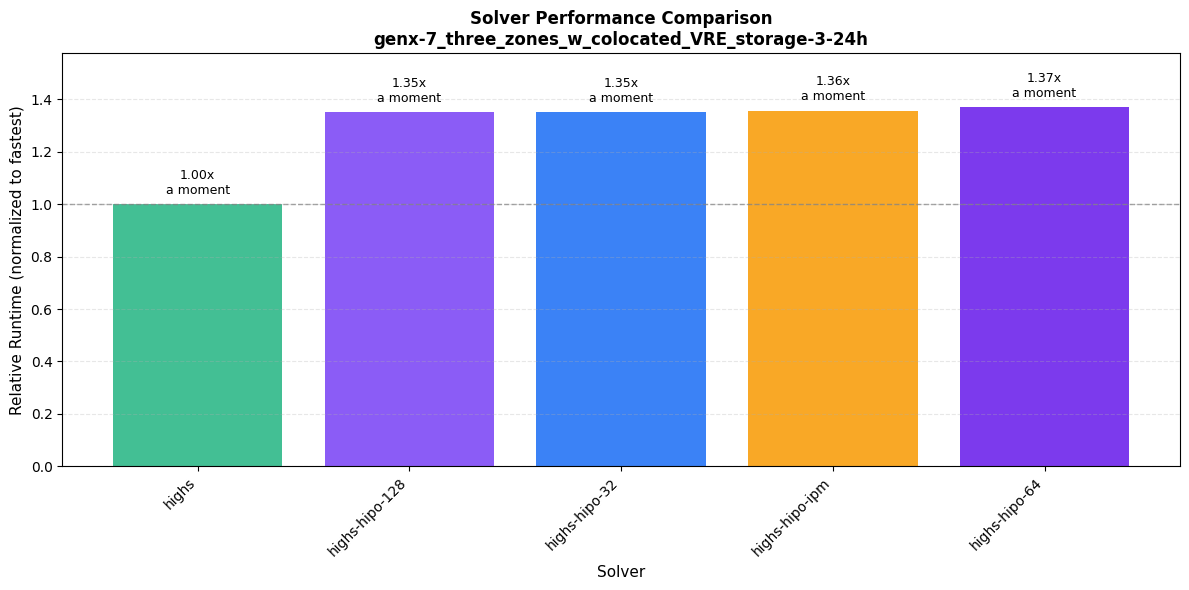


Benchmark: genx-8_three_zones_w_colocated_VRE_storage_electrolyzers-3-1h
No successful runs for benchmark: genx-8_three_zones_w_colocated_VRE_storage_electrolyzers-3-1h

Benchmark: genx-elec_trex-15-168h
No successful runs for benchmark: genx-elec_trex-15-168h

Benchmark: pglib_opf_case162_ieee_dtc-162-NA
No successful runs for benchmark: pglib_opf_case162_ieee_dtc-162-NA

Benchmark: pglib_opf_case1803_snem-1803-NA
No successful runs for benchmark: pglib_opf_case1803_snem-1803-NA

Benchmark: pglib_opf_case1951_rte-1951-NA
No successful runs for benchmark: pglib_opf_case1951_rte-1951-NA

Benchmark: pglib_opf_case2848-2848-NA


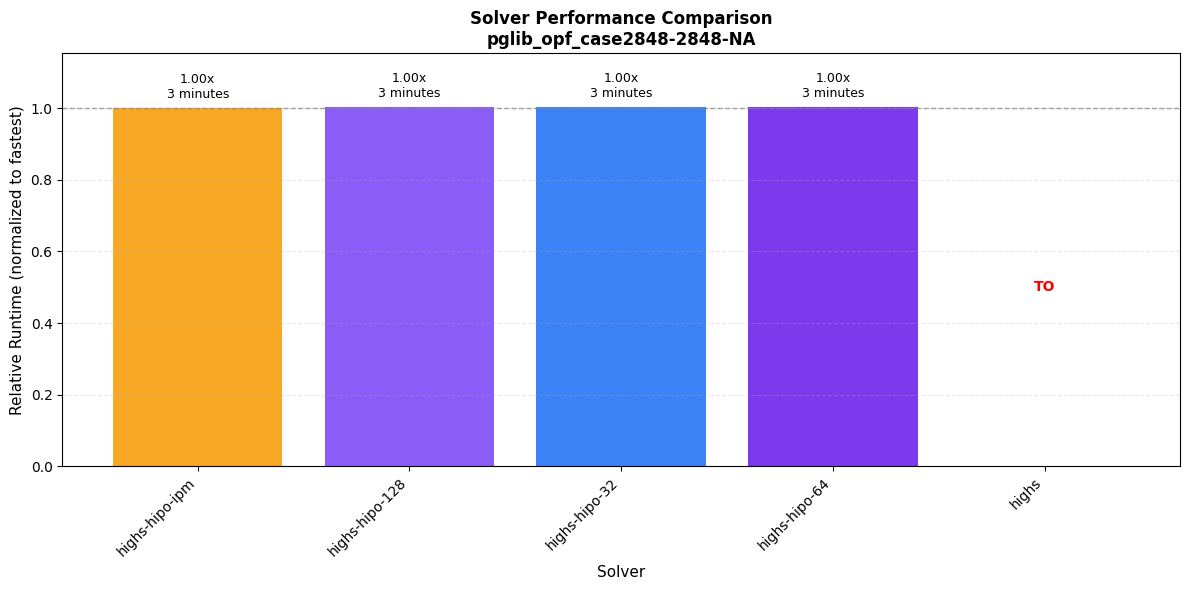


Benchmark: pglib_opf_case2868-2868-NA
No successful runs for benchmark: pglib_opf_case2868-2868-NA

Benchmark: pypsa-eur-elec-op-10-3h


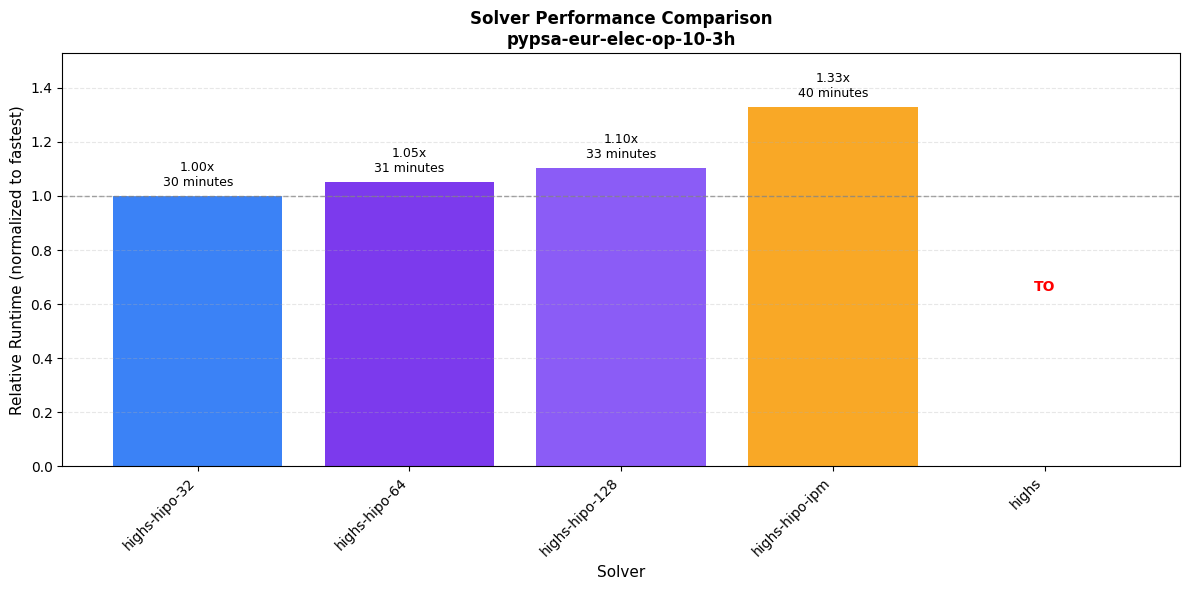


Benchmark: pypsa-eur-elec-op-2-1h


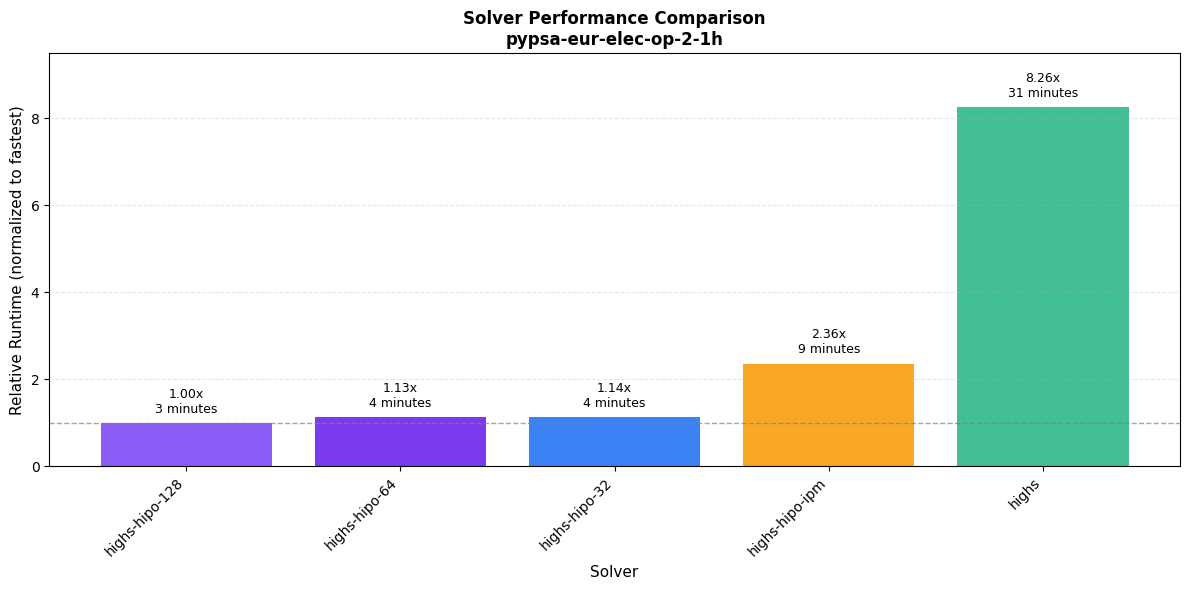


Benchmark: pypsa-eur-elec-op-4-3h


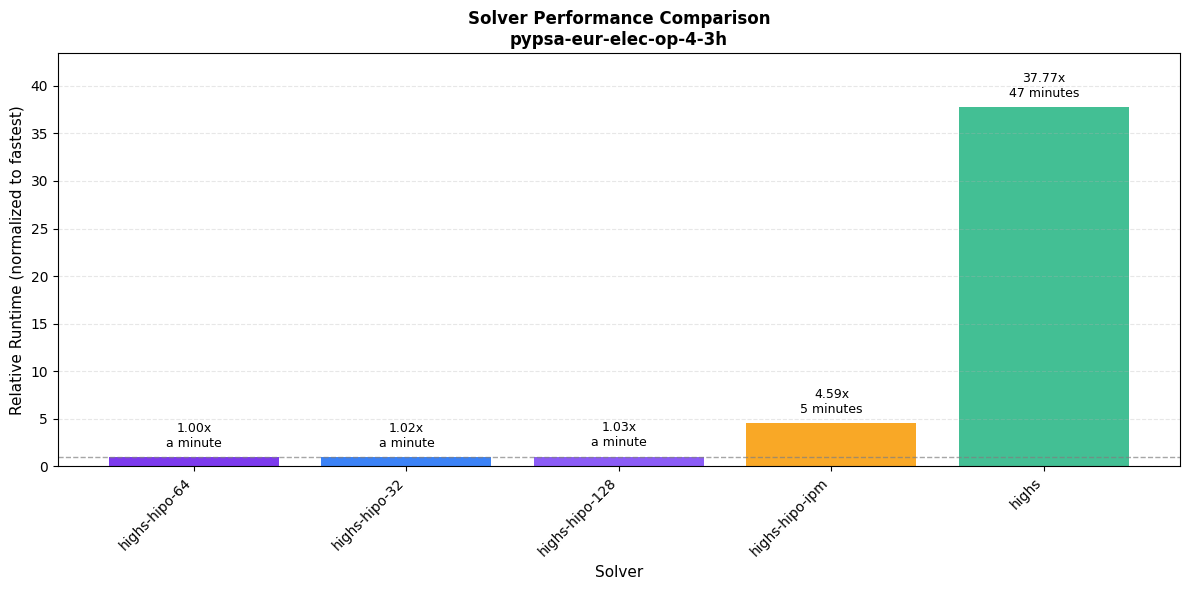


Benchmark: pypsa-eur-elec-op-6-24h


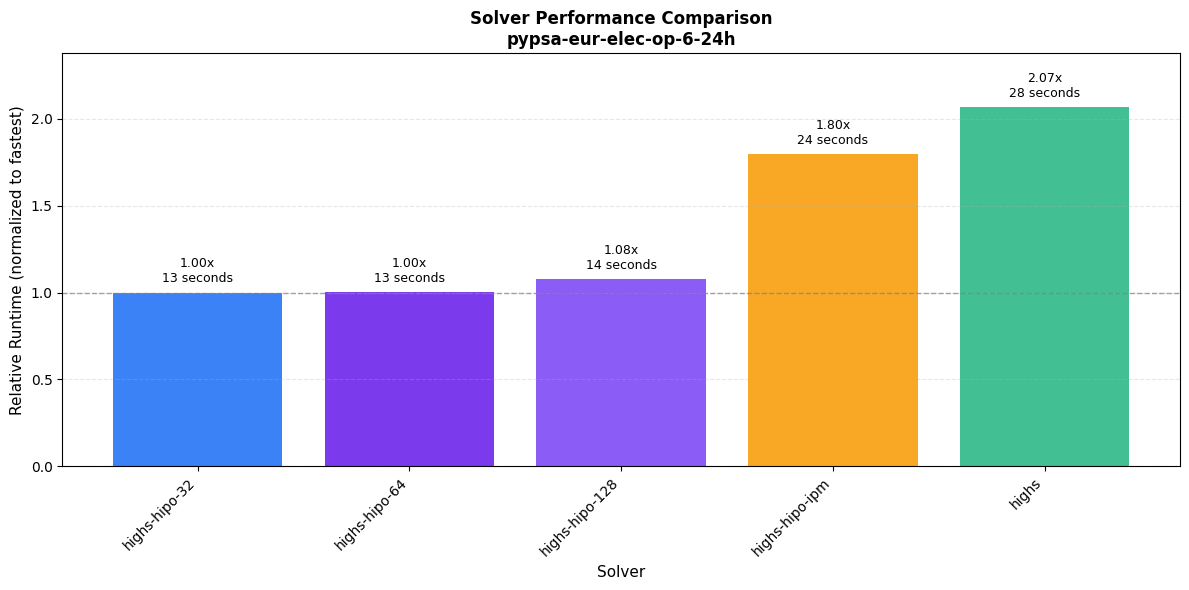


Benchmark: pypsa-eur-elec-op-8-12h


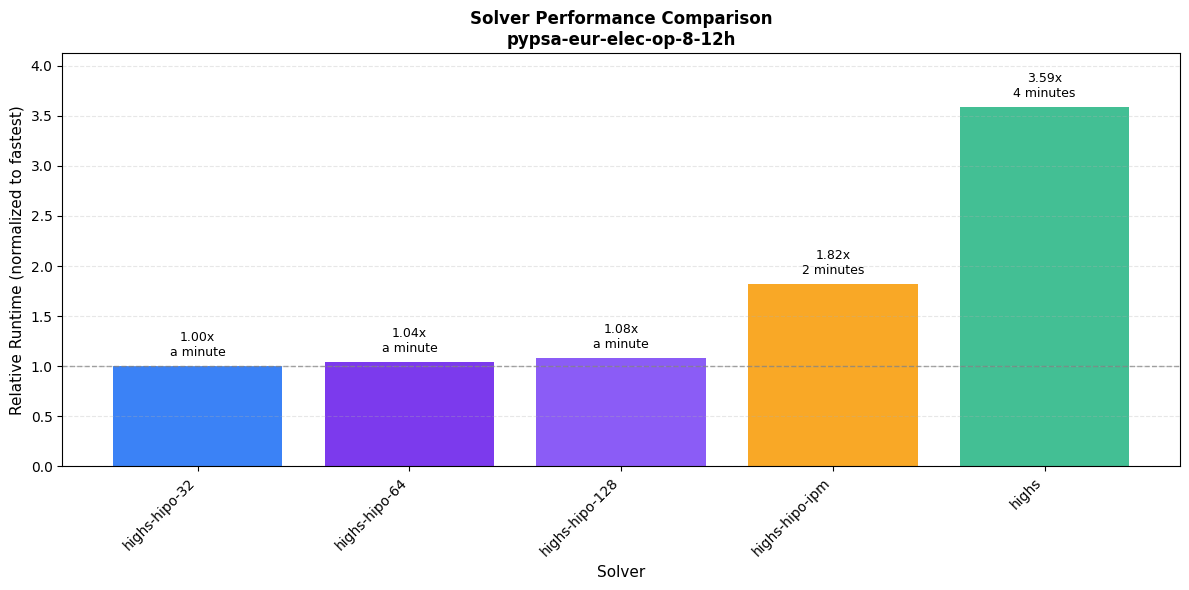


Benchmark: pypsa-eur-elec-op-ucconv-10-24h


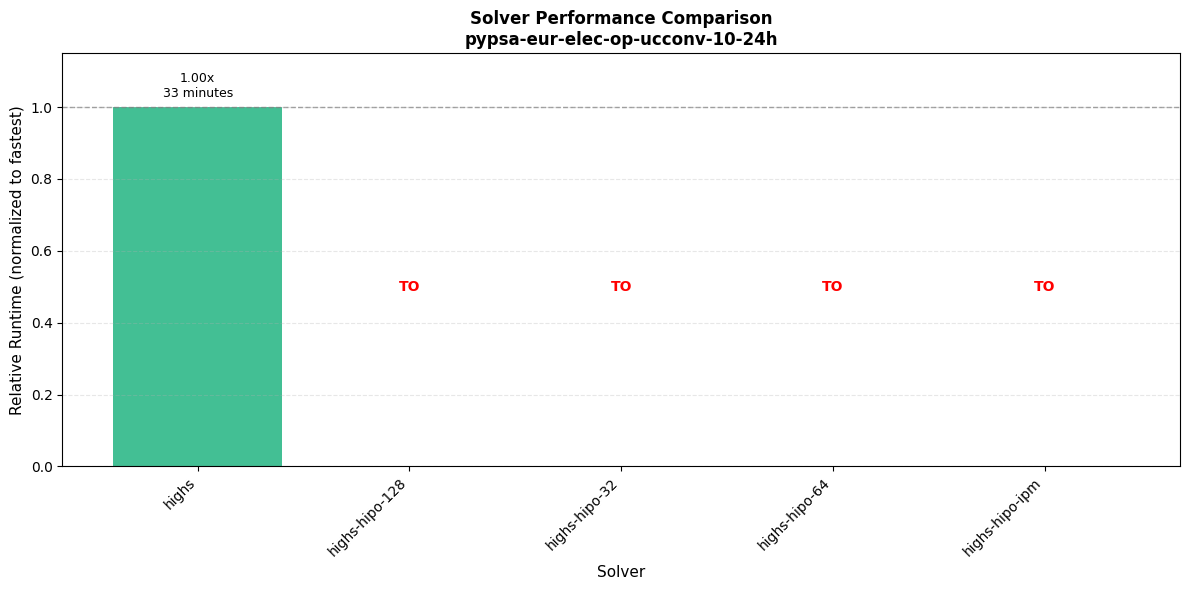


Benchmark: pypsa-eur-elec-op-ucconv-2-3h


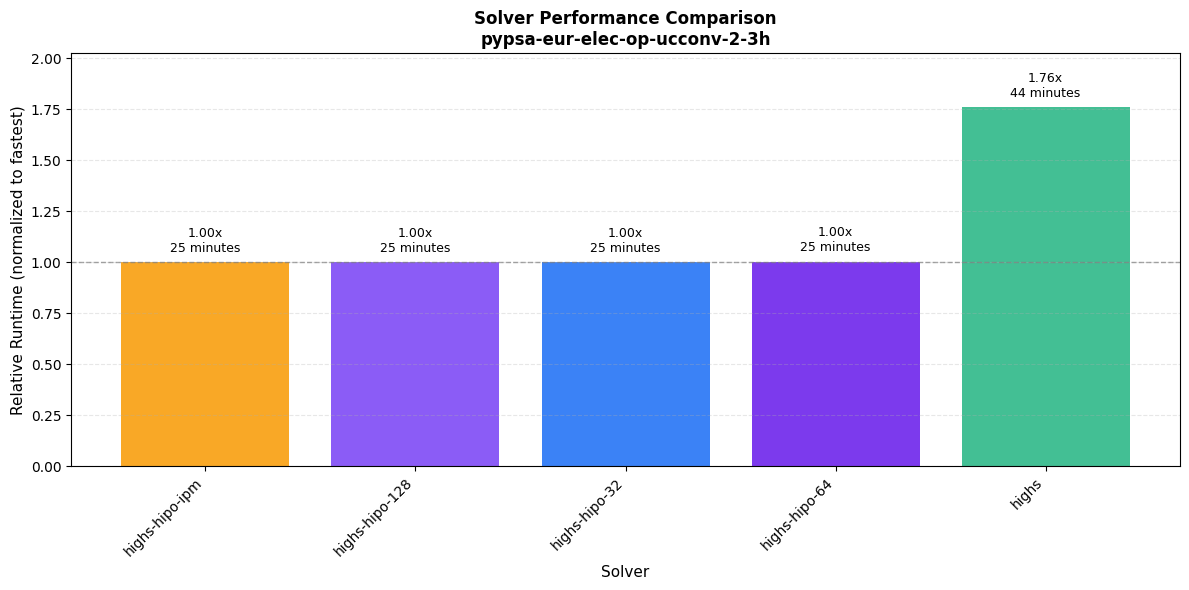


Benchmark: pypsa-eur-elec-op-ucconv-5-24h


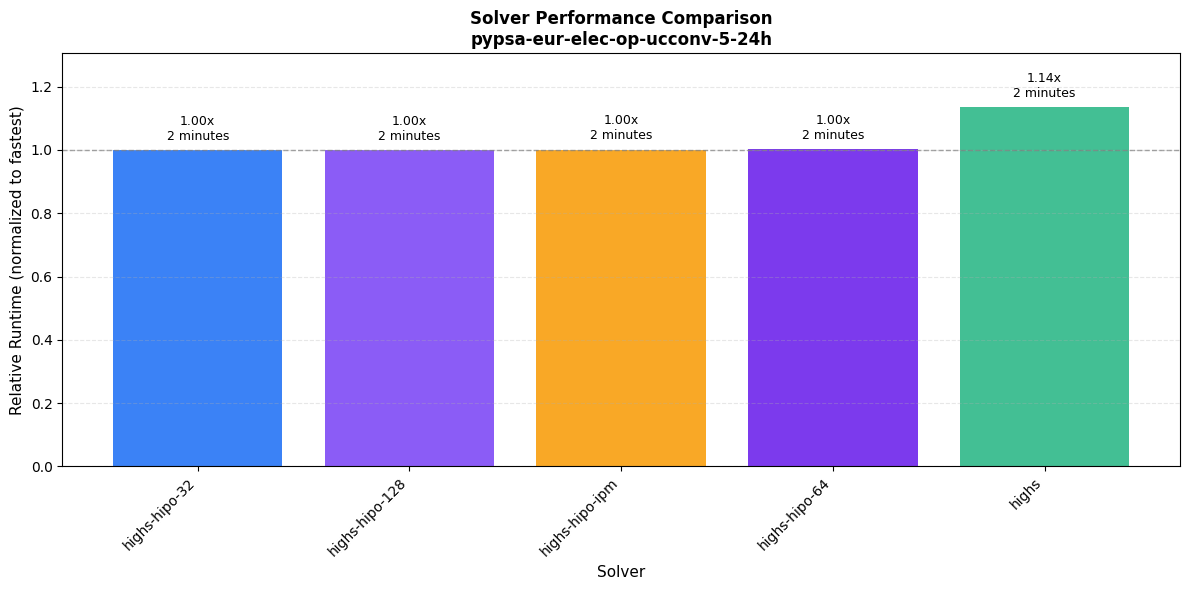


Benchmark: pypsa-eur-elec-trex-3-12h


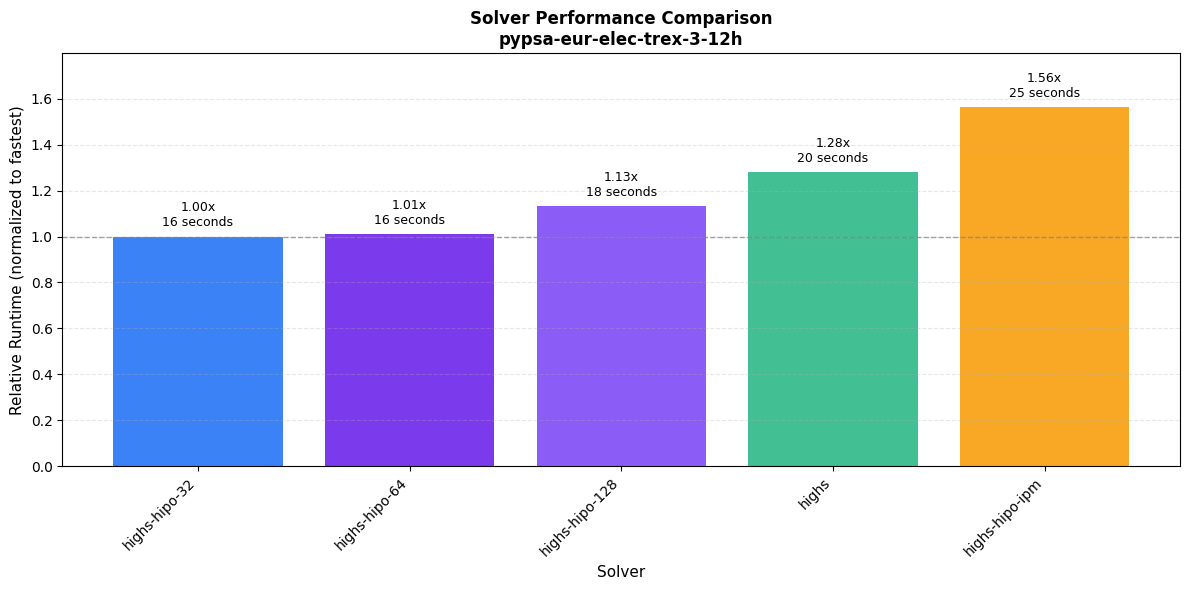


Benchmark: pypsa-eur-elec-trex-3-3h


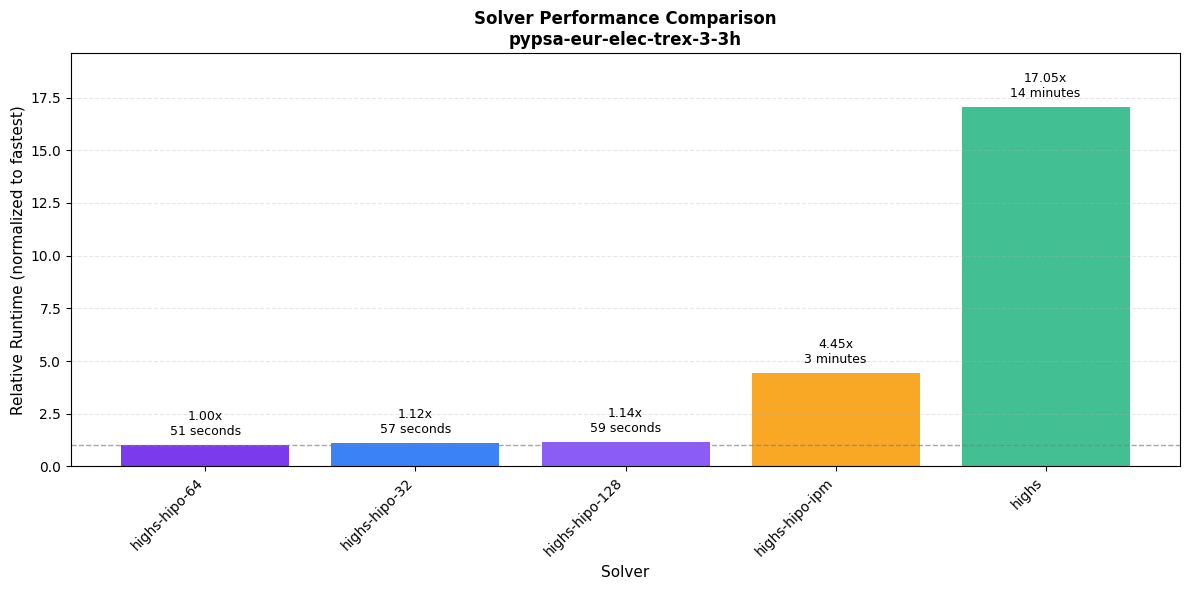


Benchmark: pypsa-eur-elec-trex-6-12h


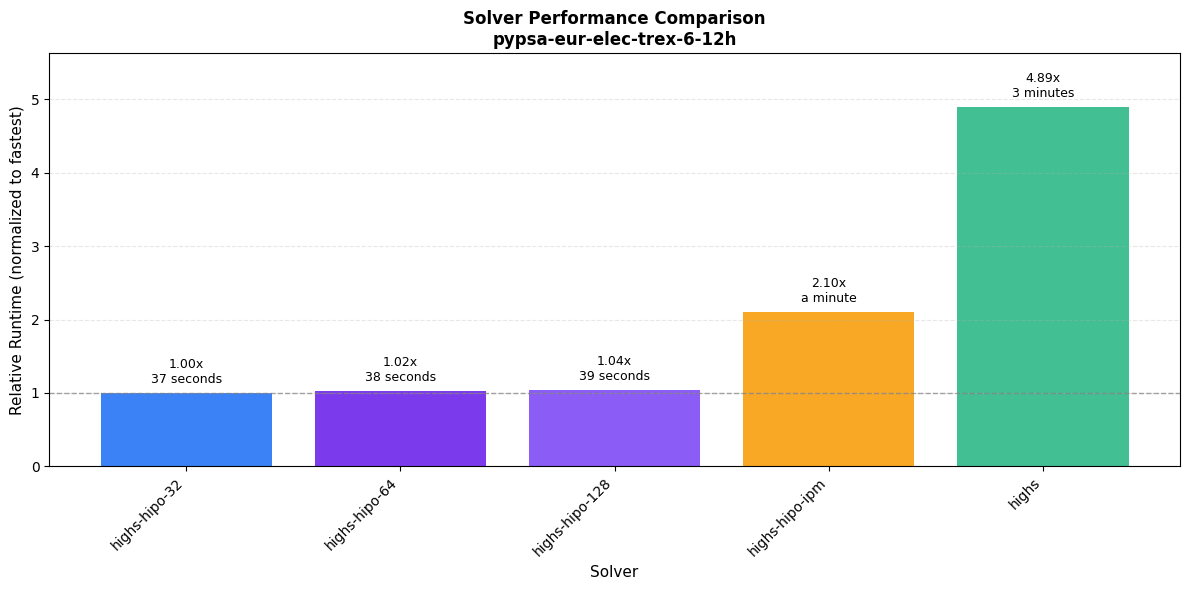


Benchmark: pypsa-eur-sec-2-24h


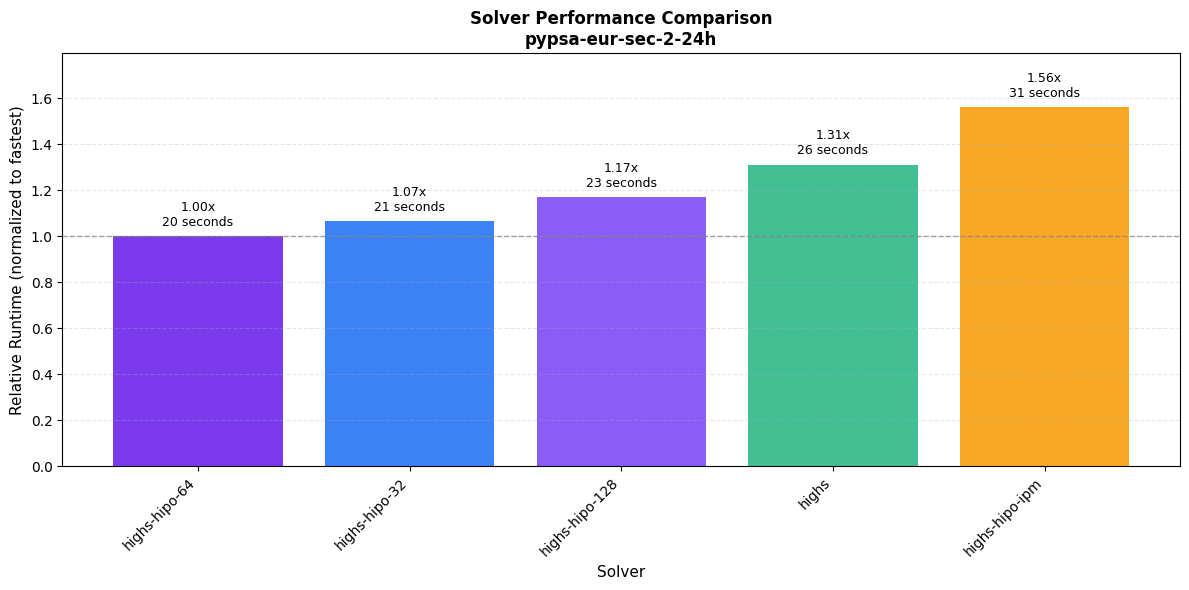


Benchmark: pypsa-eur-sec-2-3h
No successful runs for benchmark: pypsa-eur-sec-2-3h

Benchmark: pypsa-eur-sec-5-12h


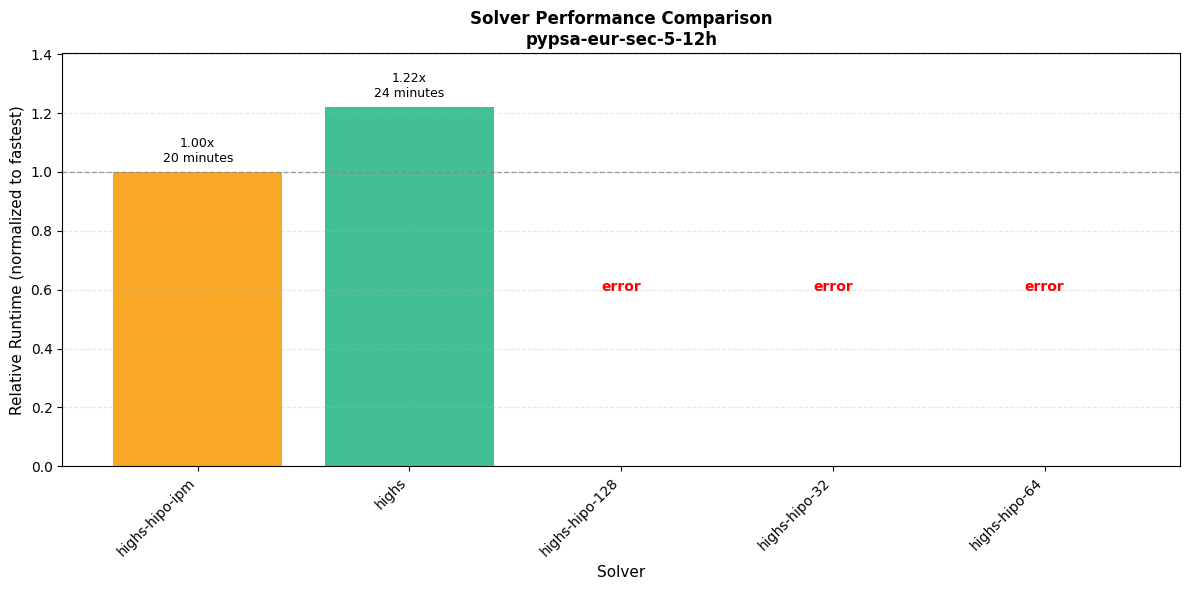


Benchmark: pypsa-eur-sec-6-24h


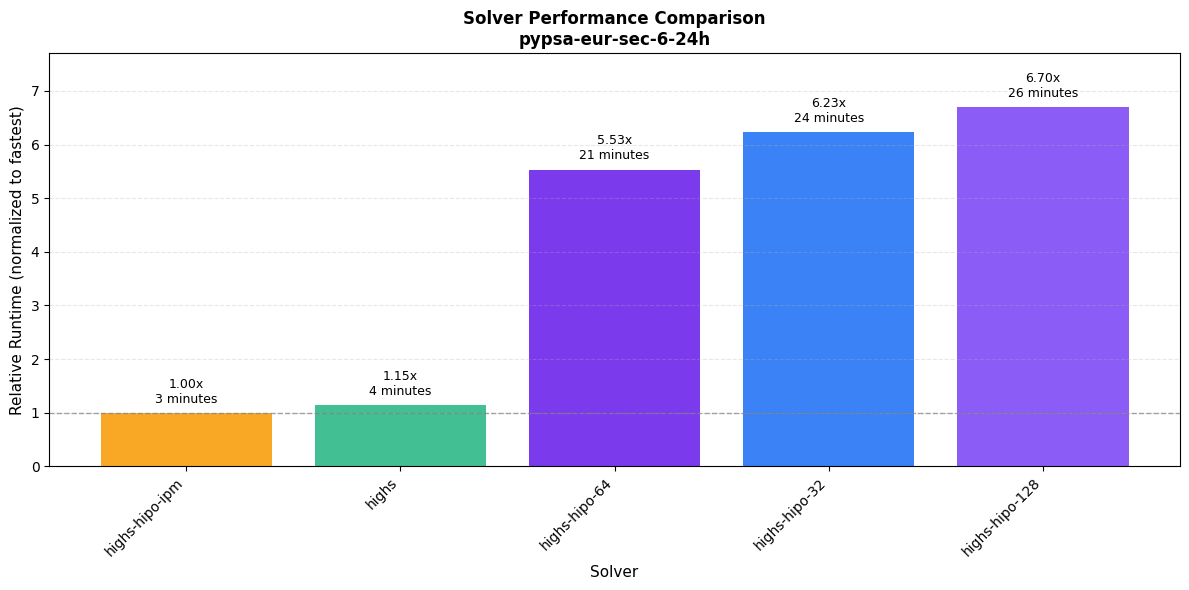


Benchmark: pypsa-power+ely+battery-1-1h


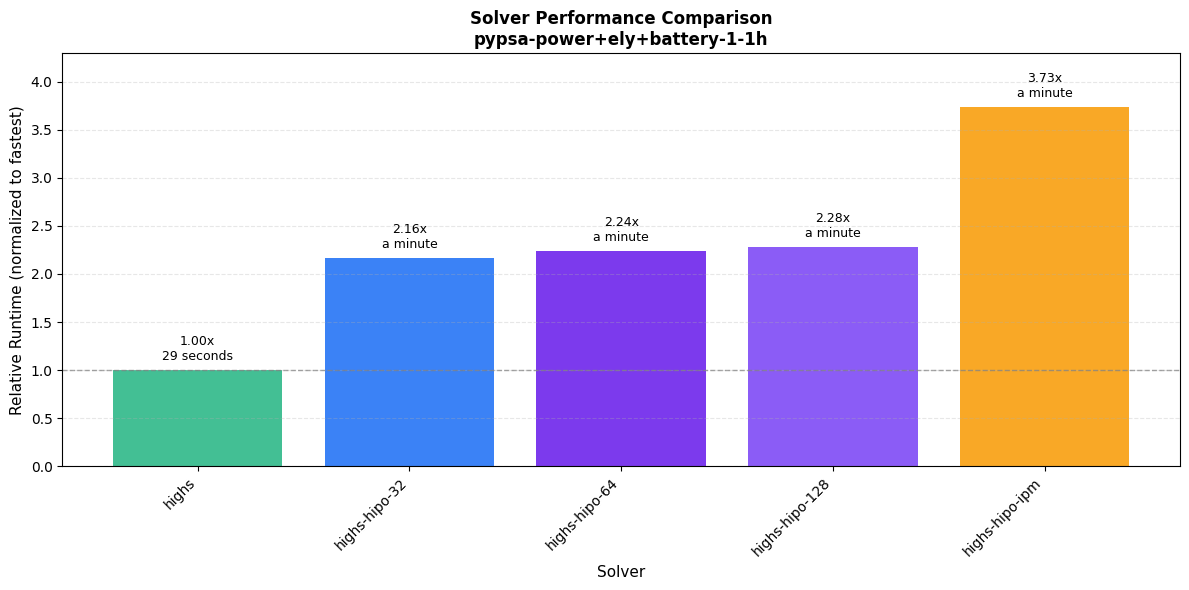


Benchmark: pypsa-power+ely+battery-mod-1-1h


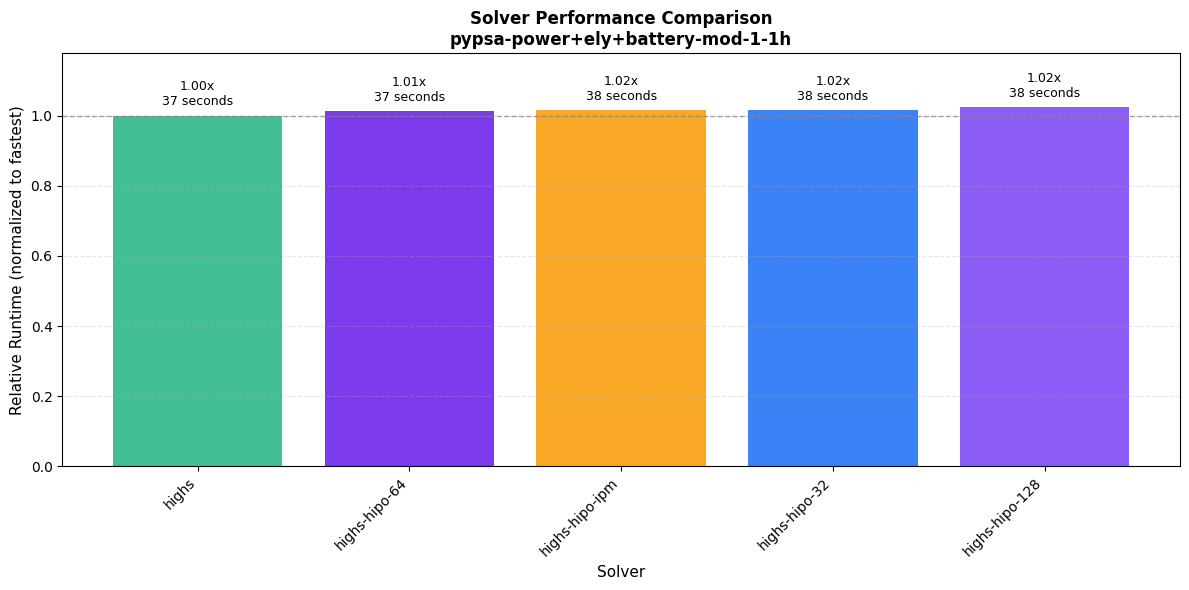


Benchmark: pypsa-power+ely+battery-ucgas-1-1h


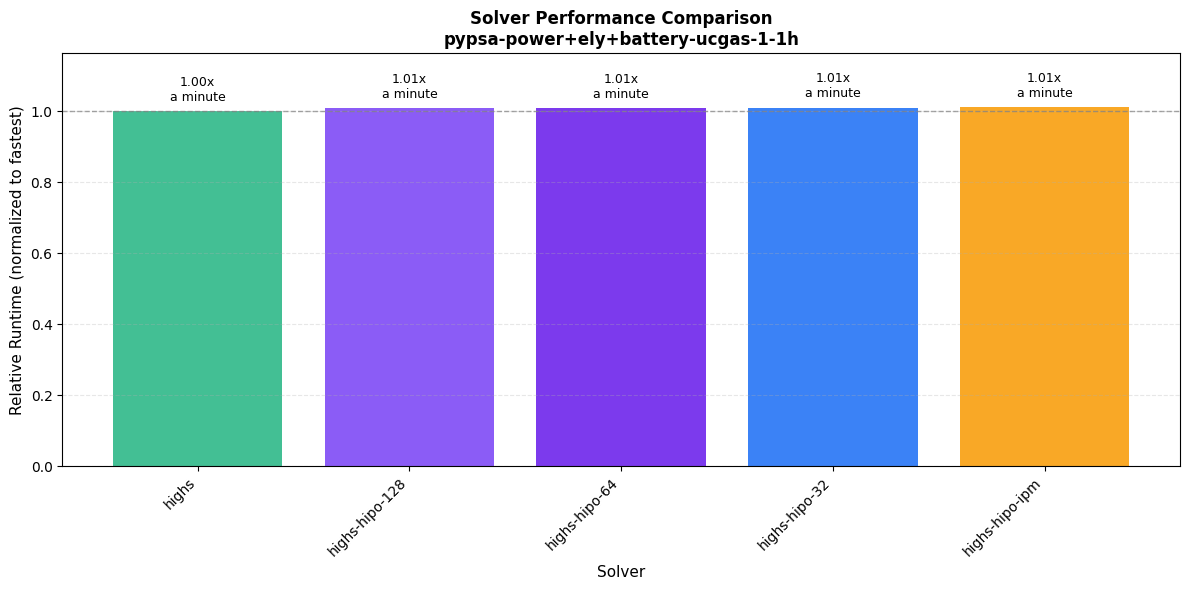


Benchmark: pypsa-power+ely+battery-ucgas-mod-1-1h


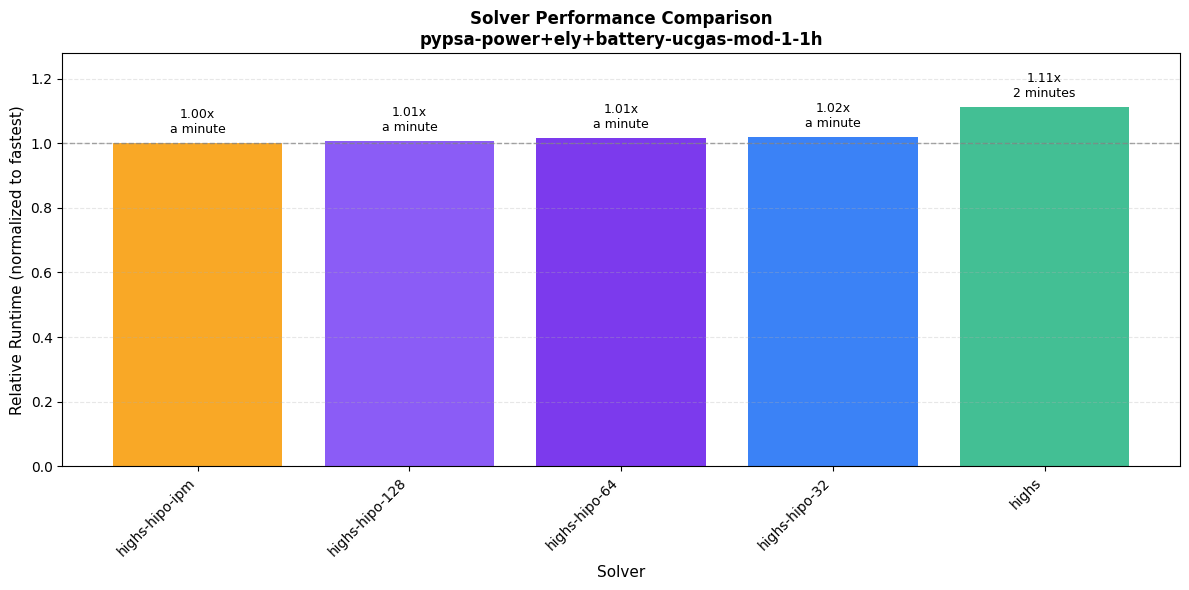


Benchmark: pypsa-power+ely-1-1h


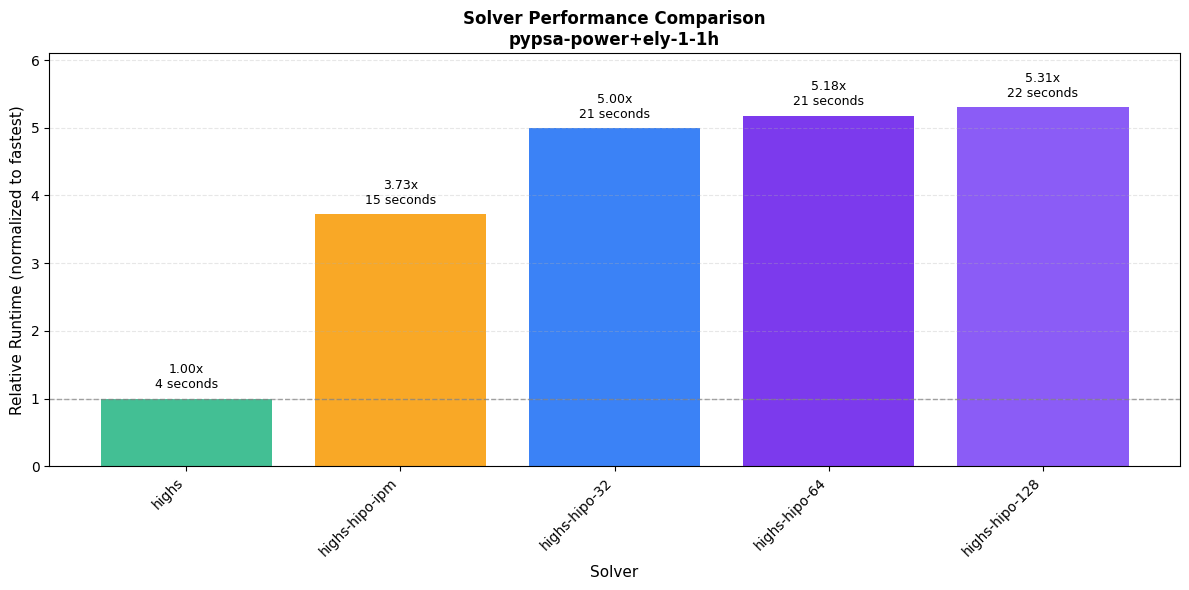


Benchmark: pypsa-power+ely-co2-1-1h


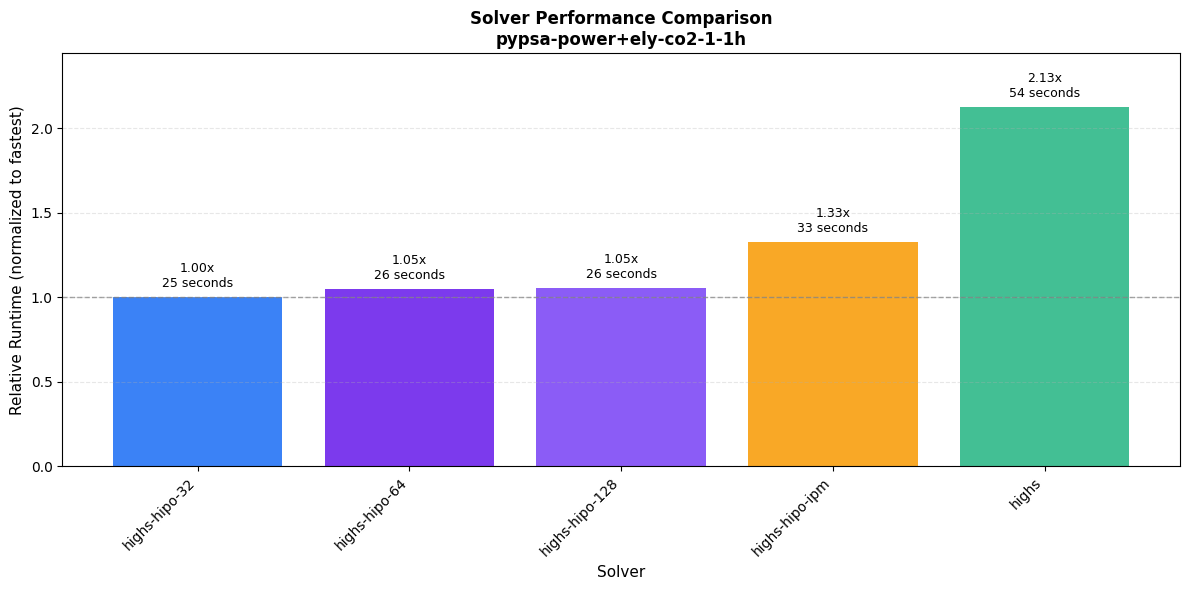


Benchmark: pypsa-power+ely-co2-mod-1-1h


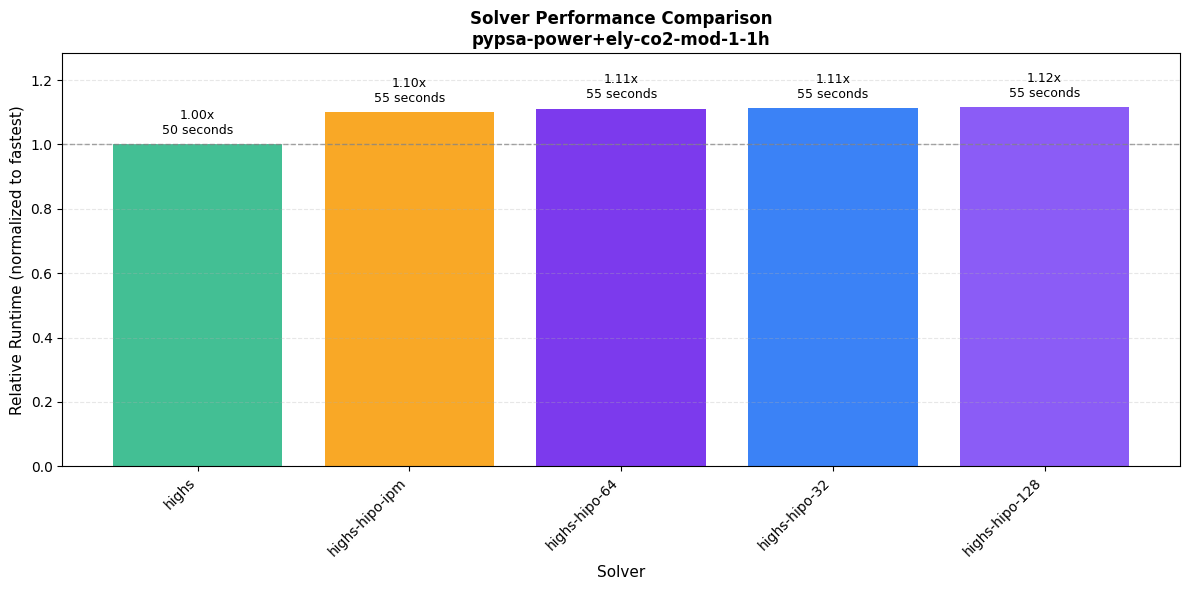


Benchmark: pypsa-power+ely-mod-1-1h


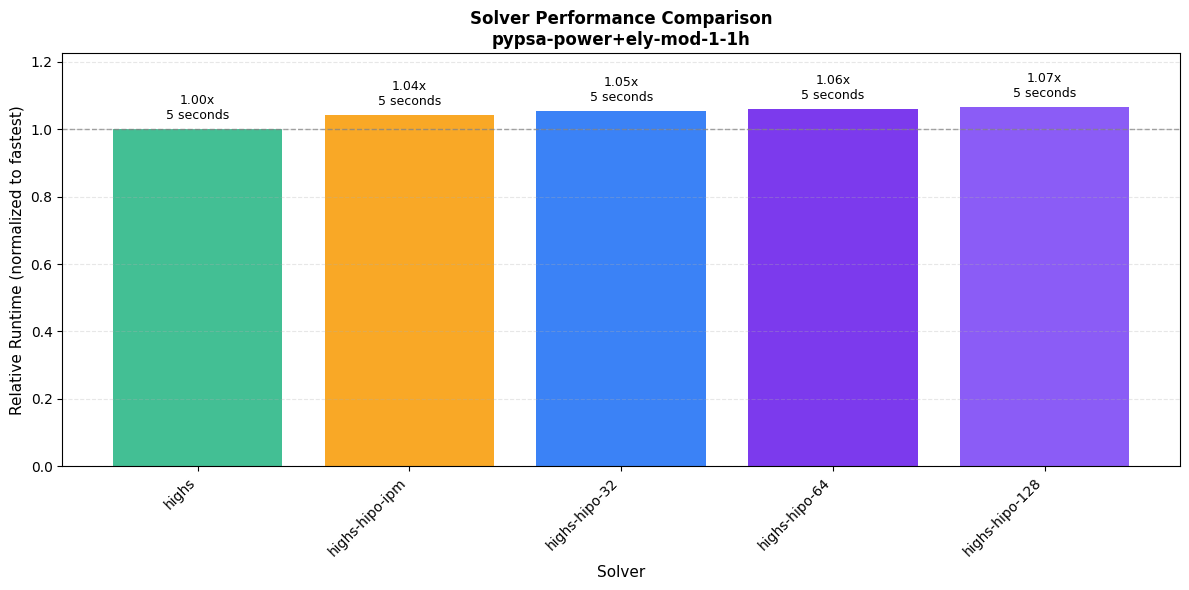


Benchmark: pypsa-power+ely-ucgas-1-1h


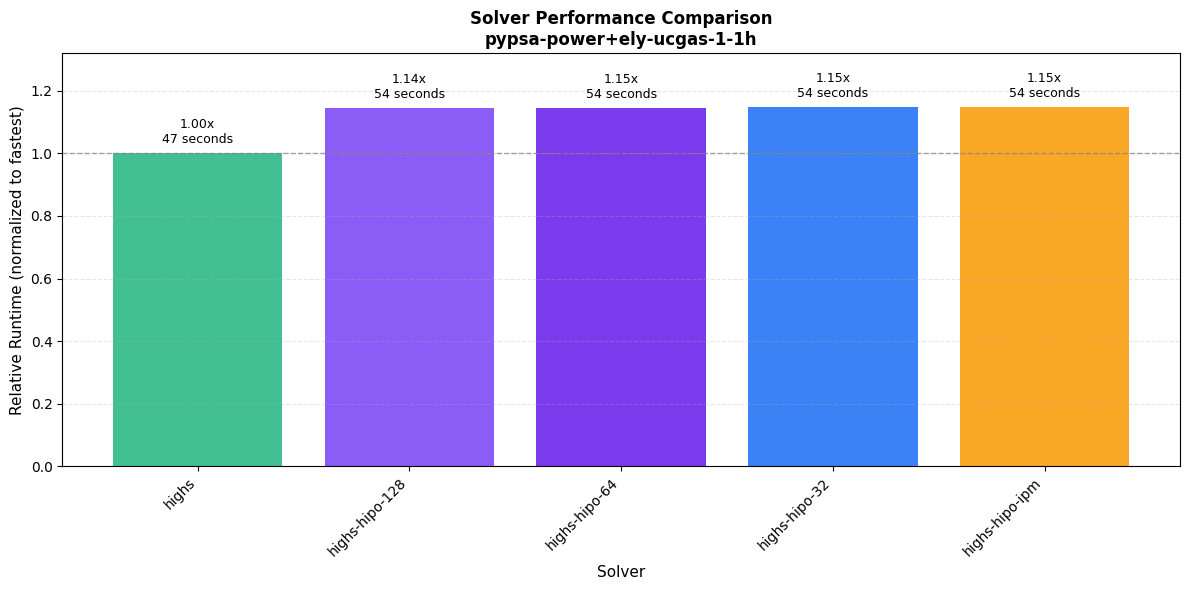


Benchmark: pypsa-power+ely-ucgas-mod-1-1h


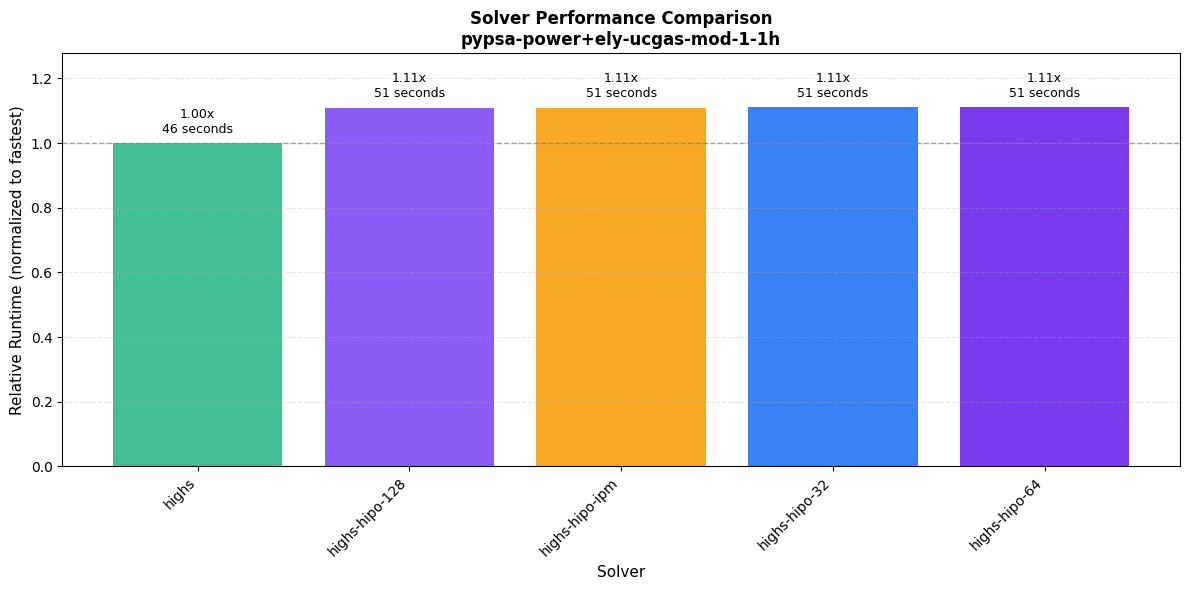


Benchmark: temoa-US_9R_TS_NZ-9-12


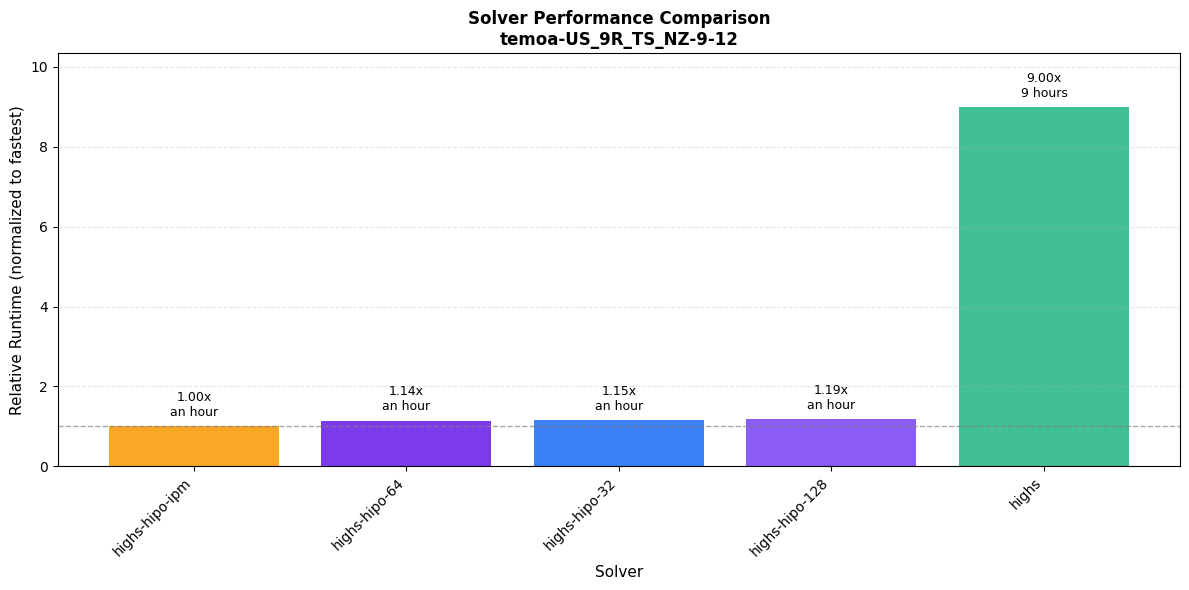


Benchmark: temoa-US_9R_TS_NZ_trunc_4periods-9-12


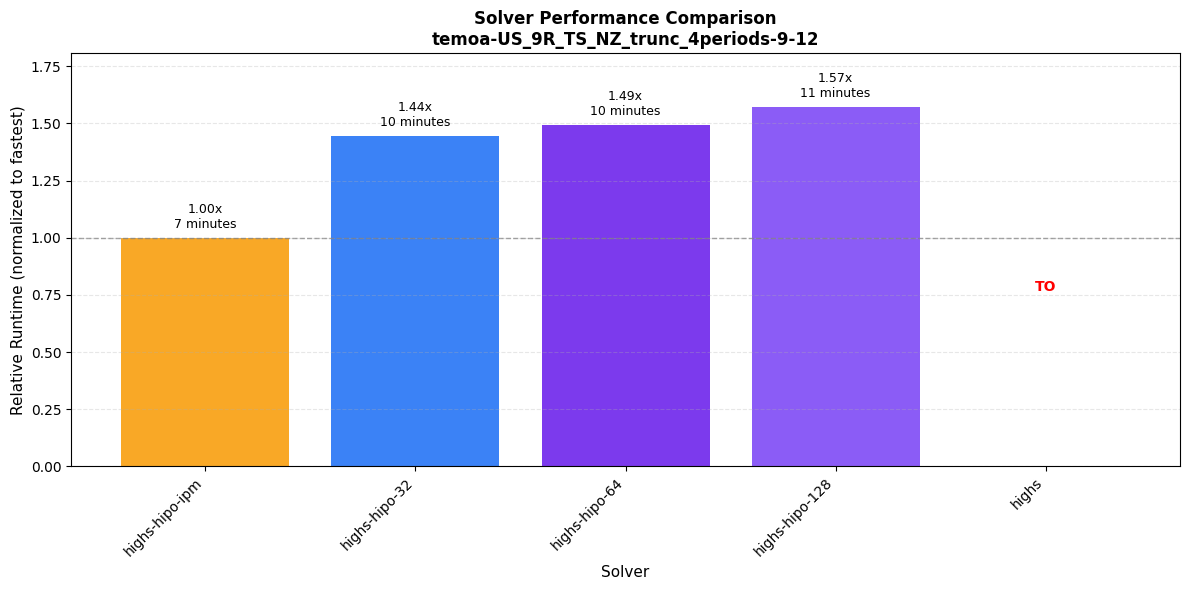


Benchmark: temoa-utopia-1-6


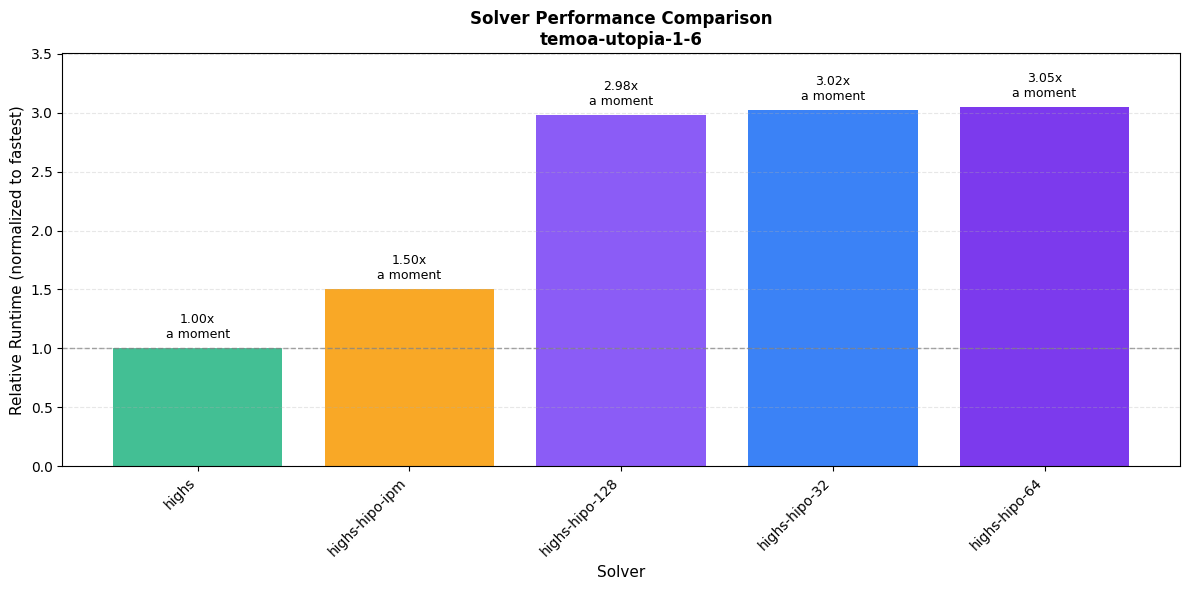


Benchmark: times-etimeseu-europe-elec+heat-co2-single_stage-29-64ts


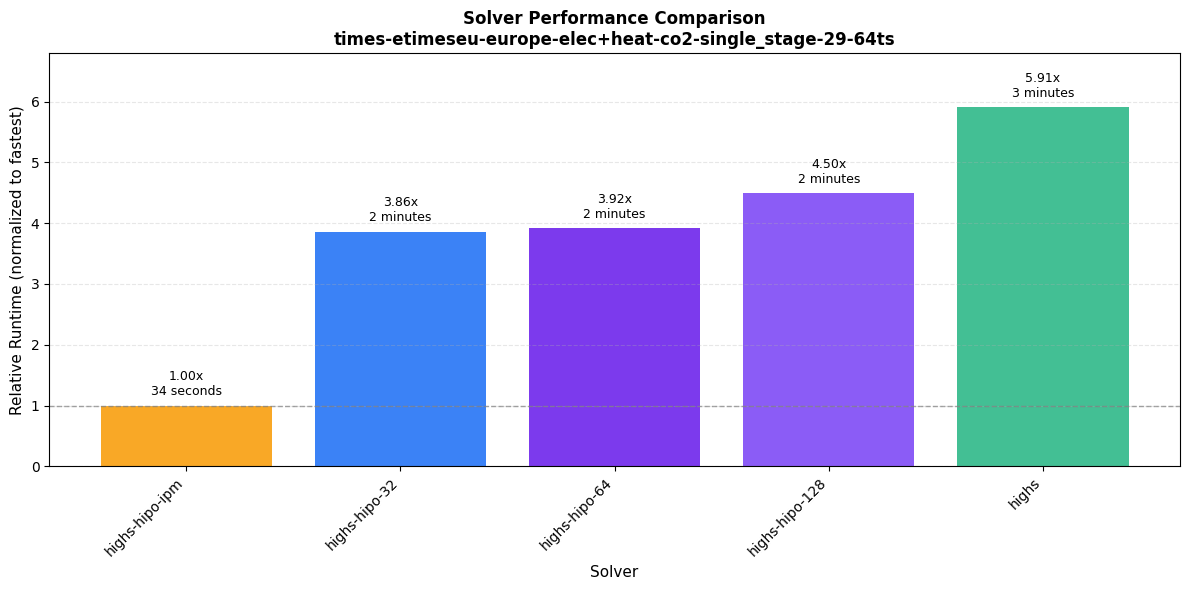


Benchmark: times-etimeseu-europe-elec+heat-multi_stage-29-64ts


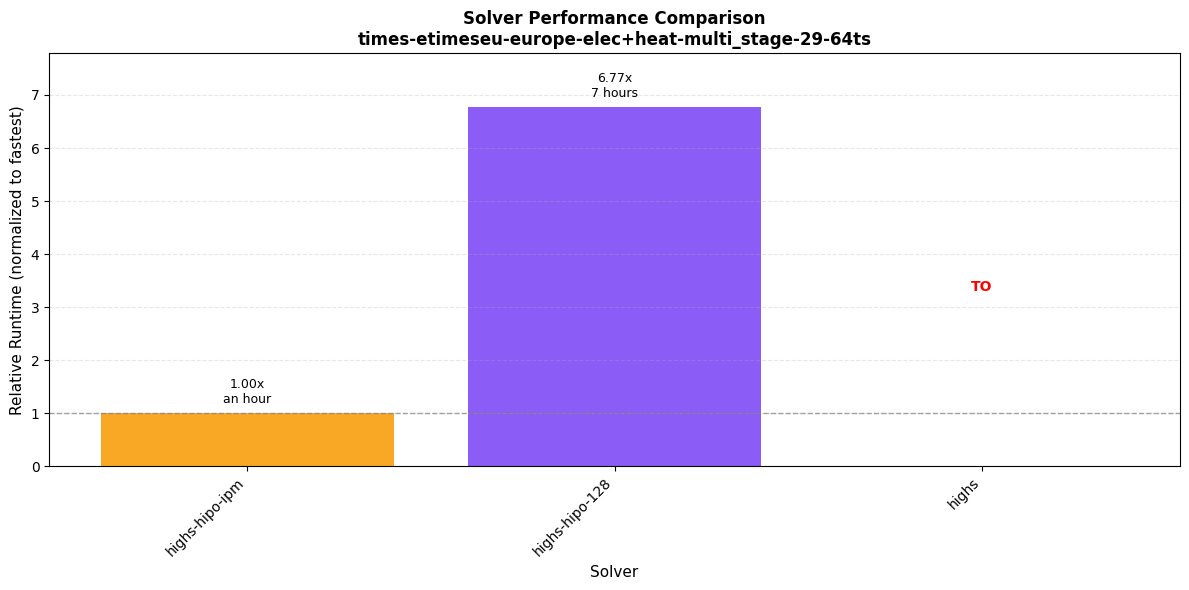


Benchmark: times-etimeseu-europe-elec+heat-single_stage-29-64ts


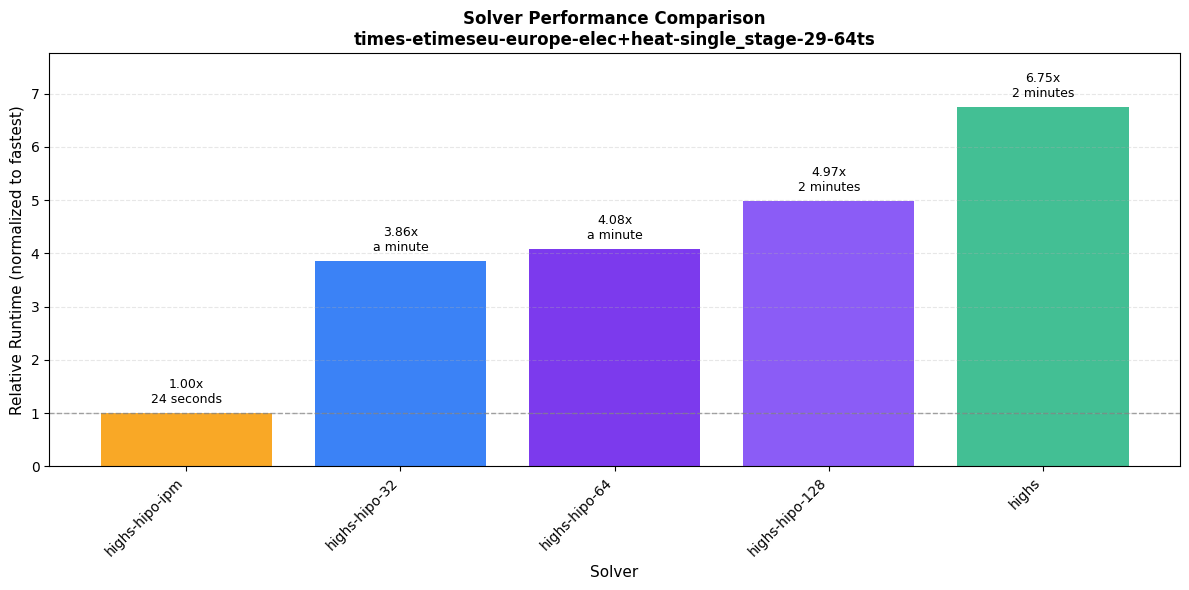


Benchmark: times-etimeseu-france-elec+heat-co2-multi_stage-1-64ts


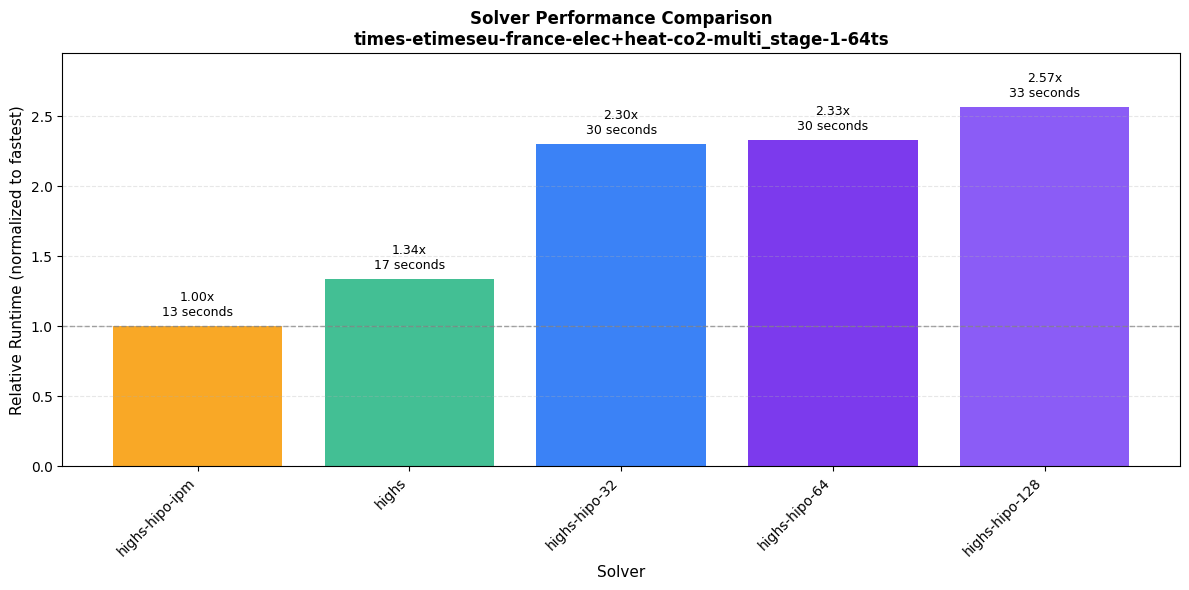


Benchmark: times-etimeseu-france-elec+heat-co2-single_stage-1-64ts


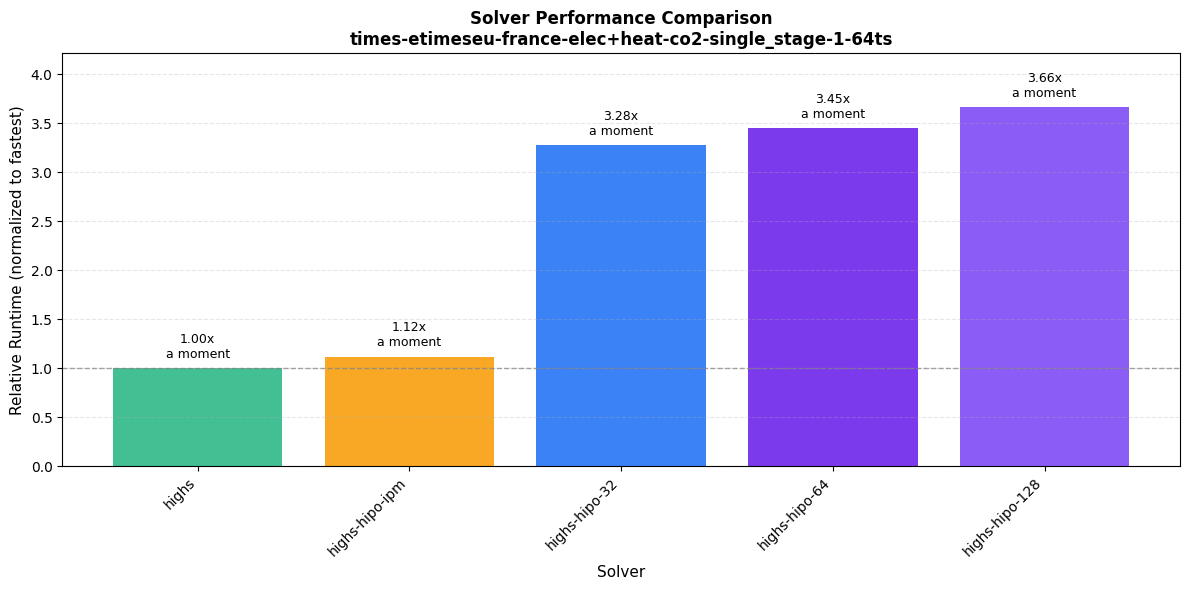


Benchmark: times-etimeseu-france-elec+heat-multi_stage-1-64ts


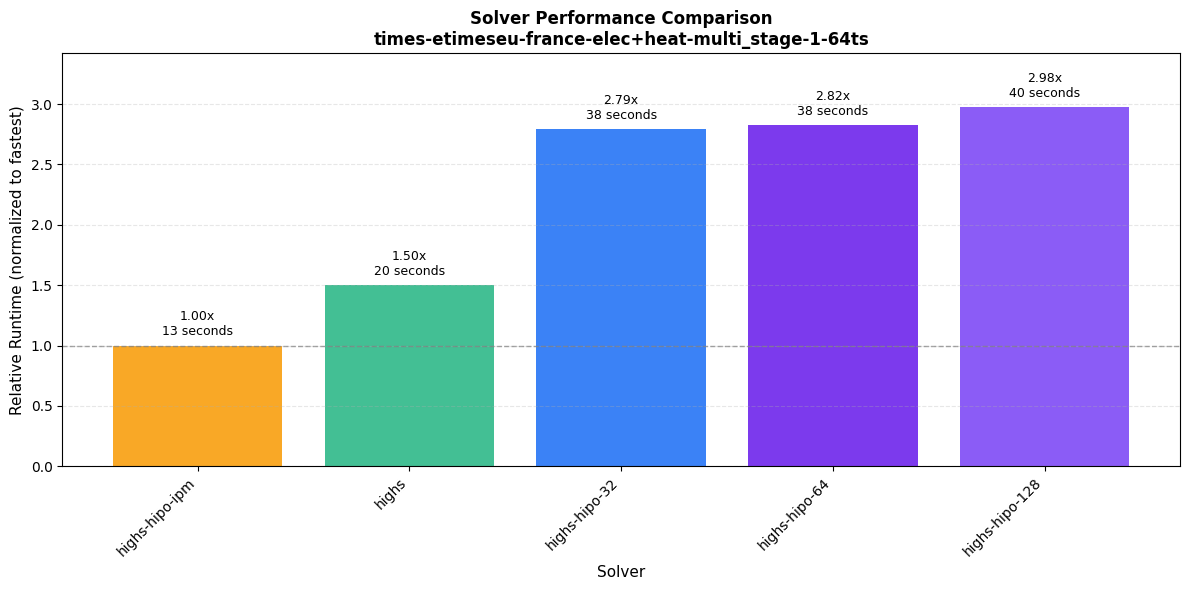


Benchmark: times-etimeseu-france-elec+heat-single_stage-1-64ts


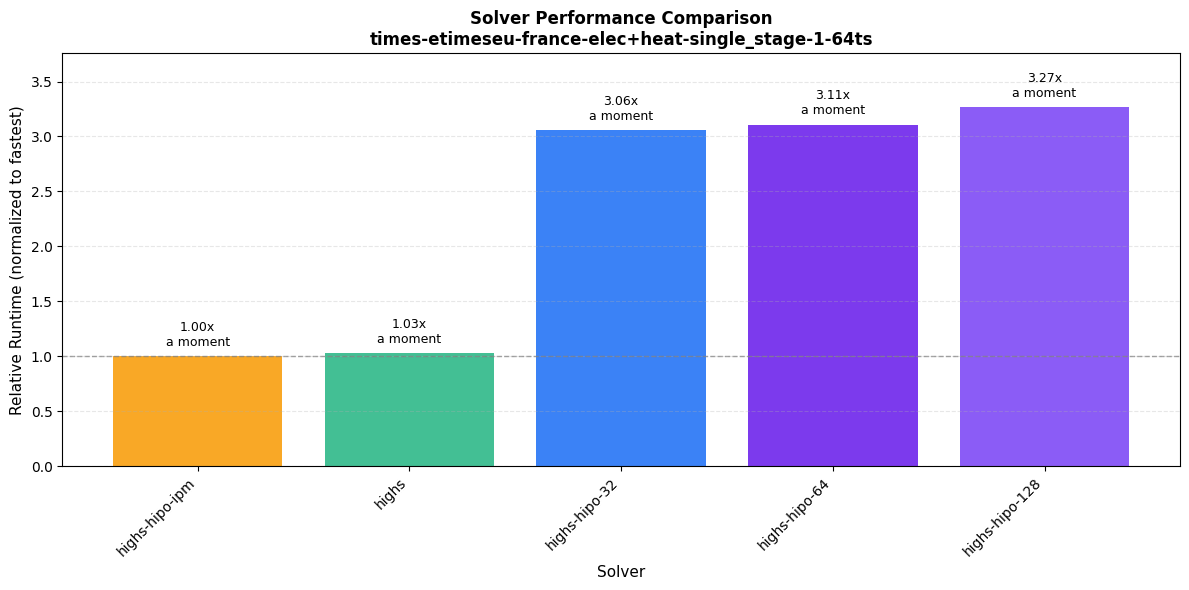


Benchmark: times-ireland-noco2-1-1h


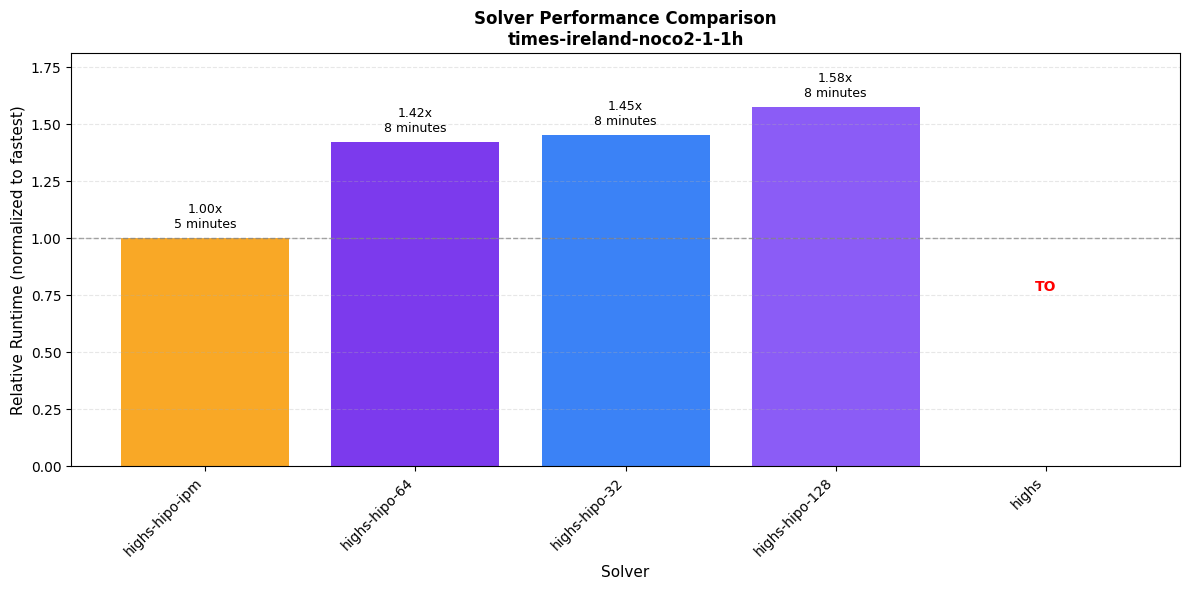


Benchmark: times-nz-kea-2-24h


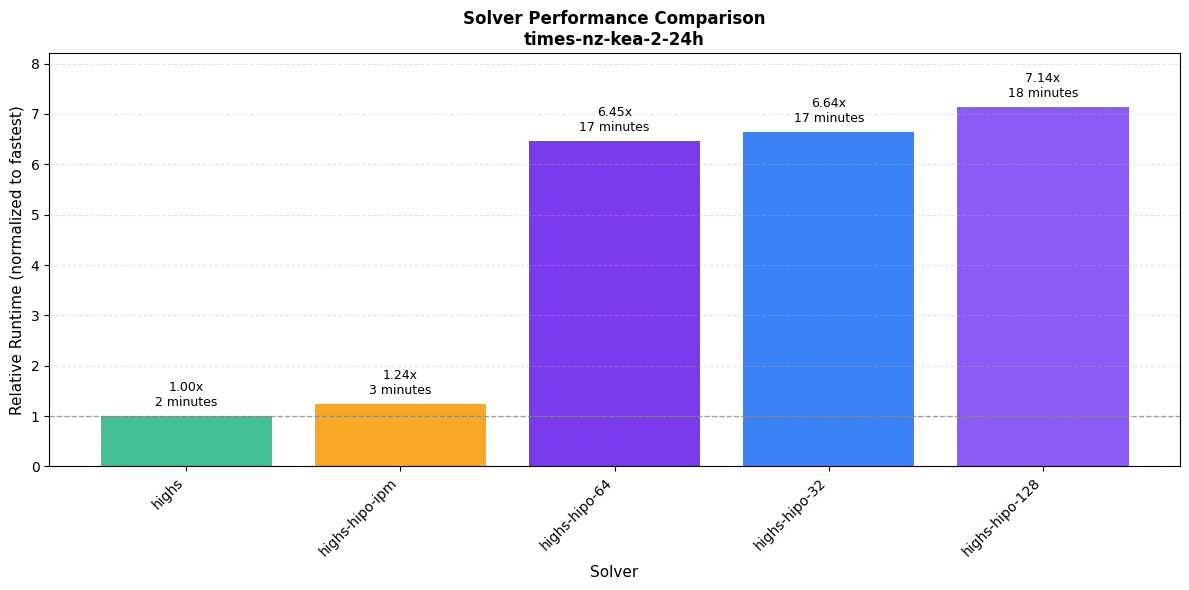


Benchmark: times-nz-tui-2-24h


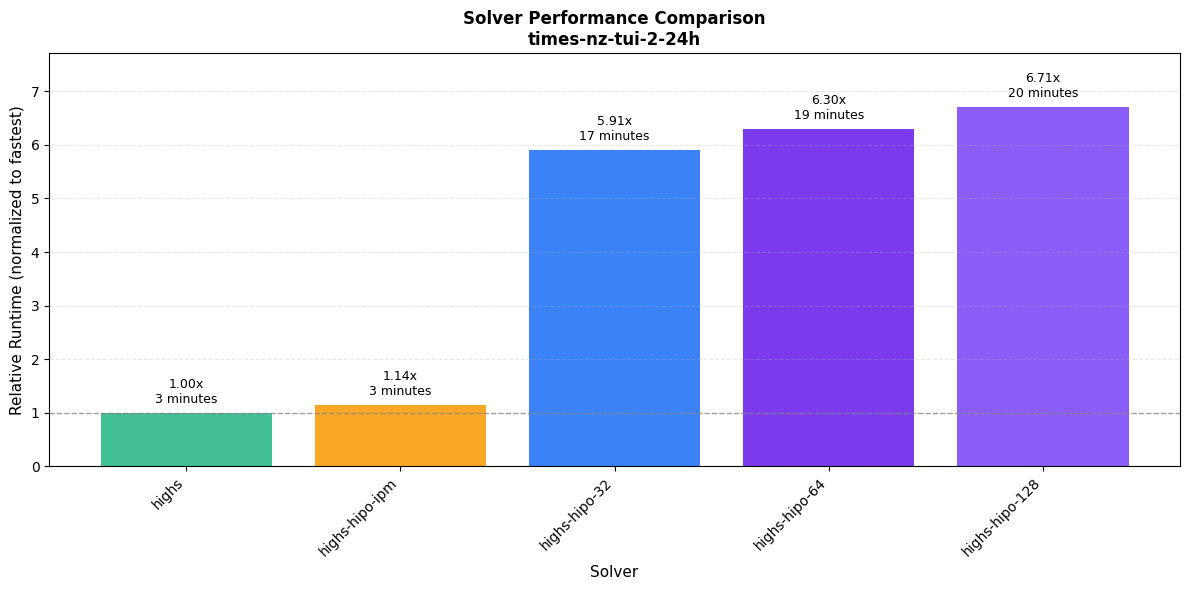


Benchmark: tulipa-1_EU_investment_simple-28-13h


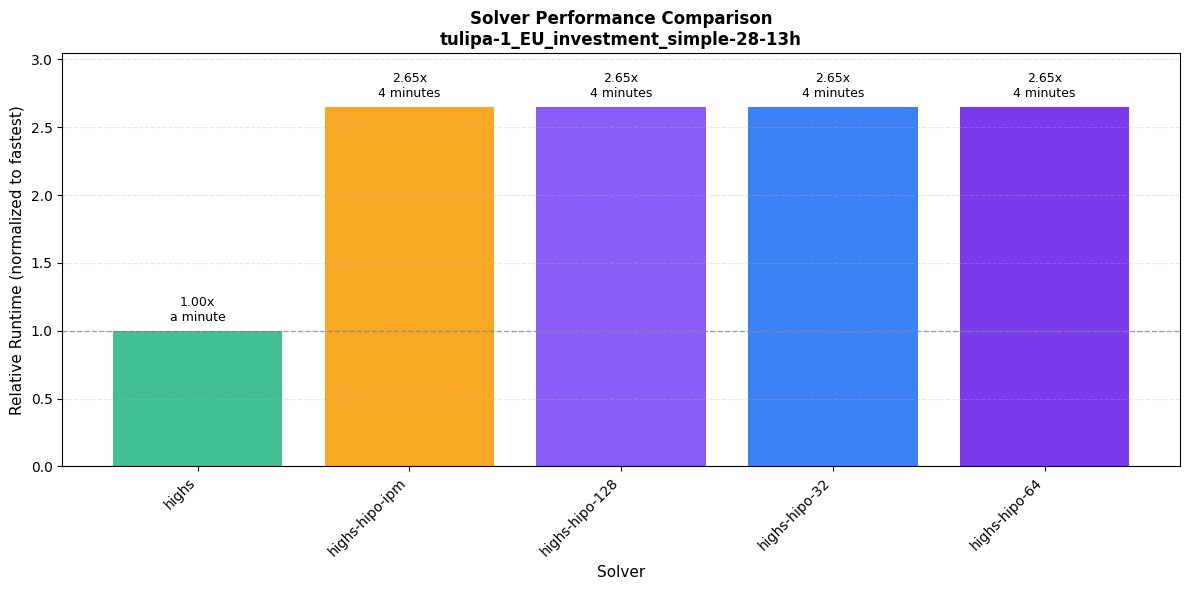


Benchmark: tulipa-1_EU_investment_simple-28-2.2h
No successful runs for benchmark: tulipa-1_EU_investment_simple-28-2.2h

Benchmark: tulipa-1_EU_investment_simple-28-24h


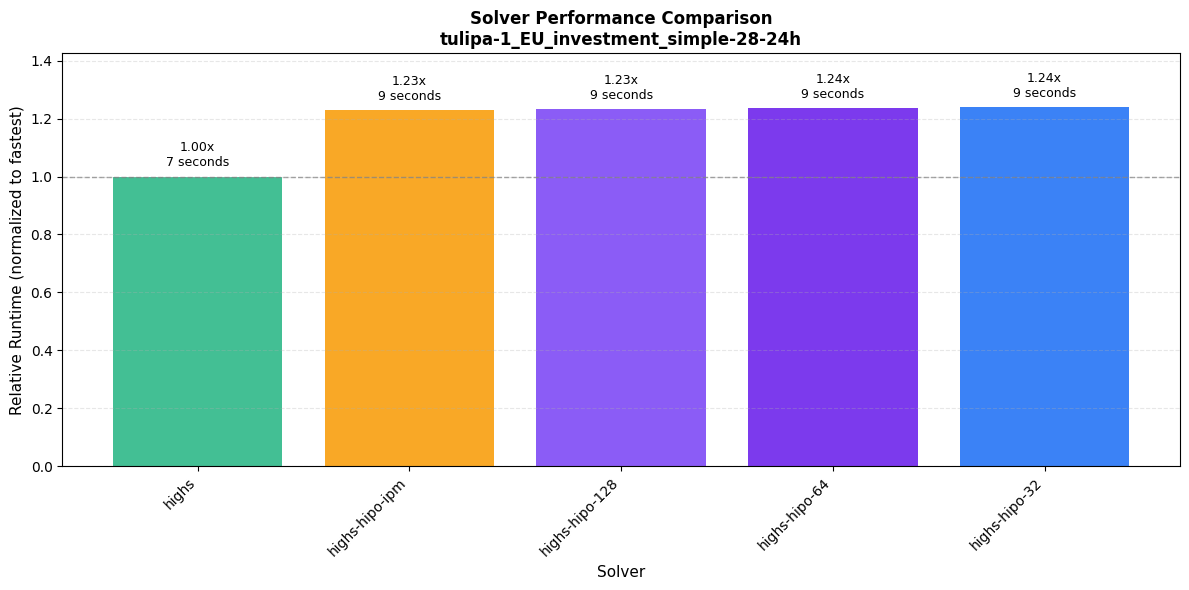


Benchmark: tulipa-1_EU_investment_simple-28-4.3h


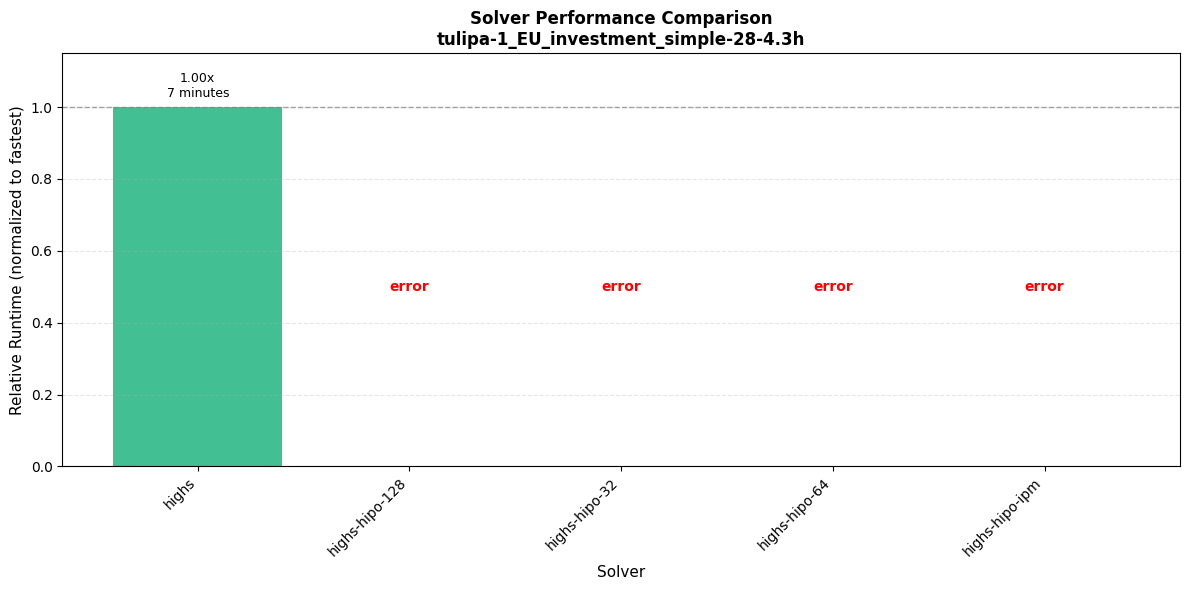


Benchmark: tulipa-1_EU_investment_simple-28-52.1h


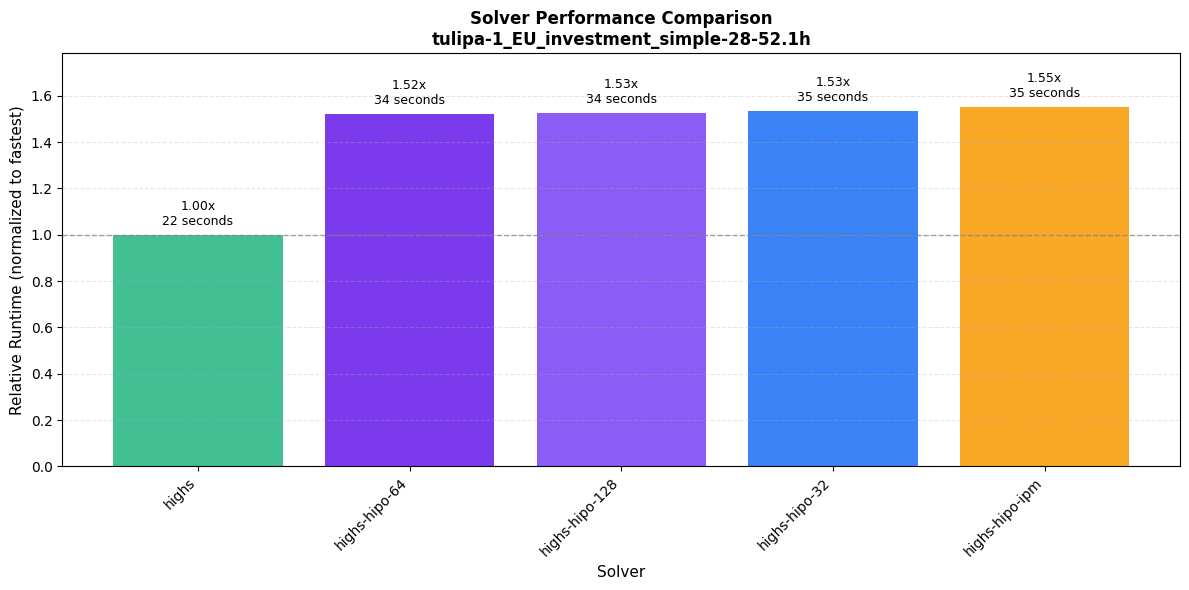

In [114]:
# Plot each benchmark individually with solvers on x-axis
for bench in sorted(unique_benchmarks):
    print(f"\n{'='*80}")
    print(f"Benchmark: {bench}")
    print(f"{'='*80}")
    plot_single_benchmark_comparison(results, bench, figsize=(12, 6))
    plt.show()

## Performance Statistics

In [115]:
# Calculate speedup statistics for each variant compared to baseline highs
baseline_solver = "highs"

# Get baseline runtimes for each benchmark
baseline_data = actual_benchmarks[actual_benchmarks["Solver"] == baseline_solver][
    ["bench-size", "Runtime (s)"]
].rename(columns={"Runtime (s)": "Baseline Runtime"})

# Merge with all results
comparison = actual_benchmarks.merge(baseline_data, on="bench-size", how="left")

# Calculate speedup
comparison["Speedup"] = comparison["Baseline Runtime"] / comparison["Runtime (s)"]

# Summary statistics by solver
speedup_summary = (
    comparison.groupby("Solver")["Speedup"]
    .agg(["mean", "median", "min", "max", "std"])
    .round(3)
)

print("Speedup Statistics (relative to highs 1.10.0):")
print(speedup_summary)

Speedup Statistics (relative to highs 1.10.0):
                 mean  median    min      max     std
Solver                                               
highs           1.000     1.0  1.000    1.000   0.000
highs-hipo-128  4.305     1.0  0.002  184.700  19.075
highs-hipo-32   4.308     1.0  0.006  172.432  18.152
highs-hipo-64   4.479     1.0  0.155  170.458  18.370
highs-hipo-ipm  1.970     1.0  0.002   17.522   2.722


## Memory Usage Comparison

In [116]:
# Memory usage comparison
memory_summary = (
    actual_benchmarks.groupby("Solver")["Memory Usage (MB)"]
    .agg(["mean", "median", "min", "max", "std"])
    .round(2)
)

print("Memory Usage Statistics (MB):")
print(memory_summary)

Memory Usage Statistics (MB):
                   mean  median     min       max      std
Solver                                                    
highs           1619.99  787.52  144.15  21975.19  2849.85
highs-hipo-128  1449.94  340.23  136.64  19769.71  3434.57
highs-hipo-32   1282.17  338.40  136.24  19630.66  2914.44
highs-hipo-64    935.09  339.42  136.46   6397.91  1496.51
highs-hipo-ipm   636.03  224.16  136.27   6154.92  1108.15


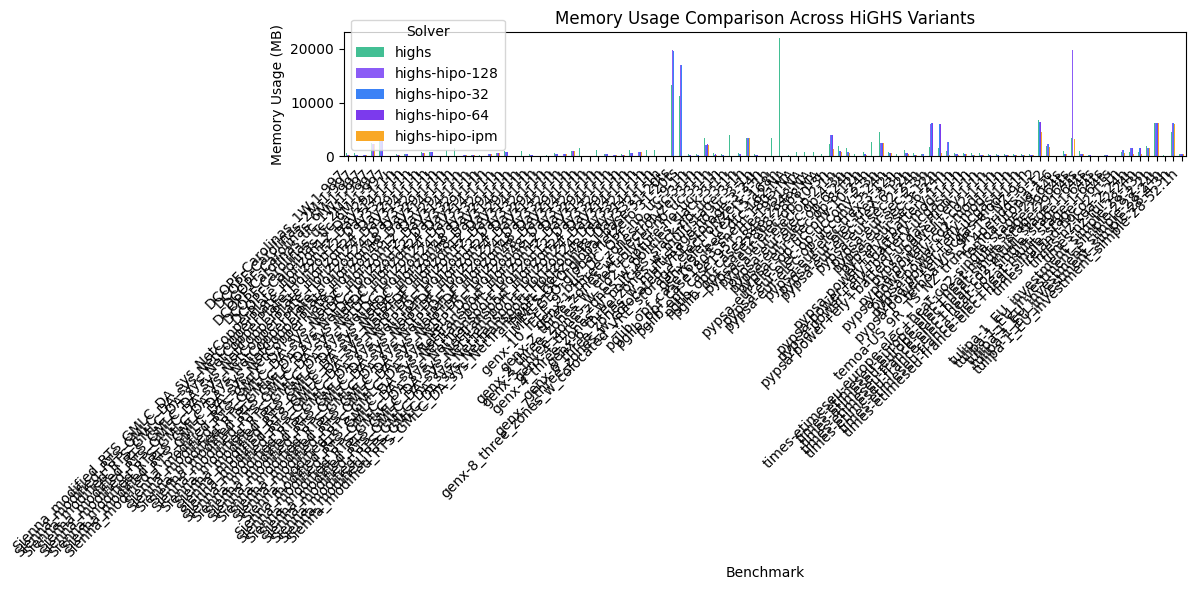

In [117]:
# Plot memory usage comparison
fig, ax = plt.subplots(figsize=(12, 6))

pivot_memory = actual_benchmarks.pivot_table(
    index="bench-size", columns="Solver", values="Memory Usage (MB)", aggfunc="mean"
)

pivot_memory.plot(kind="bar", ax=ax, color=[color_map.get(s, "#888888") for s in pivot_memory.columns])
ax.set_ylabel("Memory Usage (MB)")
ax.set_xlabel("Benchmark")
ax.set_title("Memory Usage Comparison Across HiGHS Variants")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Runtime vs Memory Trade-off

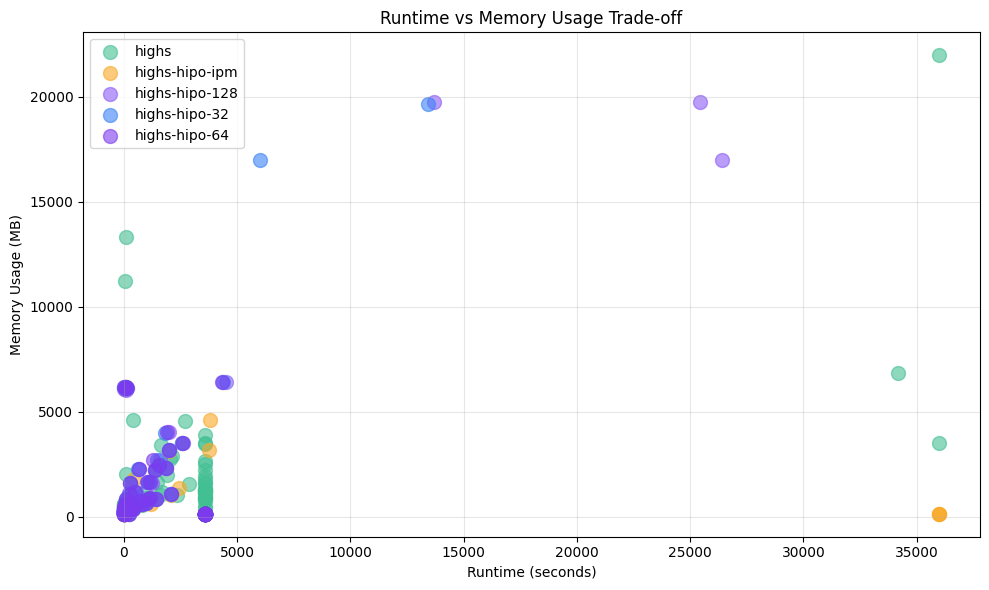

In [118]:
# Scatter plot: runtime vs memory usage
fig, ax = plt.subplots(figsize=(10, 6))

for solver in actual_benchmarks["Solver"].unique():
    solver_data = actual_benchmarks[actual_benchmarks["Solver"] == solver]
    ax.scatter(
        solver_data["Runtime (s)"],
        solver_data["Memory Usage (MB)"],
        label=solver,
        alpha=0.6,
        s=100,
        color=color_map.get(solver, "#888888"),
    )

ax.set_xlabel("Runtime (seconds)")
ax.set_ylabel("Memory Usage (MB)")
ax.set_title("Runtime vs Memory Usage Trade-off")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Detailed Benchmark-by-Benchmark Analysis

In [119]:
# For each benchmark, show detailed comparison
for bench in sorted(unique_benchmarks):
    bench_data = actual_benchmarks[actual_benchmarks["bench-size"] == bench]

    print(f"\n{'=' * 80}")
    print(f"Benchmark: {bench}")
    print(f"{'=' * 80}")

    # Create summary table
    summary = bench_data[["Solver", "Runtime (s)", "Memory Usage (MB)", "Status"]].copy()
    summary = summary.sort_values("Runtime (s)")

    # Calculate speedup relative to baseline
    baseline_runtime = bench_data[bench_data["Solver"] == baseline_solver][
        "Runtime (s)"
    ].values
    if len(baseline_runtime) > 0:
        summary["Speedup vs highs"] = baseline_runtime[0] / summary["Runtime (s)"]
        summary["Speedup vs highs"] = summary["Speedup vs highs"].round(3)

    print(summary.to_string(index=False))
    print()


Benchmark: DCOPF-Carolinas_1W-1-997
        Solver  Runtime (s)  Memory Usage (MB) Status  Speedup vs highs
         highs     9.580801            624.612     ok             1.000
highs-hipo-ipm    10.867961            280.208     ok             0.882
 highs-hipo-32    16.550848            338.920     ok             0.579
highs-hipo-128    30.337095            341.236     ok             0.316
 highs-hipo-64    30.387234            342.176     ok             0.315


Benchmark: DCOPF-Carolinas_2M-1-997
        Solver  Runtime (s)  Memory Usage (MB) Status  Speedup vs highs
         highs    10.932277            621.916     ok             1.000
 highs-hipo-32    11.936978            338.400     ok             0.916
highs-hipo-ipm    12.335830            278.288     ok             0.886
 highs-hipo-64    20.097734            339.676     ok             0.544
highs-hipo-128    20.252379            339.252     ok             0.540


Benchmark: DCOPF-Carolinas_6M-1-997
        Solver  Runtime

## Reference Benchmark Consistency Check

Reference benchmark runs: 149

Runtime statistics:
count    149.000000
mean     192.915625
std       16.939371
min      179.824185
25%      181.402413
50%      184.063183
75%      198.023214
max      239.270748
Name: Runtime (s), dtype: float64

Coefficient of Variation: 0.0878
⚠ Moderate consistency (5% <= CV < 10%)


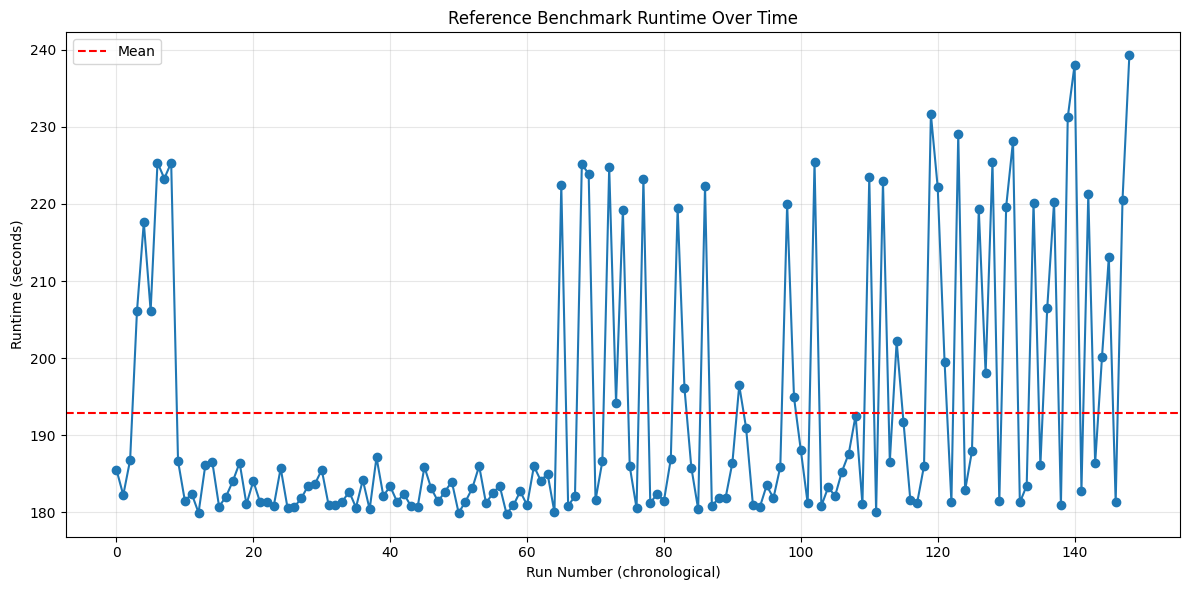

In [120]:
# Analyze reference benchmark to ensure consistent machine performance
reference_results = results[results["Benchmark"] == "reference-benchmark"].copy()

if len(reference_results) > 0:
    print(f"Reference benchmark runs: {len(reference_results)}")
    print(f"\nRuntime statistics:")
    print(reference_results["Runtime (s)"].describe())

    # Check coefficient of variation
    cv = (
        reference_results["Runtime (s)"].std() / reference_results["Runtime (s)"].mean()
    )
    print(f"\nCoefficient of Variation: {cv:.4f}")
    if cv < 0.05:
        print("✓ Good consistency (CV < 5%)")
    elif cv < 0.10:
        print("⚠ Moderate consistency (5% <= CV < 10%)")
    else:
        print("✗ Poor consistency (CV >= 10%)")

    # Plot reference benchmark over time
    fig, ax = plt.subplots(figsize=(12, 6))
    reference_sorted = reference_results.sort_values("Timestamp")
    ax.plot(range(len(reference_sorted)), reference_sorted["Runtime (s)"], "o-")
    ax.axhline(
        reference_sorted["Runtime (s)"].mean(),
        color="red",
        linestyle="--",
        label="Mean",
    )
    ax.set_xlabel("Run Number (chronological)")
    ax.set_ylabel("Runtime (seconds)")
    ax.set_title("Reference Benchmark Runtime Over Time")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No reference benchmark results found.")

## Key Findings Summary

In [121]:
print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# 1. Best overall variant
avg_runtimes = actual_benchmarks.groupby("Solver")["Runtime (s)"].mean().sort_values()
print(f"\n1. Average Runtime Ranking:")
for i, (solver, runtime) in enumerate(avg_runtimes.items(), 1):
    print(f"   {i}. {solver}: {runtime:.2f}s")

# 2. Best speedup
print(f"\n2. Best Average Speedup vs {baseline_solver}:")
speedup_by_solver = (
    comparison[comparison["Solver"] != baseline_solver]
    .groupby("Solver")["Speedup"]
    .mean()
    .sort_values(ascending=False)
)
for solver, speedup in speedup_by_solver.items():
    print(f"   {solver}: {speedup:.3f}x")

# 3. Memory efficiency
print(f"\n3. Average Memory Usage:")
avg_memory = actual_benchmarks.groupby("Solver")["Memory Usage (MB)"].mean().sort_values()
for solver, memory in avg_memory.items():
    print(f"   {solver}: {memory:.2f} MB")

# 4. Success rate
print(f"\n4. Success Rate:")
success_rate = (
    actual_benchmarks.groupby("Solver")["Status"]
    .apply(lambda x: (x == "ok").sum() / len(x) * 100)
    .sort_values(ascending=False)
)
for solver, rate in success_rate.items():
    print(f"   {solver}: {rate:.1f}%")


KEY FINDINGS

1. Average Runtime Ranking:
   1. highs-hipo-64: 880.73s
   2. highs-hipo-32: 1123.58s
   3. highs-hipo-128: 1641.57s
   4. highs-hipo-ipm: 2136.38s
   5. highs: 2275.06s

2. Best Average Speedup vs highs:
   highs-hipo-64: 4.479x
   highs-hipo-32: 4.308x
   highs-hipo-128: 4.305x
   highs-hipo-ipm: 1.970x

3. Average Memory Usage:
   highs-hipo-ipm: 636.03 MB
   highs-hipo-64: 935.09 MB
   highs-hipo-32: 1282.17 MB
   highs-hipo-128: 1449.94 MB
   highs: 1619.99 MB

4. Success Rate:
   highs-hipo-64: 81.3%
   highs-hipo-32: 80.0%
   highs-hipo-128: 78.6%
   highs-hipo-ipm: 75.2%
   highs: 70.3%
